In [ ]:
# Local setup: consolidated imports and helper functions
import os, sys, json, ast, time, random, math, pickle, itertools, textwrap
from typing import Any, List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib import patheffects as pe
from matplotlib.gridspec import GridSpec
from pathlib import Path
from tqdm import tqdm

# Use local python modules (no Colab file copying)
from python_helpers.sim_benchmark import DatasetConfig, NoiseConfig, BenchmarkConfig, run_benchmark
from python_helpers.real_data_pairwise import (
    make_pairwise_comparator,
    pairwise_comparison_elo,
    run_pairwise_with_llm,
)

# Project root and outputs dir
ROOT = ""
Path(ROOT, "sim_outputs").mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------

def make_grid(base: dict, **sweep_lists):
    """Cartesian product of parameter lists merged with a base dict."""
    keys = list(sweep_lists.keys())
    return [dict(base, **dict(zip(keys, vals))) for vals in itertools.product(*sweep_lists.values())]


def score_effCost(effectiveness: pd.Series, cost: pd.Series, alpha: float) -> pd.Series:
    """Combine normalized effectiveness and cost into a single score.
    alpha weights effectiveness vs cost (0..1). Higher is better.
    """
    return alpha * effectiveness + (1.0 - alpha) * cost


# ===== plotting utilities (latest version moved to top) =====

def _coerce_params(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            return v if isinstance(v, dict) else {"value": v}
        except Exception:
            return {"value": x}
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return {}
    return {"value": x}

METHOD_ALIAS = {"pruned_elo": "pruned", "listwise_rounds": "listwise", "streak": "streak", "hybrid": "hybrid"}

SHORT_KEYS = {
    "grouping_strategy": "grouping",
    "opponent_selection": "opp.sel",
    "min_distinct_opponents": "opp.min",
    "streak_min_distinct": "opp.min",
    "streak_r": "r",
    "r": "r",
    "streak_epochs": "epochs",
    "max_epochs": "epochs",
    "n_rounds": "rounds",
    "listwise_n_rounds": "lw.rounds",
    "boundary_passes": "boundary",
    "overlap": "overlap",
    "k": "k",
    "k_factor": "k",
    "randomness_factor": "rand",
    "match_strategy": "match",
    "prune_start_round": "prune.start",
    "prune_rounds": "prune.rounds",
    "prune_percent": "prune%",
    "listwise_call_budget": "lw.budget",
    "pairwise_call_budget": "pw.budget",
}
EXCLUDE_KEYS = {"initial_elo", "seed"}


def _fmt_val(v):
    if isinstance(v, float):
        return f"{v:.3g}"
    return str(v)


def _param_line_short(params: dict) -> str:
    p = _coerce_params(params)
    parts = []
    for k, v in p.items():
        if k in EXCLUDE_KEYS:
            continue
        sk = SHORT_KEYS.get(k, k)
        parts.append(f"{sk}={_fmt_val(v)}")
    return ", ".join(parts)


def _config_sig(method: str, params: dict):
    p = _coerce_params(params)
    return (method, tuple(sorted((k, None if p.get(k) is None else p.get(k)) for k in p.keys())))


def _luminance(rgb):
    r, g, b = rgb[:3]
    return 0.2126 * r + 0.7152 * g + 0.0722 * b


def _discover_dataset_instances(df: pd.DataFrame, instance_cols=None):
    if instance_cols is None:
        instance_cols = ["dataset"]
        if "scale_max" in df.columns:
            instance_cols.append("scale_max")
        if "scale_min" in df.columns:
            instance_cols.append("scale_min")

    inst_df = df.drop_duplicates(instance_cols).copy()
    counts = inst_df.groupby("dataset").size()

    inst_df["_letter"] = ""
    for dataset, sub_idx in inst_df.groupby("dataset").groups.items():
        idxs = list(sub_idx)
        if counts.loc[dataset] > 1:
            sort_cols = [c for c in instance_cols if c != "dataset"]
            if sort_cols:
                idxs = inst_df.loc[idxs].sort_values(sort_cols).index.tolist()
            for i, row_idx in enumerate(idxs):
                inst_df.at[row_idx, "_letter"] = chr(ord("a") + i)

    inst_df["_tag"] = inst_df.apply(
        lambda r: f"{r['dataset']}_{r['_letter']}" if r["_letter"] else f"{r['dataset']}", axis=1
    )

    df_out = df.merge(inst_df[instance_cols + ["_tag", "_letter"]], on=instance_cols, how="left")
    df_out.rename(columns={"_tag": "dataset_tag"}, inplace=True)

    def _letter_idx(letter: str) -> int:
        if not letter:
            return 0
        return ord(letter) - ord("a") + 1

    df_out["dataset_letter_idx"] = df_out["_letter"].apply(_letter_idx)

    def _col_label(r):
        base = f"{r['dataset_tag']} | bias = {int(r['bias_n'])}"
        if ("bias_delta" in r) and pd.notna(r["bias_delta"]):
            pass
        return base

    df_out["dataset_cfg"] = df_out.apply(_col_label, axis=1)

    legend_lines = []
    for tag, sub in df_out.groupby("dataset_tag"):
        seed_txt = "—"
        if "seed" in sub.columns:
            seeds = sorted(int(s) for s in pd.Series(sub["seed"]).dropna().unique())
            if seeds:
                seed_txt = ",".join(map(str, seeds))
        biases = sorted(int(b) for b in sub["bias_n"].dropna().unique())
        line = f"{tag}: seed={seed_txt}; biases=[{', '.join(map(str, biases))}]"
        if "bias_delta" in sub.columns and pd.notna(sub["bias_delta"]).any():
            deltas = sorted(int(x) for x in pd.Series(sub["bias_delta"]).dropna().unique())
            if len(deltas) == 1:
                line += f"; Δ={deltas[0]}"
            elif len(deltas) > 1:
                line += f"; Δ∈[{', '.join(map(str, deltas))}]"
        if "scale_max" in sub.columns and pd.notna(sub["scale_max"]).any():
            sm = sorted(set(int(x) for x in pd.Series(sub["scale_max"]).dropna().unique()))
            if len(sm) == 1:
                line += f"; scale_max={sm[0]}"
            elif len(sm) > 1:
                line += f"; scale_max∈[{', '.join(map(str, sm))}]"
        legend_lines.append(line)
    dataset_legend_text = "\n".join(sorted(legend_lines))
    return df_out, dataset_legend_text


def plot_config_vs_dataset_heatmap(
    res_df: pd.DataFrame,
    out_path: str = "sim_outputs/config_vs_dataset_heatmap.png",
    include_bias_delta_in_x: bool = False,
    value: str = "error",
    sort_configs_by: str = "method_then_error",
    calls_col: str = "effective_calls_api",
    annotate_values: bool = True,
    base_text_size: int = 10,
    tick_fontsize: int = 9,
    row_height: float = 0.45,
    width_scale: float = 1.30,
    info_box_wrap: int = 110,
    instance_cols=None,
):
    df = res_df.copy()
    df["params"] = df["params"].apply(_coerce_params)

    if calls_col not in df.columns:
        if "pairwise_calls_internal" in df.columns:
            pairwise_api = (df["pairwise_calls"] - df["pairwise_calls_internal"]).clip(lower=0)
        else:
            inferred = df["inferred_pairs"] if "inferred_pairs" in df.columns else 0
            pairwise_api = (df["pairwise_calls"] - inferred).clip(lower=0)
        df[calls_col] = pairwise_api + df["listwise_calls"]

    df["error"] = 1.0 - df["spearman"]
    if ("dataset" not in df.columns) or ("bias_n" not in df.columns):
        raise ValueError("Expected 'dataset' and 'bias_n' columns.")

    df, dataset_legend_text = _discover_dataset_instances(df, instance_cols=instance_cols)

    df["config_sig"] = df.apply(lambda r: _config_sig(r["method"], r["params"]), axis=1)
    reps = df.groupby("config_sig")["method","params"].apply(lambda g: g.iloc[0]).reset_index()
    sig_to_method = dict(zip(reps["config_sig"], reps["method"]))
    sig_to_params = dict(zip(reps["config_sig"], reps["params"]))
    sig_to_alias = {sig: METHOD_ALIAS.get(m, m) for sig, m in sig_to_method.items()}

    agg = (
        df.groupby(["config_sig", "dataset_cfg"])
        .agg(error=("error", "mean"), spearman=("spearman", "mean"), calls=(calls_col, "mean"))
        .reset_index()
    )

    per_cfg = (
        agg.groupby("config_sig")
        .agg(mean_error=("error", "mean"), mean_spearman=("spearman", "mean"), mean_calls=("calls", "mean"))
        .reset_index()
    )
    per_cfg["method"] = per_cfg["config_sig"].map(sig_to_method)
    per_cfg["alias"] = per_cfg["config_sig"].map(sig_to_alias)

    label_map = {}
    for m, sub in per_cfg.groupby("method"):
        sub = sub.sort_values("mean_calls")
        for i, (_, r) in enumerate(sub.iterrows()):
            letter = chr(ord("a") + i)
            label_map[r["config_sig"]] = f"{METHOD_ALIAS.get(m, m)}_{letter} [{int(round(r['mean_calls']))}]"

    if sort_configs_by == "calls":
        row_order = per_cfg.sort_values(["mean_calls", "mean_error"])["config_sig"].tolist()
    elif sort_configs_by == "method_then_error":
        row_order = per_cfg.sort_values(["method", "mean_error", "mean_calls"])["config_sig"].tolist()
    else:
        row_order = per_cfg.sort_values(["mean_error", "mean_calls"])["config_sig"].tolist()

    def _dist_from_tag(tag: str) -> str:
        return tag.split("_", 1)[0]

    def _letter_idx_from_tag(tag: str) -> int:
        parts = tag.split("_", 1)
        if len(parts) == 1 or not parts[1]:
            return 0
        return ord(parts[1]) - ord("a") + 1

    xmeta = df.drop_duplicates(["dataset_cfg", "dataset_tag", "bias_n"]).copy()
    xmeta["dist"] = xmeta["dataset_tag"].map(_dist_from_tag)
    xmeta["letter_idx"] = xmeta["dataset_tag"].map(_letter_idx_from_tag)
    dist_order = ["linear", "bimodal", "normal", "binary"]
    xmeta["dist"] = pd.Categorical(xmeta["dist"], dist_order, ordered=True)
    xmeta = xmeta.sort_values(["dist", "letter_idx", "bias_n"])
    col_order = xmeta["dataset_cfg"].tolist()

    val_col = "error" if value == "error" else "spearman"
    M = agg.pivot(index="config_sig", columns="dataset_cfg", values=val_col).reindex(index=row_order, columns=col_order)

    row_labels = [label_map[s] for s in M.index]
    col_labels = M.columns.tolist()

    H_rows = max(6.0, row_height * len(row_labels))
    W_cols = max(8.0, width_scale * 0.8 * len(col_labels))
    info_h_cfg = max(2.0, min(6.0, 0.10 * len(row_labels)))
    info_h_ds = max(1.5, min(5.0, 0.06 * max(8, len(col_labels))))

    fig = plt.figure(figsize=(W_cols, H_rows + info_h_cfg + info_h_ds))
    gs = GridSpec(nrows=3, ncols=1, height_ratios=[H_rows, info_h_cfg, info_h_ds], figure=fig)
    ax = fig.add_subplot(gs[0])
    ax_info = fig.add_subplot(gs[1])
    ax_info.axis("off")
    ax_info_ds = fig.add_subplot(gs[2])
    ax_info_ds.axis("off")

    cmap = get_cmap("Reds")
    if value == "error":
        im_data = M.values
        vmin, vmax = 0.0, float(np.nanpercentile(im_data, 95))
        cbar_label = "1 − Spearman ρ (lower is better)"
        descending = False
    else:
        im_data = 1.0 - M.values
        vmin, vmax = 0.0, float(np.nanpercentile(im_data, 95))
        cbar_label = "Spearman ρ (higher is better)"
        descending = True

    norm = Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(im_data, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm, zorder=0)

    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=tick_fontsize)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=tick_fontsize)

    ax.set_xticks(np.arange(-0.5, len(col_labels), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(row_labels), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.3, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)

    cbar = fig.colorbar(im, ax=ax, pad=0.012)
    cbar.set_label(cbar_label, fontsize=tick_fontsize)

    if annotate_values:
        vals = M.values
        Nrows, Ncols = vals.shape
        text_size = max(8, min(13, int(base_text_size + 40 / max(1, max(Nrows, Ncols)))))
        fmt = "{:.2f}"
        top5 = np.zeros_like(vals, dtype=bool)
        top1 = np.zeros_like(vals, dtype=bool)
        for j in range(Ncols):
            col = vals[:, j]
            idx = np.where(~np.isnan(col))[0]
            if not len(idx):
                continue
            order = idx[np.argsort(col[idx])]
            if descending:
                order = order[::-1]
            top_k = order[: min(5, len(order))]
            top5[top_k, j] = True
            top1[order[0], j] = True

        for i in range(Nrows):
            for j in range(Ncols):
                v = vals[i, j]
                if np.isnan(v):
                    continue
                rgba = cmap(norm(im_data[i, j]))
                txt_col = "black" if _luminance(rgba) > 0.6 else "white"
                t = ax.text(
                    j,
                    i,
                    fmt.format(v),
                    ha="center",
                    va="center",
                    fontsize=text_size,
                    color=txt_col,
                    zorder=5,
                )
                t.set_path_effects([pe.withStroke(linewidth=1.2, foreground=("white" if txt_col == "black" else "black"))])
                if top5[i, j]:
                    t.set_fontweight("bold")
                if top1[i, j]:
                    try:
                        t.set_underline(True)
                    except Exception:
                        ax.plot([j - 0.35, j + 0.35], [i + 0.35, i + 0.35], color=txt_col, linewidth=1.3, zorder=6)

    ax.set_title("Model configuration × Dataset configuration — ranking quality", pad=8, fontsize=11)

    lines_cfg = []
    for sig in M.index:
        label = [f for f in (label_map.get(sig),) if f][0]
        line = f"{label}: " + _param_line_short(sig_to_params[sig])
        lines_cfg.append(textwrap.fill(line, width=info_box_wrap, subsequent_indent="    "))
    ax_info.text(
        0.0,
        1.0,
        "\n".join(lines_cfg),
        transform=ax_info.transAxes,
        ha="left",
        va="top",
        family="monospace",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.95, pad=0.6),
    )

    ax_info_ds.text(
        0.0,
        1.0,
        dataset_legend_text,
        transform=ax_info_ds.transAxes,
        ha="left",
        va="top",
        family="monospace",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.95, pad=0.6),
    )

    fig.tight_layout()
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=240)
    plt.show()



In [ ]:
# Additional consolidated imports used later in the notebook
from dataclasses import dataclass
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_fscore_support as prf, confusion_matrix
import imageio.v3 as iio
from io import BytesIO


In [ ]:
# for pairwise on real data use:
from python_helpers.real_data_pairwise import (
    make_pairwise_comparator,
    pairwise_comparison_elo,
    run_pairwise_with_llm,
)

## Simulations

In [7]:
## test very long simulation runtime distributions

# for Bradley Terry:
from sim_benchmark import DatasetConfig, NoiseConfig, BenchmarkConfig, run_benchmark


# =============== Your custom grids ===============

# 1) Streak
streak_grid = [

]

# 2) Pruned Elo
pruned_base = dict(initial_elo=1500, k_factor=32, n_rounds=2000,
                   match_strategy="similar", randomness_factor=0.10, seed=11)
pruned_grid = [
    dict(pruned_base, prune_start_round=1900, prune_percent=0.0)

]

# 3) Listwise rounds
listwise_grid = [
    dict(initial_elo=1500, k_factor=32, n_rounds=1000, k=10, overlap=0,
         boundary_passes=0, grouping_strategy="similar", randomness_factor=0.10)
]

# 4) Hybrid
hybrid_grid = [
]

### SETUP

datasets = [
    DatasetConfig(n=1000, distribution="linear",  seed=1),
    DatasetConfig(n=1000, distribution="bimodal", seed=2),
    DatasetConfig(n=1000, distribution="normal",  seed=3),
    DatasetConfig(n=1000, distribution="binary",  seed=4),
]
noise = NoiseConfig(pmax=0.99, calib_diff=90.0, calib_target=0.80, tie_prob=0.0, scale=1000)

bench = BenchmarkConfig(
    datasets=datasets,
    bias_sizes=[0],
    bias_delta=200.0,         # applied as ±delta (comparator-only)
    noise=noise,
    seeds=[111],
    streak_grid=streak_grid,
    pruned_grid=pruned_grid,
    listwise_grid=listwise_grid,
    hybrid_grid=hybrid_grid,
    bt_posthoc=True,          # <- add BT rows like "streak_bt"
    bt_per_round=False,       # <- set True to attach per-round BT Spearman curve
    out_dir="sim_outputs",
)

df = run_benchmark(bench)

# Same cost fix
df["effective_calls_api"] = (df["pairwise_calls"] - df["pairwise_calls_internal"]).clip(lower=0) + df["listwise_calls"]


Pruned ELO:   1%|▏         | 25/2000 [00:05<07:38,  4.31it/s]


KeyboardInterrupt: 

In [ ]:
df.to_csv("/simulation_long_runtime.csv")

In [ ]:
with open("/sim_pruned_elo_linear_b0_s111_ec24c7c6.pkl", "rb") as f:
  sim_listwise_rounds_linear = pickle.load(f)
with open("/sim_pruned_elo_normal_b0_s111_ec24c7c6.pkl", "rb") as f:
  sim_listwise_rounds_normal = pickle.load(f)
with open("/sim_pruned_elo_bimodal_b0_s111_ec24c7c6.pkl", "rb") as f:
  sim_listwise_rounds_bimodal = pickle.load(f)

<Axes: ylabel='Density'>

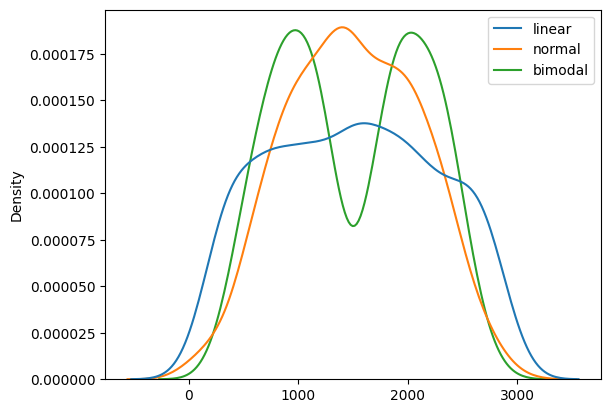

In [ ]:
sns.kdeplot({"linear" : sim_listwise_rounds_linear["elo_scores"].values(), "normal" : sim_listwise_rounds_normal["elo_scores"].values(), "bimodal" : sim_listwise_rounds_bimodal["elo_scores"].values()})

Listwise rounds:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s]


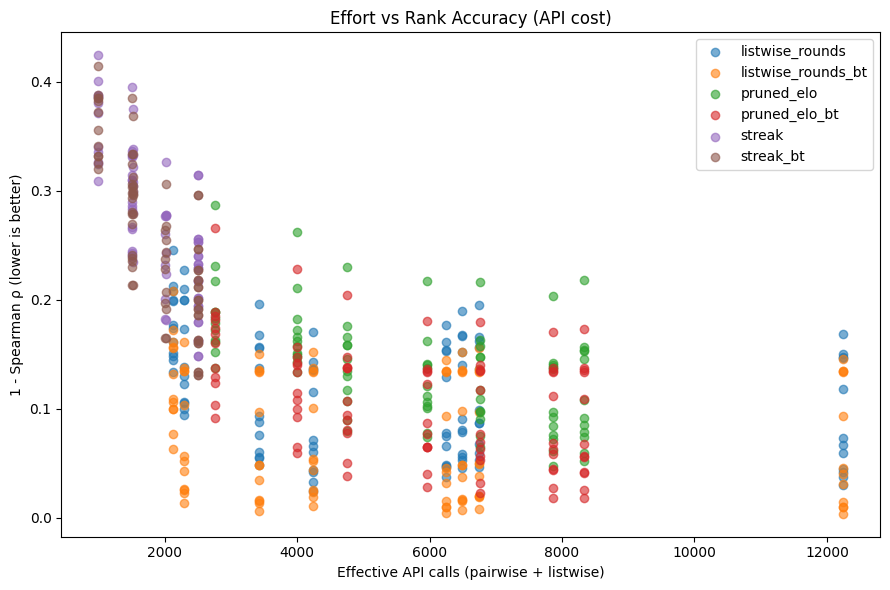

In [ ]:
# for Bradley Terry:
# =============== Your custom grids ===============

# 1) Streak
streak_grid = [
    # slightly cheaper, tighter window
    dict(initial_elo=1500, k_factor=24, r=3, min_distinct_opponents=3,
         max_epochs=18, opponent_selection="similar", randomness_factor=0.05, seed=11),
    # more conservative decision threshold
    dict(initial_elo=1500, k_factor=32, r=4, min_distinct_opponents=4,
         max_epochs=24, opponent_selection="similar", randomness_factor=0.10, seed=11),
    # more randomness, can escape local traps
    dict(initial_elo=1500, k_factor=24, r=3, min_distinct_opponents=3,
         max_epochs=18, opponent_selection="similar", randomness_factor=0.30, seed=11),
    # aggressive early-stop for triage
    dict(initial_elo=1500, k_factor=32, r=2, min_distinct_opponents=2,
         max_epochs=12, opponent_selection="similar", randomness_factor=0.10, seed=11),
     # many rounds, hard  streak limit
    dict(initial_elo=1500, k_factor=32, r=5, min_distinct_opponents=4,
         max_epochs=24, opponent_selection="similar", randomness_factor=0.10, seed=11),
    # stricter early-stop (higher quality, more compute)
    dict(initial_elo=1500, k_factor=32, r=5, min_distinct_opponents=4,
         max_epochs=30, opponent_selection="similar", randomness_factor=0.10, seed=11),
]

# 2) Pruned Elo
pruned_base = dict(initial_elo=1500, k_factor=32, n_rounds=24,
                   match_strategy="similar", randomness_factor=0.10, seed=11)
pruned_grid = make_grid(
    pruned_base,
    prune_start_round=[4, 8, 12],
    prune_percent=[0.10, 0.20]
) + [
    # stronger prune late
    dict(pruned_base, prune_start_round=16, prune_percent=0.30),
]

# 3) Listwise rounds
listwise_grid = [
    dict(initial_elo=1500, k_factor=32, n_rounds=2, k=10, overlap=3,
         boundary_passes=1, grouping_strategy="similar", randomness_factor=0.10),
    # 3 rounds
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=10, overlap=3,
         boundary_passes=1, grouping_strategy="similar", randomness_factor=0.10),
    # larger lists, more boundaries
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=15, overlap=3,
         boundary_passes=2, grouping_strategy="similar", randomness_factor=0.10),
     # larger lists, even more boundaries
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=15, overlap=3,
         boundary_passes=4, grouping_strategy="similar", randomness_factor=0.10),
    # smaller lists, more boundaries
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=8, overlap=2,
         boundary_passes=2, grouping_strategy="similar", randomness_factor=0.10),
    # even smaller lists, more boundaries
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=6, overlap=2,
         boundary_passes=2, grouping_strategy="similar", randomness_factor=0.10),
    # random grouping, 2 stitching passes
    dict(initial_elo=1500, k_factor=32, n_rounds=2, k=12, overlap=4,
         boundary_passes=2, grouping_strategy="random", randomness_factor=0.20),
    # same but with a call budget (keeps cost bounded)
    dict(initial_elo=1500, k_factor=32, n_rounds=2, k=10, overlap=3,
         boundary_passes=2, grouping_strategy="similar", randomness_factor=0.10,
         listwise_call_budget=120)  # adjust as needed
]

# 4) Hybrid
hybrid_grid = [
    # light listwise + mild streak + mild prune
    # dict(initial_elo=1500, k_factor=32,
    #      listwise_n_rounds=1, k=10, overlap=3, boundary_passes=1,
    #      grouping_strategy="similar", randomness_factor=0.10,
    #      streak_r=3, streak_min_distinct=3, streak_epochs=6,
    #      prune_rounds=6, prune_percent=0.15,
    #      listwise_groups_limit=None, listwise_call_budget=None,
    #      pairwise_call_budget=None),
    # # 2 listwise rounds, stronger prune
    # dict(initial_elo=1500, k_factor=32,
    #      listwise_n_rounds=2, k=10, overlap=3, boundary_passes=1,
    #      grouping_strategy="similar", randomness_factor=0.10,
    #      streak_r=3, streak_min_distinct=3, streak_epochs=6,
    #      prune_rounds=8, prune_percent=0.20),
    # # smaller k, more stitching, then short streak, light prune
    # dict(initial_elo=1500, k_factor=32,
    #      listwise_n_rounds=2, k=8, overlap=2, boundary_passes=2,
    #      grouping_strategy="similar", randomness_factor=0.10,
    #      streak_r=3, streak_min_distinct=3, streak_epochs=5,
    #      prune_rounds=6, prune_percent=0.10),
    # # random grouping to diversify, tighter streak decision
    # dict(initial_elo=1500, k_factor=32,
    #      listwise_n_rounds=2, k=12, overlap=4, boundary_passes=1,
    #      grouping_strategy="random", randomness_factor=0.20,
    #      streak_r=4, streak_min_distinct=3, streak_epochs=8,
    #      prune_rounds=6, prune_percent=0.15),
    #  # high variance similar grouping to diversify, tighter streak decision
    # dict(initial_elo=1500, k_factor=32,
    #      listwise_n_rounds=2, k=12, overlap=4, boundary_passes=1,
    #      grouping_strategy="similar", randomness_factor=0.30,
    #      streak_r=4, streak_min_distinct=3, streak_epochs=8,
    #      prune_rounds=4, prune_percent=0.2),
    # # explicit budgets (cap listwise and pairwise calls)
    # dict(initial_elo=1500, k_factor=32,
    #      listwise_n_rounds=2, k=10, overlap=3, boundary_passes=1,
    #      grouping_strategy="similar", randomness_factor=0.10,
    #      streak_r=3, streak_min_distinct=3, streak_epochs=8,
    #      prune_rounds=8, prune_percent=0.20,
    #      listwise_call_budget=140, pairwise_call_budget=6000),
]

### SETUP

datasets = [
    DatasetConfig(n=1000, distribution="linear",  seed=1),
    DatasetConfig(n=1000, distribution="bimodal", seed=2),
    DatasetConfig(n=1000, distribution="normal",  seed=3),
    DatasetConfig(n=1000, distribution="binary",  seed=4),
]
noise = NoiseConfig(pmax=0.99, calib_diff=90.0, calib_target=0.80, tie_prob=0.0, scale=1000)

bench = BenchmarkConfig(
    datasets=datasets,
    bias_sizes=[0, 50, 200],
    bias_delta=200.0,         # applied as ±delta (comparator-only)
    noise=noise,
    seeds=[111],
    streak_grid=streak_grid,
    pruned_grid=pruned_grid,
    listwise_grid=listwise_grid,
    hybrid_grid=hybrid_grid,
    bt_posthoc=True,          # <- add BT rows like "streak_bt"
    bt_per_round=False,       # <- set True to attach per-round BT Spearman curve
    out_dir="sim_outputs",
)

df = run_benchmark(bench)

# Same cost fix
df["effective_calls_api"] = (df["pairwise_calls"] - df["pairwise_calls_internal"]).clip(lower=0) + df["listwise_calls"]


In [ ]:
with open ("/simulation_large_withBT.pkl", "rb") as f:
  df = pickle.load(f)

In [ ]:
df_params

initial_elo  k_factor    r  min_distinct_opponents  max_epochs  \
0            1500        32  3.0                     3.0        24.0   
1            1500        32  3.0                     3.0        24.0   
2            1500        32  4.0                     3.0        24.0   
3            1500        32  4.0                     3.0        24.0   
4            1500        32  5.0                     3.0        24.0   
...           ...       ...  ...                     ...         ...   
1051         1500        32  NaN                     NaN         NaN   
1052         1500        32  NaN                     NaN         NaN   
1053         1500        32  NaN                     NaN         NaN   
1054         1500        32  NaN                     NaN         NaN   
1055         1500        32  NaN                     NaN         NaN   

     opponent_selection  randomness_factor  seed  n_rounds match_strategy  \
0               similar                0.1  11.0       NaN            NaN   
1               similar                0.1  11.0       NaN            NaN   
2               similar                0.1  11.0       NaN            NaN   
3               similar                0.1  11.0       NaN            NaN   
4               similar                0.1  11.0       NaN            NaN   
...                 ...                ...   ...       ...            ...   
1051                NaN                0.1   NaN       1.0            NaN   
1052                NaN                0.1   NaN       2.0            NaN   
1053                NaN                0.1   NaN       2.0            NaN   
1054                NaN                0.1   NaN       3.0            NaN   
1055                NaN                0.1   NaN       3.0            NaN   

      prune_start_round  prune_percent     k  overlap  boundary_passes  \
0                   NaN            NaN   NaN      NaN              NaN   
1                   NaN            NaN   NaN      NaN              NaN   
2                   NaN            NaN   NaN      NaN              NaN   
3                   NaN            NaN   NaN      NaN              NaN   
4                   NaN            NaN   NaN      NaN              NaN   
...                 ...            ...   ...      ...              ...   
1051                NaN            NaN  10.0      2.0              0.0   
1052                NaN            NaN  10.0      2.0              0.0   
1053                NaN            NaN  10.0      2.0              0.0   
1054                NaN            NaN  10.0      2.0              0.0   
1055                NaN            NaN  10.0      2.0              0.0   

     grouping_strategy  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
1051           similar  
1052           similar  
1053           similar  
1054           similar  
1055           similar  

[1056 rows x 16 columns]

In [ ]:
df.method.unique()

array(['streak', 'streak_bt', 'pruned_elo', 'pruned_elo_bt',
       'listwise_rounds', 'listwise_rounds_bt'], dtype=object)

In [ ]:
df["pairwise_api_calls"] = (df["pairwise_calls"] - df["inferred_pairs"].fillna(0).astype(int)).clip(lower=0)
df["effective_calls_api"] = df["pairwise_api_calls"] + df["listwise_calls"]

# columns
check_col = "method"   # where we check for 'listwise_rounds' / 'listwise_rounds_bt'
dict_col  = "params"       # column that holds dicts
val_col   = "effective_calls_api"      # column to scale
key_name  = "k"

# 1) rows that should be considered (by type/category)
mask_type = df[check_col].isin(["listwise_rounds", "listwise_rounds_bt"])

# 2) extract the key from the dict column (NaN if not a dict or key missing)
k_series = df[dict_col].apply(lambda d: d.get(key_name) if isinstance(d, dict) and (key_name in d) else np.nan)

# 3) only update rows where both conditions hold and the key exists
mask = mask_type & k_series.notna()

df.loc[mask, val_col] *= (k_series[mask] / 2)

#### Plots and analysis

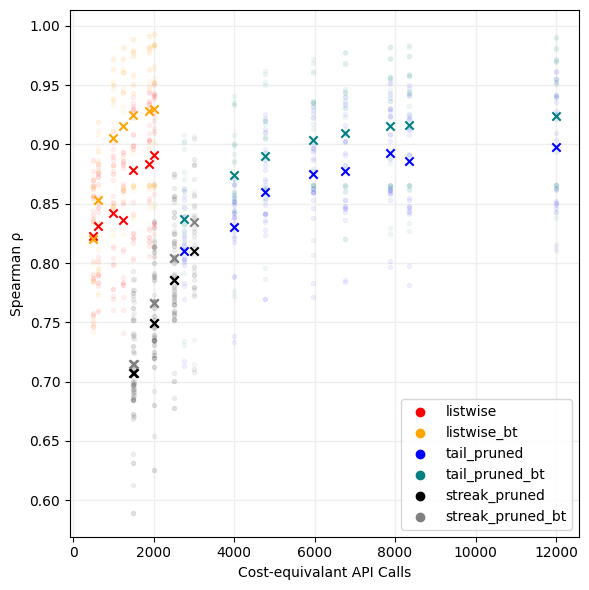

In [ ]:
# plot
labels = ['listwise', 'listwise_bt', 'tail_pruned', 'tail_pruned_bt', 'streak_pruned', 'streak_pruned_bt']
colors = ["red", "orange", "blue", "teal", "black", "gray"]
l_for_calc = {}
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.grid(color='#eeeeee', linestyle='-', linewidth=1)
plt.rcParams['axes.axisbelow'] = True
for i, m in enumerate(sorted(df["method"].astype(str).unique())):
  sub = df[df["method"] == m]
  med = sub[["effective_calls_api", "spearman"]].median()
  plt.scatter(sub["effective_calls_api"], sub["spearman"], alpha=0.05, color=colors[i], mouseover=True, marker=".")
  plt.scatter([],[], label=labels[i], color=colors[i])

for i, m in enumerate(sorted(df["method"].astype(str).unique())):
  sub = df[df["method"] == m]
  for p in sub.params.astype(str).unique():
    sub2 = sub[sub["params"].astype(str) == p]
    mean = sub2[["effective_calls_api", "spearman"]].mean()
    l_for_calc[p] = {"method": m, "effective_calls_api": mean.effective_calls_api, "spearman": mean.spearman}
    plt.scatter(mean["effective_calls_api"], mean["spearman"], alpha=1, color=colors[i], marker="x", mouseover=True)

plt.xlabel("Cost-equivalant API Calls")
plt.ylabel("Spearman ρ")
#plt.title("Effort vs Rank Correlation")
plt.legend(); plt.tight_layout()
plt.savefig("/results_simulation_large_withBT.pdf")
plt.show()

In [ ]:
df_calc = pd.DataFrame(l_for_calc).T
df_calc["spearman"] = df_calc["spearman"]

In [ ]:
m = df_calc['effective_calls_api'].min()
M = df_calc['effective_calls_api'].max()
df_calc['effective_calls_api_norm'] = 1-((df_calc['effective_calls_api'] - m) / (M - m))

m_s = df_calc['spearman'].min()
M_s = df_calc['spearman'].max()
df_calc['spearman_norm'] = (df_calc['spearman'] - m_s) / (M_s - m_s)

In [ ]:
df_calc["score"] = score_effCost(df_calc["spearman_norm"], df_calc["effective_calls_api_norm"],  0.5)

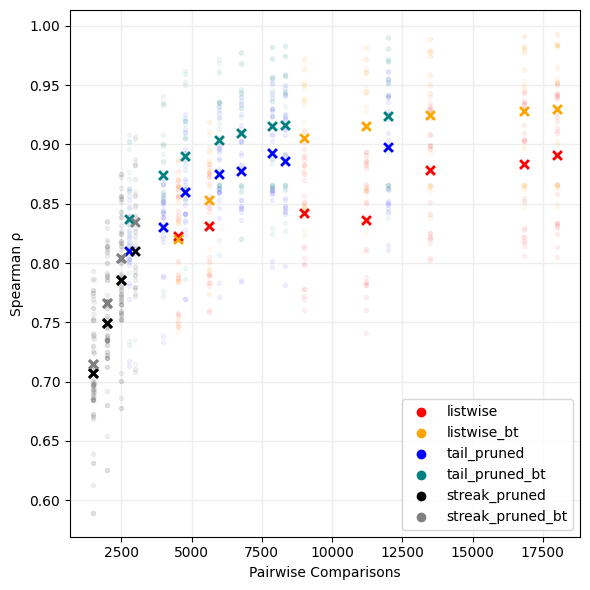

In [ ]:
# plot
labels = ['listwise', 'listwise_bt', 'tail_pruned', 'tail_pruned_bt', 'streak_pruned', 'streak_pruned_bt']
colors = ["red", "orange", "blue", "teal", "black", "gray"]
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.grid(color='#eeeeee', linestyle='-', linewidth=1)
plt.rcParams['axes.axisbelow'] = True
for i, m in enumerate(sorted(df["method"].astype(str).unique())):
  sub = df[df["method"] == m]
  med = sub[["pairwise_calls", "spearman"]].median()
  plt.scatter(sub["pairwise_calls"], sub["spearman"], alpha=0.05, color=colors[i], mouseover=True, marker=".")
  plt.scatter([],[], label=labels[i], color=colors[i])
  for i, m in enumerate(sorted(df["method"].astype(str).unique())):
    sub = df[df["method"] == m]
    for p in sub.params.astype(str).unique():
      sub2 = sub[sub["params"].astype(str) == p]
      mean = sub2[["pairwise_calls", "spearman"]].mean()
      plt.scatter(mean["pairwise_calls"], mean["spearman"], alpha=1, color=colors[i], marker="x", mouseover=True)
      plt.xlabel("Pairwise Comparisons")
plt.ylabel("Spearman ρ")
#plt.title("Effort vs Rank Correlation")
plt.legend(); plt.tight_layout()
plt.savefig("/results_simulation_large_withBT_PC.pdf")
plt.show()

In [ ]:
display(df.groupby("method")[["pairwise_calls","pairwise_calls_internal","pairwise_api_calls","listwise_calls","effective_calls_api"]].mean().round(2))


pairwise_calls  pairwise_calls_internal  \
method                                                        
listwise_rounds           11235.43                 11235.43   
listwise_rounds_bt        11235.43                 11235.43   
pruned_elo                 6555.75                     0.00   
pruned_elo_bt              6555.75                     0.00   
streak                     2144.02                     0.00   
streak_bt                  2144.02                     0.00   

                    pairwise_api_calls  listwise_calls  effective_calls_api  
method                                                                       
listwise_rounds                   0.00           250.0               250.00  
listwise_rounds_bt                0.00           250.0               250.00  
pruned_elo                     6555.75             0.0              6555.75  
pruned_elo_bt                  6555.75             0.0              6555.75  
streak                         2144.02             0.0              2144.02  
streak_bt                      2144.02             0.0              2144.02

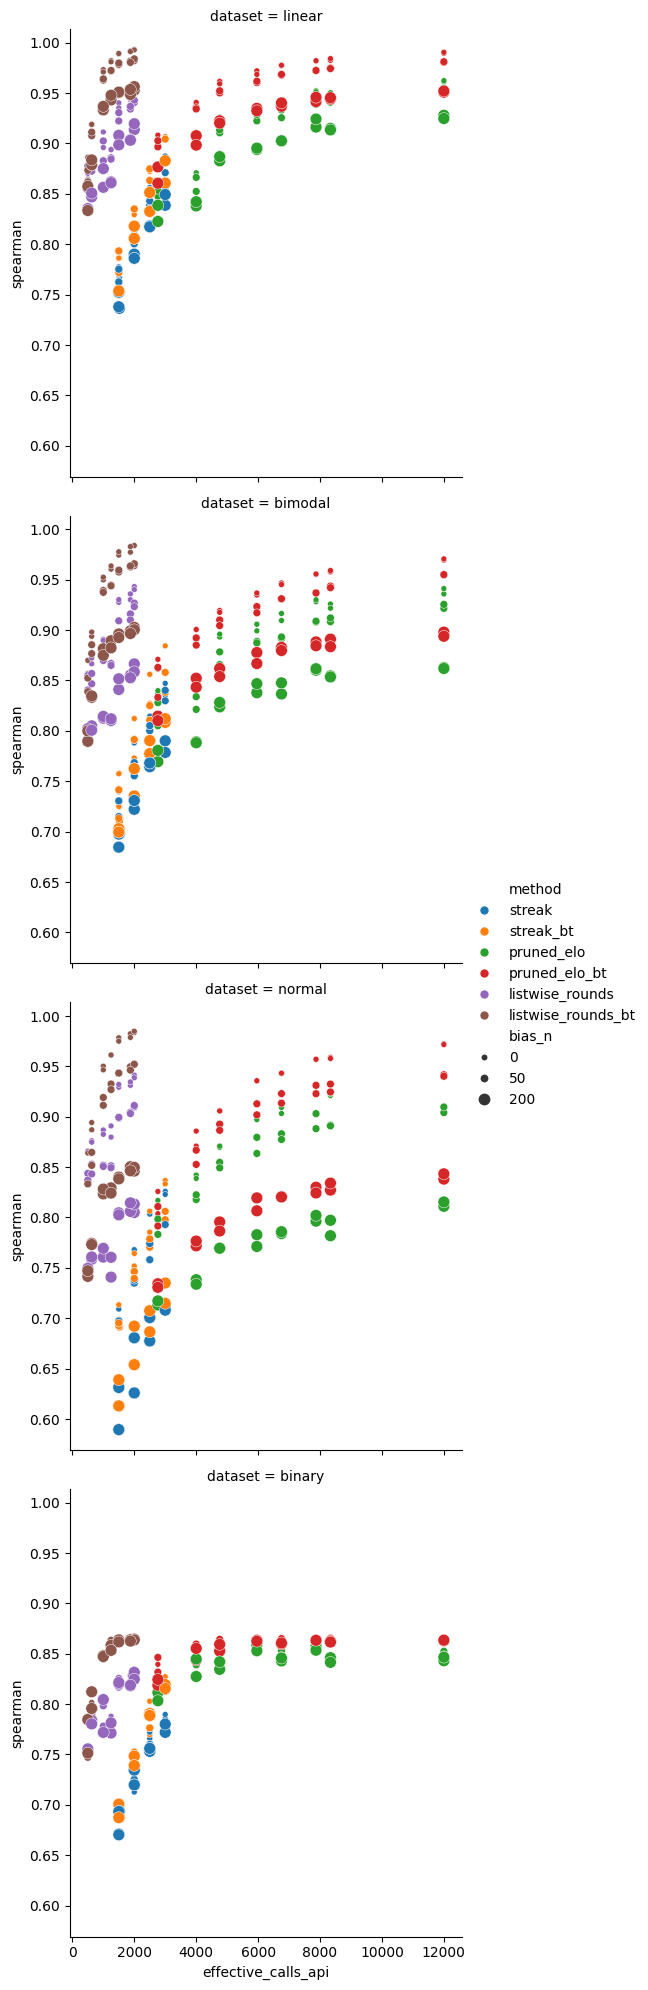

In [ ]:
sns.relplot(
    data=df, x="effective_calls_api", y="spearman",
    col="dataset", hue="method", size="bias_n",
    kind="scatter", col_wrap=1
)
plt.savefig("/simulation_by_distr_v.pdf", format='pdf')

<Axes: xlabel='pairwise_calls', ylabel='spearman'>

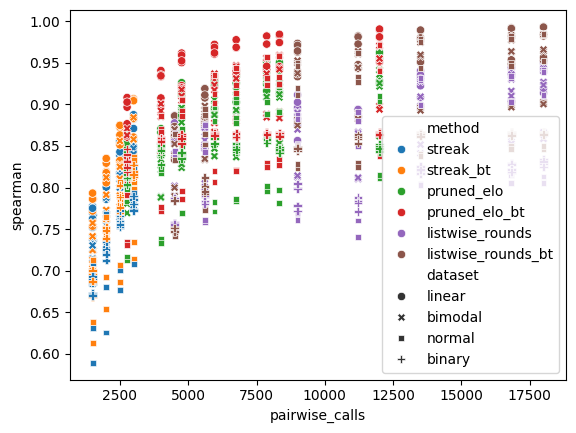

In [ ]:
sns.scatterplot(df, y="spearman", x="pairwise_calls", hue="method", style="dataset")

In [ ]:
plot_config_vs_dataset_heatmap(
    df,
    out_path="sim_outputs/config_vs_dataset_heatmap.png",
    value="error",
    sort_configs_by="method_then_error",
    calls_col="effective_calls_api",
    annotate_values=True,
    # you can tweak these down/up further:
    row_height=0.45,      # make smaller for tighter rows
    base_text_size=10,    # cell numbers
    tick_fontsize=9       # axis labels
)


Hybrid: pruned Elo rounds: 100%|██████████| 8/8 [00:00<00:00, 58.67it/s]


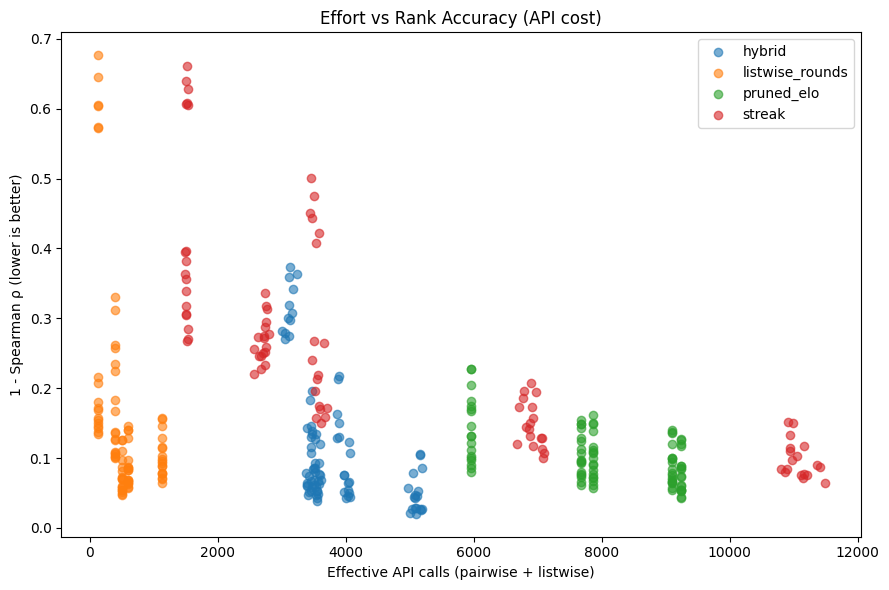

In [ ]:
# Optional: compact helper to expand a param sweep
import itertools
def make_grid(base: dict, **sweep_lists):
    keys = list(sweep_lists.keys())
    return [dict(base, **dict(zip(keys, vals)))
            for vals in itertools.product(*sweep_lists.values())]

# =============== Your custom grids ===============

# 1) Streak
streak_grid = [
    # slightly cheaper, tighter window
    dict(initial_elo=1500, k_factor=24, r=3, min_distinct_opponents=3,
         max_epochs=18, opponent_selection="similar", randomness_factor=0.05, seed=11),
    # more conservative decision threshold
    dict(initial_elo=1500, k_factor=32, r=4, min_distinct_opponents=4,
         max_epochs=24, opponent_selection="similar", randomness_factor=0.10, seed=11),
    # more randomness, can escape local traps
    dict(initial_elo=1500, k_factor=40, r=3, min_distinct_opponents=3,
         max_epochs=24, opponent_selection="random", randomness_factor=0.20, seed=11),
    # aggressive early-stop for triage
    dict(initial_elo=1500, k_factor=32, r=2, min_distinct_opponents=2,
         max_epochs=12, opponent_selection="similar", randomness_factor=0.10, seed=11),
    # stricter early-stop (higher quality, more compute)
    dict(initial_elo=1500, k_factor=32, r=5, min_distinct_opponents=4,
         max_epochs=30, opponent_selection="similar", randomness_factor=0.10, seed=11),
]

# 2) Pruned Elo
pruned_base = dict(initial_elo=1500, k_factor=32, n_rounds=24,
                   match_strategy="similar", randomness_factor=0.10, seed=11)
pruned_grid = make_grid(
    pruned_base,
    prune_start_round=[8, 12],
    prune_percent=[0.10, 0.20]
) + [
    # stronger prune late
    dict(pruned_base, prune_start_round=16, prune_percent=0.30),
]

# 3) Listwise rounds
listwise_grid = [
    dict(initial_elo=1500, k_factor=32, n_rounds=2, k=10, overlap=3,
         boundary_passes=1, grouping_strategy="similar", randomness_factor=0.10),
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=10, overlap=3,
         boundary_passes=1, grouping_strategy="similar", randomness_factor=0.10),
    # smaller lists, more boundaries
    dict(initial_elo=1500, k_factor=32, n_rounds=3, k=8, overlap=2,
         boundary_passes=2, grouping_strategy="similar", randomness_factor=0.10),
    # random grouping, 2 stitching passes
    dict(initial_elo=1500, k_factor=32, n_rounds=2, k=12, overlap=4,
         boundary_passes=2, grouping_strategy="random", randomness_factor=0.20),
    # same but with a call budget (keeps cost bounded)
    dict(initial_elo=1500, k_factor=32, n_rounds=2, k=10, overlap=3,
         boundary_passes=1, grouping_strategy="similar", randomness_factor=0.10,
         listwise_call_budget=120)  # adjust as needed
]

# 4) Hybrid
hybrid_grid = [
    # light listwise + mild streak + mild prune
    dict(initial_elo=1500, k_factor=32,
         listwise_n_rounds=1, k=10, overlap=3, boundary_passes=1,
         grouping_strategy="similar", randomness_factor=0.10,
         streak_r=3, streak_min_distinct=3, streak_epochs=6,
         prune_rounds=6, prune_percent=0.15,
         listwise_groups_limit=None, listwise_call_budget=None,
         pairwise_call_budget=None),
    # 2 listwise rounds, stronger prune
    dict(initial_elo=1500, k_factor=32,
         listwise_n_rounds=2, k=10, overlap=3, boundary_passes=1,
         grouping_strategy="similar", randomness_factor=0.10,
         streak_r=3, streak_min_distinct=3, streak_epochs=6,
         prune_rounds=8, prune_percent=0.20),
    # smaller k, more stitching, then short streak, light prune
    dict(initial_elo=1500, k_factor=32,
         listwise_n_rounds=2, k=8, overlap=2, boundary_passes=2,
         grouping_strategy="similar", randomness_factor=0.10,
         streak_r=3, streak_min_distinct=3, streak_epochs=5,
         prune_rounds=6, prune_percent=0.10),
    # random grouping to diversify, tighter streak decision
    dict(initial_elo=1500, k_factor=32,
         listwise_n_rounds=2, k=12, overlap=4, boundary_passes=1,
         grouping_strategy="random", randomness_factor=0.20,
         streak_r=4, streak_min_distinct=3, streak_epochs=8,
         prune_rounds=6, prune_percent=0.15),
    # explicit budgets (cap listwise and pairwise calls)
    dict(initial_elo=1500, k_factor=32,
         listwise_n_rounds=2, k=10, overlap=3, boundary_passes=1,
         grouping_strategy="similar", randomness_factor=0.10,
         streak_r=3, streak_min_distinct=3, streak_epochs=8,
         prune_rounds=8, prune_percent=0.20,
         listwise_call_budget=140, pairwise_call_budget=6000),
]

# =============== Build & run the benchmark ===============
datasets = [
    DatasetConfig(n=1000, distribution="linear", seed=1),
    DatasetConfig(n=1000, distribution="bimodal", seed=2),
    DatasetConfig(n=1000, distribution="normal", seed=3),
]
noise = NoiseConfig(pmax=0.99, calib_diff=90.0, calib_target=0.80, tie_prob=0.0, scale=1000)

bench = BenchmarkConfig(
    datasets=datasets,
    bias_sizes=[0, 50, 150],   # 0 disables injected system bias
    bias_delta=200.0,
    noise=noise,
    seeds=(111, 222),          # more seeds -> more vertical spread
    streak_grid=streak_grid,
    pruned_grid=pruned_grid,
    listwise_grid=listwise_grid,
    hybrid_grid=hybrid_grid,
    out_dir="sim_outputs"
)

res = run_benchmark(bench)

# =============== Correct the cost metric (API calls) ===============
import pandas as pd
df = res.copy()
df["pairwise_api_calls"] = (df["pairwise_calls"] - df["inferred_pairs"].fillna(0).astype(int)).clip(lower=0)
df["effective_calls_api"] = df["pairwise_api_calls"] + df["listwise_calls"]

# Quick plot with corrected cost
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
for m in sorted(df["method"].unique()):
    sub = df[df["method"] == m]
    plt.scatter(sub["effective_calls_api"], 1 - sub["spearman"], alpha=0.6, label=m)
plt.xlabel("Effective API calls (pairwise + listwise)")
plt.ylabel("1 - Spearman ρ (lower is better)")
plt.title("Effort vs Rank Accuracy (API cost)")
plt.legend(); plt.tight_layout(); plt.show()

# Optional: save summary
df.to_csv("sim_outputs/benchmark_summary_custom.csv", index=False)

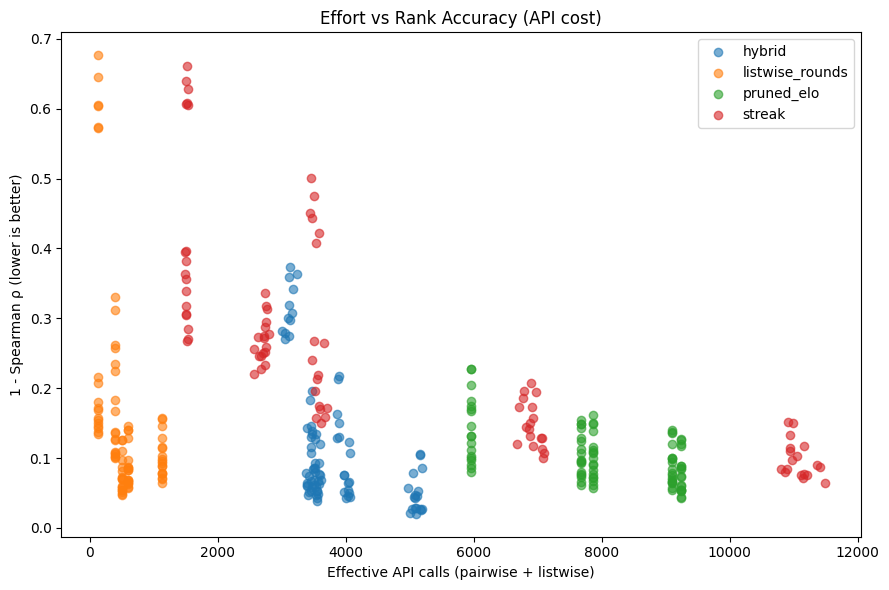

In [ ]:
df = res.copy()
df["pairwise_api_calls"] = (df["pairwise_calls"] - df["inferred_pairs"].fillna(0).astype(int)).clip(lower=0)
df["effective_calls_api"] = df["pairwise_api_calls"] + df["listwise_calls"]

# Quick plot with corrected cost
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
for m in sorted(df["method"].unique()):
    sub = df[df["method"] == m]
    plt.scatter(sub["effective_calls_api"], 1 - sub["spearman"], alpha=0.6, label=m)
plt.xlabel("Effective API calls (pairwise + listwise)")
plt.ylabel("1 - Spearman ρ (lower is better)")
plt.title("Effort vs Rank Accuracy (API cost)")
plt.legend(); plt.tight_layout(); plt.show()


### heatmap plot

In [ ]:
import ast, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib import patheffects as pe
from matplotlib.gridspec import GridSpec
from pathlib import Path

# ---------- helpers ----------
def _coerce_params(x):
    if isinstance(x, dict): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            return v if isinstance(v, dict) else {"value": v}
        except Exception:
            return {"value": x}
    if x is None or (isinstance(x, float) and math.isnan(x)): return {}
    return {"value": x}

METHOD_ALIAS = {"pruned_elo":"pruned", "listwise_rounds":"listwise", "streak":"streak", "hybrid":"hybrid"}

SHORT_KEYS = {
    "grouping_strategy":"grouping",
    "opponent_selection":"opp.sel",
    "min_distinct_opponents":"opp.min",
    "streak_min_distinct":"opp.min",
    "streak_r":"r",
    "r":"r",
    "streak_epochs":"epochs",
    "max_epochs":"epochs",
    "n_rounds":"rounds",
    "listwise_n_rounds":"lw.rounds",
    "boundary_passes":"boundary",
    "overlap":"overlap",
    "k":"k",
    "k_factor":"k",
    "randomness_factor":"rand",
    "match_strategy":"match",
    "prune_start_round":"prune.start",
    "prune_rounds":"prune.rounds",
    "prune_percent":"prune%",
    "listwise_call_budget":"lw.budget",
    "pairwise_call_budget":"pw.budget",
}
EXCLUDE_KEYS = {"initial_elo", "seed"}

def _fmt_val(v):
    if isinstance(v, float): return f"{v:.3g}"
    return str(v)

def _param_line_short(params: dict) -> str:
    p = _coerce_params(params)
    parts = []
    for k, v in p.items():
        if k in EXCLUDE_KEYS: continue
        sk = SHORT_KEYS.get(k, k)
        parts.append(f"{sk}={_fmt_val(v)}")
    return ", ".join(parts)

def _config_sig(method: str, params: dict):
    p = _coerce_params(params)
    return (method, tuple(sorted((k, None if p.get(k) is None else p.get(k)) for k in p.keys())))

def _luminance(rgb):
    r,g,b = rgb[:3]; return 0.2126*r + 0.7152*g + 0.0722*b

# ===== robust instance discovery (NO tuple dict keys; ignores 'seed' for lettering) =====
def _discover_dataset_instances(df: pd.DataFrame, instance_cols=None):
    """
    Discover dataset 'instances' within each distribution (e.g., multiple binaries with different ratios).
    Letters (_a, _b, …) are added ONLY if a distribution has >1 instance.
    Instances are defined by 'instance_cols' (defaults to present subset of ['dataset','scale_max','scale_min']).
    Returns:
      df_out: original df with ['dataset_tag','dataset_cfg','dataset_letter_idx'] added
      dataset_legend_text: formatted legend text summarizing per-tag seeds/biases/etc.
    """
    if instance_cols is None:
        instance_cols = ["dataset"]
        if "scale_max" in df.columns: instance_cols.append("scale_max")
        if "scale_min" in df.columns: instance_cols.append("scale_min")

    # Unique instances by instance_cols (ignore seed/bias for instance identity)
    inst_df = df.drop_duplicates(instance_cols).copy()

    # Count instances per distribution
    counts = inst_df.groupby("dataset").size()

    # Assign letters per distribution only if multiple instances exist
    inst_df["_letter"] = ""
    for dataset, sub_idx in inst_df.groupby("dataset").groups.items():
        idxs = list(sub_idx)
        if counts.loc[dataset] > 1:
            # Sort by remaining instance columns for determinism (except 'dataset' itself)
            sort_cols = [c for c in instance_cols if c != "dataset"]
            if sort_cols:
                idxs = inst_df.loc[idxs].sort_values(sort_cols).index.tolist()
            for i, row_idx in enumerate(idxs):
                inst_df.at[row_idx, "_letter"] = chr(ord('a') + i)

    # Build tag (with or without letter)
    inst_df["_tag"] = inst_df.apply(
        lambda r: f"{r['dataset']}_{r['_letter']}" if r["_letter"] else f"{r['dataset']}", axis=1
    )

    # Merge back to original df to assign tag
    df_out = df.merge(inst_df[instance_cols + ["_tag", "_letter"]], on=instance_cols, how="left")
    df_out.rename(columns={"_tag": "dataset_tag"}, inplace=True)

    # Letter index for ordering ('' -> 0, 'a'->1, 'b'->2, …)
    def _letter_idx(letter: str) -> int:
        if not letter: return 0
        return ord(letter) - ord('a') + 1
    df_out["dataset_letter_idx"] = df_out["_letter"].apply(_letter_idx)

    # Build x-axis label (dataset_tag + bias + optional Δ)
    def _col_label(r):
        base = f"{r['dataset_tag']} | bias = {int(r['bias_n'])}"
        if ("bias_delta" in r) and pd.notna(r["bias_delta"]):
            # We can choose to show Δ on axis or keep legend only; axis gets busy quickly.
            # Keep axis clean: comment next line in if you want it there.
            # base += f" (Δ={int(r['bias_delta'])})"
            pass
        return base
    df_out["dataset_cfg"] = df_out.apply(_col_label, axis=1)

    # Build dataset legend lines (one per dataset_tag)
    legend_lines = []
    for tag, sub in df_out.groupby("dataset_tag"):
        seed_txt = "—"
        if "seed" in sub.columns:
            seeds = sorted(int(s) for s in pd.Series(sub["seed"]).dropna().unique())
            if seeds: seed_txt = ",".join(map(str, seeds))
        biases = sorted(int(b) for b in sub["bias_n"].dropna().unique())
        line = f"{tag}: seed={seed_txt}; biases=[{', '.join(map(str,biases))}]"
        if "bias_delta" in sub.columns and pd.notna(sub["bias_delta"]).any():
            deltas = sorted(int(x) for x in pd.Series(sub["bias_delta"]).dropna().unique())
            if len(deltas) == 1:
                line += f"; Δ={deltas[0]}"
            elif len(deltas) > 1:
                line += f"; Δ∈[{', '.join(map(str, deltas))}]"
        # Include scale_max for 'binary' to expose the class ratio control
        if "scale_max" in sub.columns and pd.notna(sub["scale_max"]).any():
            sm = sorted(set(int(x) for x in pd.Series(sub["scale_max"]).dropna().unique()))
            if len(sm) == 1:
                line += f"; scale_max={sm[0]}"
            elif len(sm) > 1:
                line += f"; scale_max∈[{', '.join(map(str, sm))}]"
        legend_lines.append(line)
    dataset_legend_text = "\n".join(sorted(legend_lines))
    return df_out, dataset_legend_text

# ---------- main plot ----------
def plot_config_vs_dataset_heatmap(
    res_df: pd.DataFrame,
    out_path: str = "sim_outputs/config_vs_dataset_heatmap.png",
    include_bias_delta_in_x: bool = False,   # kept for compatibility (Δ now shown in legend)
    value: str = "error",                 # "error" (white good) or "spearman"
    sort_configs_by: str = "method_then_error",
    calls_col: str = "effective_calls_api",
    annotate_values: bool = True,
    base_text_size: int = 10,
    tick_fontsize: int = 9,
    row_height: float = 0.45,
    width_scale: float = 1.30,
    info_box_wrap: int = 110,
    instance_cols=None,
):
    df = res_df.copy()
    df["params"] = df["params"].apply(_coerce_params)

    # cost fallback if needed
    if calls_col not in df.columns:
        if "pairwise_calls_internal" in df.columns:
            pairwise_api = (df["pairwise_calls"] - df["pairwise_calls_internal"]).clip(lower=0)
        else:
            # legacy fallback: subtract inferred_pairs if present
            inferred = df["inferred_pairs"] if "inferred_pairs" in df.columns else 0
            pairwise_api = (df["pairwise_calls"] - inferred).clip(lower=0)
        df[calls_col] = pairwise_api + df["listwise_calls"]

    df["error"] = 1.0 - df["spearman"]
    if ("dataset" not in df.columns) or ("bias_n" not in df.columns):
        raise ValueError("Expected 'dataset' and 'bias_n' columns.")

    # Discover instances and build tags/labels
    df, dataset_legend_text = _discover_dataset_instances(df, instance_cols=instance_cols)

    # Config signatures
    df["config_sig"] = df.apply(lambda r: _config_sig(r["method"], r["params"]), axis=1)
    reps = df.groupby("config_sig")[["method","params"]].apply(lambda g: g.iloc[0]).reset_index()
    sig_to_method = dict(zip(reps["config_sig"], reps["method"]))
    sig_to_params = dict(zip(reps["config_sig"], reps["params"]))
    sig_to_alias  = {sig: METHOD_ALIAS.get(m, m) for sig, m in sig_to_method.items()}

    # Aggregate
    agg = (df.groupby(["config_sig","dataset_cfg"])
             .agg(error=("error","mean"),
                  spearman=("spearman","mean"),
                  calls=(calls_col,"mean"))
             .reset_index())

    per_cfg = (agg.groupby("config_sig")
                .agg(mean_error=("error","mean"),
                     mean_spearman=("spearman","mean"),
                     mean_calls=("calls","mean"))
                .reset_index())
    per_cfg["method"] = per_cfg["config_sig"].map(sig_to_method)
    per_cfg["alias"]  = per_cfg["config_sig"].map(sig_to_alias)

    # Row labels: method_letter [mean_calls]
    label_map = {}
    for m, sub in per_cfg.groupby("method"):
        sub = sub.sort_values("mean_calls")
        for i, (_, r) in enumerate(sub.iterrows()):
            letter = chr(ord('a') + i)
            label_map[r["config_sig"]] = f"{METHOD_ALIAS.get(m,m)}_{letter} [{int(round(r['mean_calls']))}]"

    if sort_configs_by == "calls":
        row_order = per_cfg.sort_values(["mean_calls","mean_error"])["config_sig"].tolist()
    elif sort_configs_by == "method_then_error":
        row_order = per_cfg.sort_values(["method","mean_error","mean_calls"])["config_sig"].tolist()
    else:
        row_order = per_cfg.sort_values(["mean_error","mean_calls"])["config_sig"].tolist()

    # Column ordering: distribution → instance letter index → bias
    def _dist_from_tag(tag: str) -> str: return tag.split("_",1)[0]
    def _letter_idx_from_tag(tag: str) -> int:
        parts = tag.split("_",1)
        if len(parts) == 1 or not parts[1]: return 0
        return ord(parts[1]) - ord('a') + 1

    xmeta = df.drop_duplicates(["dataset_cfg","dataset_tag","bias_n"]).copy()
    xmeta["dist"] = xmeta["dataset_tag"].map(_dist_from_tag)
    xmeta["letter_idx"] = xmeta["dataset_tag"].map(_letter_idx_from_tag)
    dist_order = ["linear","bimodal","normal","binary"]
    xmeta["dist"] = pd.Categorical(xmeta["dist"], dist_order, ordered=True)
    xmeta = xmeta.sort_values(["dist","letter_idx","bias_n"])
    col_order = xmeta["dataset_cfg"].tolist()

    val_col = "error" if value == "error" else "spearman"
    M = (agg.pivot(index="config_sig", columns="dataset_cfg", values=val_col)
           .reindex(index=row_order, columns=col_order))

    row_labels = [label_map[s] for s in M.index]
    col_labels = M.columns.tolist()

    # ---- figure layout: heatmap + config box + dataset legend ----
    H_rows = max(6.0, row_height * len(row_labels))
    W_cols = max(8.0, width_scale * 0.8 * len(col_labels))
    info_h_cfg = max(2.0, min(6.0, 0.10 * len(row_labels)))
    info_h_ds  = max(1.5, min(5.0, 0.06 * max(8, len(col_labels))))

    fig = plt.figure(figsize=(W_cols, H_rows + info_h_cfg + info_h_ds))
    gs = GridSpec(nrows=3, ncols=1, height_ratios=[H_rows, info_h_cfg, info_h_ds], figure=fig)
    ax = fig.add_subplot(gs[0])
    ax_info = fig.add_subplot(gs[1]); ax_info.axis("off")
    ax_info_ds = fig.add_subplot(gs[2]); ax_info_ds.axis("off")

    cmap = get_cmap("Reds")
    if value == "error":
        im_data = M.values
        vmin, vmax = 0.0, float(np.nanpercentile(im_data, 95))
        cbar_label = "1 − Spearman ρ (lower is better)"
        descending = False
    else:
        im_data = 1.0 - M.values
        vmin, vmax = 0.0, float(np.nanpercentile(im_data, 95))
        cbar_label = "Spearman ρ (higher is better)"
        descending = True

    norm = Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(im_data, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm, zorder=0)

    ax.set_yticks(np.arange(len(row_labels))); ax.set_yticklabels(row_labels, fontsize=tick_fontsize)
    ax.set_xticks(np.arange(len(col_labels))); ax.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=tick_fontsize)

    ax.set_xticks(np.arange(-.5, len(col_labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(row_labels), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.3, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)

    cbar = fig.colorbar(im, ax=ax, pad=0.012)
    cbar.set_label(cbar_label, fontsize=tick_fontsize)

    # annotate values
    if annotate_values:
        vals = M.values
        Nrows, Ncols = vals.shape
        text_size = max(8, min(13, int(base_text_size + 40 / max(1, max(Nrows, Ncols)))))
        fmt = "{:.2f}"
        top5 = np.zeros_like(vals, dtype=bool)
        top1 = np.zeros_like(vals, dtype=bool)
        for j in range(Ncols):
            col = vals[:, j]
            idx = np.where(~np.isnan(col))[0]
            if not len(idx): continue
            order = idx[np.argsort(col[idx])]
            if descending: order = order[::-1]
            top_k = order[:min(5, len(order))]
            top5[top_k, j] = True
            top1[order[0], j] = True

        for i in range(Nrows):
            for j in range(Ncols):
                v = vals[i, j]
                if np.isnan(v): continue
                rgba = cmap(norm(im_data[i, j]))
                txt_col = "black" if _luminance(rgba) > 0.6 else "white"
                t = ax.text(j, i, fmt.format(v), ha="center", va="center",
                            fontsize=text_size, color=txt_col, zorder=5)
                t.set_path_effects([pe.withStroke(linewidth=1.2, foreground=("white" if txt_col=="black" else "black"))])
                if top5[i, j]:
                    t.set_fontweight("bold")
                if top1[i, j]:
                    try:
                        t.set_underline(True)
                    except Exception:
                        ax.plot([j-0.35, j+0.35], [i+0.35, i+0.35],
                                color=txt_col, linewidth=1.3, zorder=6)

    ax.set_title("Model configuration × Dataset configuration — ranking quality", pad=8, fontsize=11)

    # config info box
    lines_cfg = []
    for sig in M.index:
        label = f"{METHOD_ALIAS.get(sig_to_method[sig], sig_to_method[sig])}_{chr(ord('a') + list(per_cfg[per_cfg['method']==sig_to_method[sig]].sort_values('mean_calls').index).index(per_cfg[per_cfg['config_sig']==sig].index[0])) if False else ''}"
        # simpler: keep your prior mapping
        label = [f for f in (label_map.get(sig),) if f][0]
        line = f"{label}: " + _param_line_short(sig_to_params[sig])
        lines_cfg.append(textwrap.fill(line, width=info_box_wrap, subsequent_indent="    "))
    ax_info.text(
        0.0, 1.0, "\n".join(lines_cfg), transform=ax_info.transAxes,
        ha="left", va="top", family="monospace", fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.95, pad=0.6)
    )

    # dataset legend box
    ax_info_ds.text(
        0.0, 1.0, dataset_legend_text, transform=ax_info_ds.transAxes,
        ha="left", va="top", family="monospace", fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.95, pad=0.6)
    )

    fig.tight_layout()
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=240)
    plt.savefig("/config_vs_dataset_heatmap.pdf")
    plt.show()


/tmp/ipython-input-2051343305.py:262: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Reds")


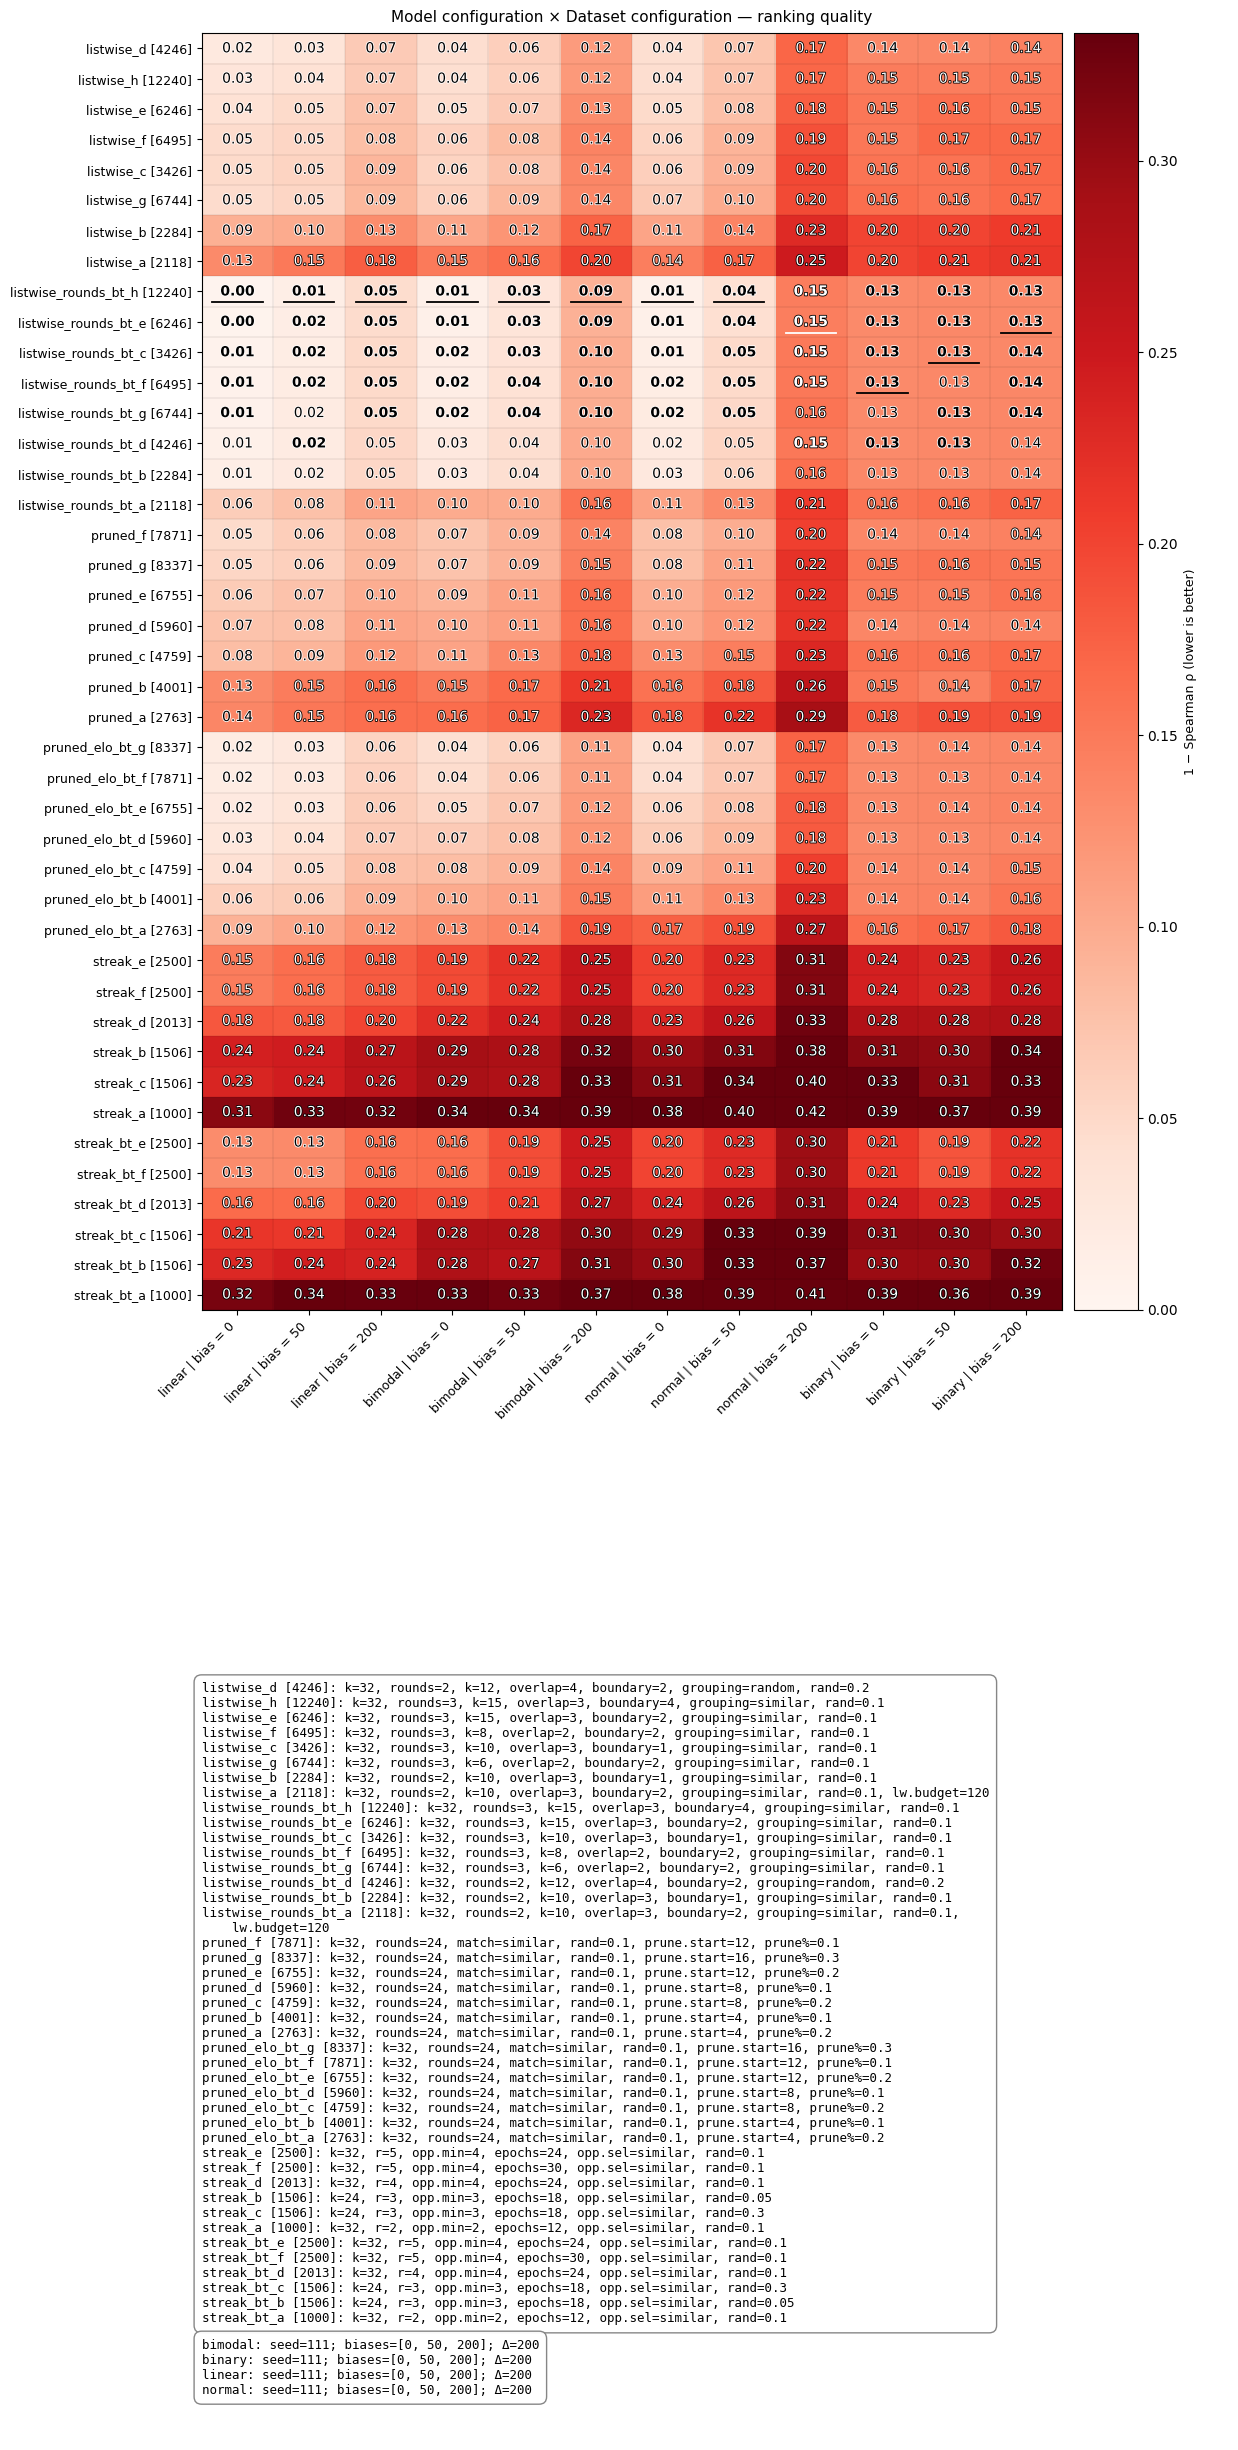

In [ ]:
plot_config_vs_dataset_heatmap(
    df,
    out_path="sim_outputs/config_vs_dataset_heatmap.png",
    value="error",
    sort_configs_by="method_then_error",
    calls_col="effective_calls_api",
    annotate_values=True,
    # you can tweak these down/up further:
    row_height=0.45,      # make smaller for tighter rows
    base_text_size=10,    # cell numbers
    tick_fontsize=9       # axis labels
)



# Evaluation of Bias Detection and Quatification

## BABE dataset

In [ ]:
df_babe = pd.read_excel("/BABE/final_labels_SG2.xlsx")
df_babe_annotated = pd.read_csv("/BABE/df_babe.csv")
df_babe_raw = pd.read_excel("/BABE/raw_labels_SG2.xlsx")

In [ ]:
df_babe

text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3669  You’ve heard of Jim Crow and Southern Segregat...   
3670  Young female athletes’ dreams and accomplishme...   
3671  Young white men, reacting to social and educat...   
3672  Young women taking part in high school and col...   
3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3669  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3670  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3671  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3672                                                NaN   Breitbart   
3673  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  \
0           environment   right  Non-biased   
1           gun control    left      Biased   
2     white-nationalism    left      Biased   
3     white-nationalism    left      Biased   
4     marriage-equality     NaN      Biased   
...                 ...     ...         ...   
3669  marriage-equality     NaN      Biased   
3670  marriage-equality     NaN      Biased   
3671  white-nationalism   right      Biased   
3672              sport   right      Biased   
3673     elections-2020  center      Biased   

                              label_opinion  \
0                          Entirely factual   
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
...                                     ...   
3669             Expresses writer’s opinion   
3670             Expresses writer’s opinion   
3671             Expresses writer’s opinion   
3672  Somewhat factual but also opinionated   
3673                       Entirely factual   

                            biased_words  
0                                     []  
1      ['bizarre', 'characteristically']  
2     ['criminals', 'fringe', 'extreme']  
3                                     []  
4                               ['cult']  
...                                  ...  
3669                             ['ALL']  
3670            ['dashed', '"identify"']  
3671                   ['evil', 'white']  
3672            ['dashed', '"identify"']  
3673                      ['birtherism']  

[3674 rows x 8 columns]

In [ ]:
babe_texts = df_babe.text.to_list()

In [ ]:
df_babe[:2000].label_bias.value_counts()

label_bias
Biased        1008
Non-biased     992
Name: count, dtype: int64

#### inter-rater agreement

In [ ]:
df_babe_temp = df_babe_annotated

In [ ]:
df_babe_temp["annotator_id"] = "LLM"

In [ ]:
df_temp_bt_listwise = df_babe_temp[["text", "bt_10listwise_4rounds_elo_label"]]

In [ ]:
df_temp_bt_listwise["Label_bias_binary"] = df_temp_bt_listwise["bt_10listwise_4rounds_elo_label"].apply(lambda x: 1 if x == "biased" else 0)

/tmp/ipython-input-2405743489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_bt_listwise["Label_bias_binary"] = df_temp_bt_listwise["bt_10listwise_4rounds_elo_label"].apply(lambda x: 1 if x == "biased" else 0)


In [ ]:
df_temp_bt_listwise["annotator_id"] = "listwise_BT"

/tmp/ipython-input-2588697313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_bt_listwise["annotator_id"] = "listwise_BT"


In [ ]:
df_babe_raw["Label_bias_binary"] = pd.to_numeric(df_babe_raw["Label_bias_0-1"])
df_babe_raw = pd.concat([df_babe_raw,df_temp_bt_listwise])
df_babe_raw["annotator_id"] = df_babe_raw["annotator_id"].astype("str")

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# ---- Configure these 3 column names for your dataframe ----
ITEM_COL = 'text'
ANNOTATOR_COL = 'annotator_id'
LABEL_COL = "Label_bias_binary"
if LABEL_COL is None:
    raise ValueError("Couldn't find a label column. Set LABEL_COL to your column name.")

# Keep one annotation per (item, annotator) in case of duplicates
df_clean = (df_babe_raw
    .dropna(subset=[ITEM_COL, ANNOTATOR_COL, LABEL_COL])
    .drop_duplicates([ITEM_COL, ANNOTATOR_COL], keep='last')
)

# -------- Krippendorff's alpha (nominal) --------
def krippendorff_alpha_nominal(data, item_col, annotator_col, label_col):
    """
    Nominal Krippendorff's alpha.
    Allows different numbers of raters per item and missing data.
    """
    if data.empty:
        return np.nan

    # counts[i, c] = how many times category c was assigned to item i
    counts = (data
              .groupby([item_col, label_col])
              .size()
              .unstack(fill_value=0))

    m = counts.sum(axis=1)  # number of ratings per item
    # Only items with at least 2 ratings contribute to the observed disagreement
    valid = m >= 2
    if not valid.any():
        return np.nan

    counts_valid = counts.loc[valid]
    m_valid = m.loc[valid]

    # Observed disagreement Do = sum_i sum_c n_ic (m_i - n_ic) / sum_i m_i (m_i - 1)
    num_Do = (counts_valid.mul(m_valid, axis=0) - counts_valid.pow(2)).to_numpy().sum()
    denom_Do = (m_valid * (m_valid - 1)).sum()
    Do = num_Do / denom_Do

    # Expected disagreement De = sum_c n_c (N - n_c) / (N (N - 1))
    n_c = counts.sum(axis=0)
    N = n_c.sum()
    if N <= 1:
        return np.nan
    De = (N**2 - (n_c**2).sum()) / (N * (N - 1))

    if De == 0:
        # If all annotations are in one category, alpha is undefined; return 1 if no observed disagreement
        return float(Do == 0)

    return 1 - Do / De

alpha = krippendorff_alpha_nominal(df_clean, ITEM_COL, ANNOTATOR_COL, LABEL_COL)

# -------- Pairwise Cohen's kappa for all annotator pairs --------
def cohen_kappa_from_series(y1, y2):
    """Cohen's kappa for two aligned label series (nominal)."""
    # Ensure consistent category space
    cats = pd.Index(pd.concat([y1.astype('object'), y2.astype('object')]).unique())
    a = pd.Categorical(y1, categories=cats)
    b = pd.Categorical(y2, categories=cats)
    tab = pd.crosstab(a, b)  # confusion matrix

    n = tab.values.sum()
    if n == 0:
        return np.nan

    p_o = np.trace(tab.values) / n
    p1 = tab.sum(axis=1) / n
    p2 = tab.sum(axis=0) / n
    p_e = (p1.values * p2.values).sum()

    denom = (1 - p_e)
    if denom == 0:
        return np.nan
    return (p_o - p_e) / denom

pair_rows = []
annotators = df_clean[ANNOTATOR_COL].unique().tolist()
for a, b in combinations(sorted(annotators), 2):
    A = df_clean.loc[df_clean[ANNOTATOR_COL] == a, [ITEM_COL, LABEL_COL]]
    B = df_clean.loc[df_clean[ANNOTATOR_COL] == b, [ITEM_COL, LABEL_COL]]
    merged = A.merge(B, on=ITEM_COL, suffixes=('_a', '_b'))
    if len(merged) < 2:
        continue
    kappa = cohen_kappa_from_series(merged[f'{LABEL_COL}_a'], merged[f'{LABEL_COL}_b'])
    pair_rows.append({'annotator_a': a, 'annotator_b': b,
                      'n_overlap': len(merged), 'cohens_kappa': kappa})

pairwise_kappa = pd.DataFrame(pair_rows).sort_values(['cohens_kappa'], ascending=False)
mean_pairwise_kappa = pairwise_kappa['cohens_kappa'].mean() if not pairwise_kappa.empty else np.nan

# -------- Per-text agreement summary --------
# counts per (item, label)
counts = (df_clean
          .groupby([ITEM_COL, LABEL_COL])
          .size()
          .unstack(fill_value=0))

n_raters = counts.sum(axis=1)
max_count = counts.max(axis=1)
majority_label = counts.idxmax(axis=1)
percent_agreement = (max_count / n_raters).astype(float)
unanimous = (max_count == n_raters)

per_text_agreement = (counts
    .assign(n_raters=n_raters,
            majority_label=majority_label,
            percent_agreement=percent_agreement,
            unanimous=unanimous)
    .sort_values(['percent_agreement','n_raters'], ascending=[False, False])
)

# ---- Outputs ----
print(f"Krippendorff's alpha (nominal) across all texts: {alpha:.3f}" if pd.notna(alpha) else "Alpha could not be computed.")
print(f"Mean pairwise Cohen's kappa: {mean_pairwise_kappa:.3f}" if pd.notna(mean_pairwise_kappa) else "No pairwise kappas computed.")


Krippendorff's alpha (nominal) across all texts: 0.417
Mean pairwise Cohen's kappa: 0.407


In [ ]:
per_text_agreement_merge = per_text_agreement.to_dict()

In [ ]:
pairwise_kappa

annotator_a  annotator_b  n_overlap  cohens_kappa
14           2            5        997      0.869612
25           5  listwise_BT        999      0.741760
24           5            9        999      0.706078
19           3            5        999      0.703738
30           9  listwise_BT       3668      0.580833
26           6            9        980      0.576652
17           2            9       2684      0.574240
15           2            6          6      0.571429
18           2  listwise_BT       2683      0.558171
27           6  listwise_BT        983      0.529246
13           2            3       2683      0.509114
22           3            9       3668      0.479061
20           3            6        983      0.446147
23           3  listwise_BT       3674      0.443721
7           11            3       3654      0.434408
8           11            5        982      0.408779
11          11            9       3652      0.395432
9           11            6        983      0.373841
12          11  listwise_BT       3654      0.371308
28           7            9       1679      0.367971
21           3            7       1680      0.342420
3            1            6        977      0.294543
29           7  listwise_BT       1680      0.293833
6           11            2       2667      0.280773
16           2            7       1690      0.263647
10          11            7       1679      0.261422
0            1           11        979     -0.033919
1            1            3        979     -0.042164
5            1  listwise_BT        979     -0.051798
4            1            9        976     -0.054270
2            1            5          2           NaN

In [ ]:
pair_rows = []
annotators = df_clean[ANNOTATOR_COL].unique().tolist()
for a, b in combinations(sorted(annotators), 2):
    A = df_clean.loc[df_clean[ANNOTATOR_COL] == a, [ITEM_COL, LABEL_COL]]
    B = df_clean.loc[df_clean[ANNOTATOR_COL] == b, [ITEM_COL, LABEL_COL]]
    merged = A.merge(B, on=ITEM_COL, suffixes=('_a', '_b'))
    if len(merged) < 2:
        continue
    kappa = cohen_kappa_from_series(merged[f'{LABEL_COL}_a'], merged[f'{LABEL_COL}_b'])
    pair_rows.append({'annotator_a': a, 'annotator_b': b,
                      'n_overlap': len(merged), 'cohens_kappa': kappa})

pairwise_kappa = pd.DataFrame(pair_rows).sort_values(['cohens_kappa'], ascending=False)
mean_pairwise_kappa = pairwise_kappa['cohens_kappa'].mean() if not pairwise_kappa.empty else np.nan

# -------- Per-text agreement summary --------
# counts per (item, label)
counts = (df_clean
          .groupby([ITEM_COL, LABEL_COL])
          .size()
          .unstack(fill_value=0))

n_raters = counts.sum(axis=1)
max_count = counts.max(axis=1)
majority_label = counts.idxmax(axis=1)
percent_agreement = (max_count / n_raters).astype(float)
unanimous = (max_count == n_raters)

per_text_agreement = (counts
    .assign(n_raters=n_raters,
            majority_label=majority_label,
            percent_agreement=percent_agreement,
            unanimous=unanimous)
    .sort_values(['percent_agreement','n_raters'], ascending=[False, False])
)

# ---- Outputs ----
print(f"Krippendorff's alpha (nominal) across all texts: {alpha:.3f}" if pd.notna(alpha) else "Alpha could not be computed.")
print(f"Mean pairwise Cohen's kappa: {mean_pairwise_kappa:.3f}" if pd.notna(mean_pairwise_kappa) else "No pairwise kappas computed.")

In [ ]:
per_text_agreement.n_raters.value_counts()

n_raters
5    3639
4      24
1      14
3      11
2      11
Name: count, dtype: int64

In [ ]:
def fleiss_kappa_per_row(df: pd.DataFrame, col_a: str, col_b: str):
    """
    Row-wise Fleiss' kappa for a dichotomous variable.
    - col_a: count for label 0
    - col_b: count for label 1
    Rows with <3 total annotations return NaN.
    """
    x = df[[col_a, col_b]].apply(pd.to_numeric, errors="coerce")
    x = x.where(x >= 0)  # treat negatives as invalid (NaN)
    n = x.sum(axis=1)
    valid = n >= 3

    # Global expected agreement from valid rows
    a = x.loc[valid, col_a]; b = x.loc[valid, col_b]
    tot = (a + b).sum()
    if not np.isfinite(tot) or tot == 0:
        return [np.nan] * len(df)

    p0 = a.sum() / tot
    p1 = b.sum() / tot
    P_e = p0**2 + p1**2
    denom = 1 - P_e
    if not np.isfinite(denom) or denom == 0:
        return [np.nan] * len(df)

    # Per-item agreement (only where valid)
    P_i = pd.Series(np.nan, index=x.index)
    vv = valid & n.notna()
    ai, bi, ni = x.loc[vv, col_a], x.loc[vv, col_b], n.loc[vv]
    P_i.loc[vv] = (ai*(ai-1) + bi*(bi-1)) / (ni*(ni-1))

    kappa = (P_i - P_e) / denom
    return kappa.tolist()

In [ ]:
per_text_agreement["fleiss_kappa"] = fleiss_kappa_per_row(per_text_agreement, 0.0, 1.0)

In [ ]:
fleiss_kappa_scores = per_text_agreement.to_dict()["fleiss_kappa"]
df_babe["fleiss_kappa"] = df_babe.text.map(fleiss_kappa_scores)

In [ ]:
df_babe["agreement"] = df_babe.text.map(per_text_agreement_merge["percent_agreement"])

## US vs THEM dataset


In [ ]:
df_usvsthem = pd.read_csv("/USvsTHEM/UsVsThem_test_public.csv")

with open("/USvsTHEM/df_usvsthem.pkl", 'rb') as f:
    df_usvsthem = pickle.load(f)

In [ ]:
df_usvsthem.to_csv("/USvsTHEM/df_usvsthem.csv")

<Axes: ylabel='Density'>

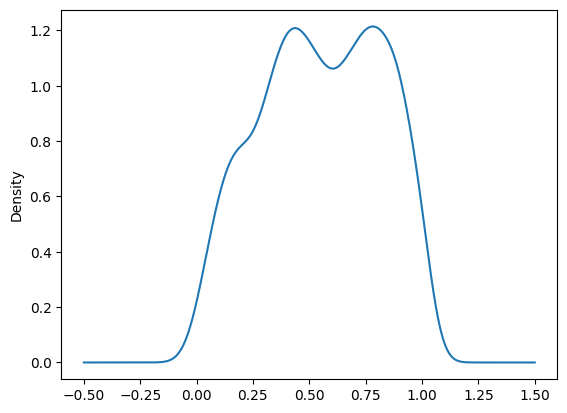

In [10]:
df_usvsthem.usVSthem_scale.plot(kind="kde")

## Bias quantification: pairwise comparison

In [ ]:
with open('/queries_labeled.pkl', 'rb') as f:
        labeled_input_queries = pickle.load(f)

with open('/bias_labeled.pkl', 'rb') as f:
        labeled_queries = pickle.load(f)


In [ ]:
df_test = pd.DataFrame([a for a in labeled_queries if a])

In [ ]:
df_test

query biased stance_pol stance_lib category_top  \
0                   husband  False    neutral    neutral      private   
1                     party  False    neutral    neutral    political   
2      running for governor  False    neutral    neutral    political   
3                internship  False    neutral    neutral    political   
4                  virginia  False    neutral    neutral        other   
...                     ...    ...        ...        ...          ...   
45195          wife apoorva  False    neutral    neutral      private   
45196            wiki books  False    neutral    neutral        other   
45197   wife apoorva tewari  False    neutral    neutral      private   
45198          axovant scam   True    neutral    neutral    political   
45199    exits trump's doge   True      right    neutral    political   

      category_query  
0      informational  
1      informational  
2      informational  
3      informational  
4      informational  
...              ...  
45195  informational  
45196  informational  
45197  informational  
45198  informational  
45199  informational  

[45200 rows x 6 columns]

In [ ]:
biased_queries = list(df_test.loc[df_test['biased'] == "True"]["query"].unique())

In [ ]:
len(biased_queries)

3253

### baseline: direct prompting

In [ ]:
# baseline_single_item.py

from typing import List, Dict, Any, Tuple, Optional, Literal
from concurrent.futures import ThreadPoolExecutor, as_completed
from pydantic import BaseModel, Field, validator
from tqdm import tqdm
import pickle, math, random, ast

# Assumes you have an OpenAI client object named `client` set up elsewhere
# from openai import OpenAI
# client = OpenAI()

# -----------------------------
# Structured-output schema
# -----------------------------
class SingleAssessment(BaseModel):
    item_id: int = Field(..., description="Index of the input text in the batch")
    biased: Literal["yes", "no"]
    severity: float = Field(..., ge=0.0, le=1.0)

    @validator("severity", pre=True)
    def _clip(cls, v):
        try:
            x = float(v)
        except Exception:
            x = 0.5
        return min(1.0, max(0.0, x))


# -----------------------------
# LLM call: one text -> (biased, severity)
# -----------------------------
def assess_one_llm_structured(
    item_id: int,
    text: str,
    llm_model: str,
    temperature: float = 0.2,
    verbose: int = 0,
) -> Optional[SingleAssessment]:
    """
    Ask the LLM to rate a SINGLE text for bias (binary yes/no) and severity in [0,1].
    Returns a SingleAssessment or None on failure (caller handles defaults).
    """
    try:
        result = client.beta.chat.completions.parse(
            model=llm_model,
            temperature=temperature,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are an expert in analyzing bias.\n"
                        "Given ONE text, return ONLY a structured JSON object with fields:\n"
                        "  - item_id (int, echoed from the user),\n"
                        "  - biased (string 'yes' or 'no'),\n"
                        "  - severity (float in [0,1], where 0=no bias, 1=extremely biased).\n"
                        "Do NOT include any explanations or extra fields."
                    ),
                },
                {
                    "role": "user",
                    "content": f"item_id: {item_id}\ntext:\n{text}",
                },
            ],
            response_format=SingleAssessment,
        )

        if verbose > 12:
            print(result.choices[0].message.content)

        # Depending on SDK, parsed content may already be a model; keep a safe path:
        try:
            # Some SDKs offer .parsed; if not, fall back to literal_eval on content string.
            parsed = result.choices[0].message.parsed  # type: ignore[attr-defined]
        except Exception:
            parsed = ast.literal_eval(result.choices[0].message.content)

        # Coerce into SingleAssessment for validation
        if isinstance(parsed, dict):
            return SingleAssessment(**parsed)
        elif isinstance(parsed, SingleAssessment):
            return parsed
        else:
            return None

    except Exception as e:
        if verbose > 0:
            print(f"[warn] LLM single assessment failed for item {item_id}: {e}")
        return None


# -----------------------------
# Mapping severity -> Elo-like score
# -----------------------------
def severity_to_elo(severity: float, low: float = 1000.0, high: float = 2000.0) -> float:
    """
    Map severity in [0,1] to an Elo-like scale so results are directly comparable.
    0.0 -> low (default 1000), 0.5 -> 1500, 1.0 -> high (default 2000).
    """
    s = min(1.0, max(0.0, float(severity)))
    return low + (high - low) * s


# -----------------------------
# Baseline driver (parallel)
# -----------------------------
def baseline_single_item_assessment(
    texts: List[str],
    llm_model: str,
    save_path: str,
    temperature: float = 0.2,
    verbose: int = 0,
) -> Tuple[Dict[str, float], List[Any]]:
    """
    Parallel baseline:
      - Input: list of texts.
      - For each text, ask LLM for biased 'yes'/'no' and severity [0,1].
      - Convert severity to Elo-like score (1000..2000).
      - Return (elo_scores, match_history) in a shape similar to pairwise methods.
      - Persist a pickle with results and run counters compatible with your analytics.

    Returns:
      elo_scores: Dict[text, float]
      match_history: List[List[dict]]  # one 'round' with one entry per item
    """

    n = len(texts)
    if n == 0:
        # empty input, still persist an empty run
        results_to_save = {
            "elo_scores": {},
            "match_history": [],
            "run_counters": {
                "method": "single_baseline",
                "pairwise_calls": 0,
                "inferred_pairs": 0,
                # Count these like "listwise_calls" so downstream cost code works:
                "listwise_calls": 0,
                "single_calls": 0,
                "effective_calls_api": 0,
            },
        }
        with open(save_path, "wb") as f:
            pickle.dump(results_to_save, f)
        if verbose > 0:
            print(f"Saved empty baseline to {save_path}")
        return {}, []

    # ---- Run LLM calls in parallel ----
    max_workers = max(50, n)  # per your parallelization rule
    assessments: Dict[int, SingleAssessment] = {}

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        futures = {
            pool.submit(assess_one_llm_structured, i, text, llm_model, temperature, verbose): i
            for i, text in enumerate(texts)
        }
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Baseline single-item LLM"):
            i = futures[fut]
            resp = None
            try:
                resp = fut.result()
            except Exception as e:
                if verbose > 0:
                    print(f"[warn] worker exception for {i}: {e}")
            if resp is None:
                # Fallback default if the LLM call failed
                resp = SingleAssessment(item_id=i, biased="no", severity=0.5)
            assessments[i] = resp

    # ---- Assemble outputs in a familiar shape ----
    elo_scores: Dict[str, float] = {}
    round_entries = []

    for i in range(n):
        a = assessments[i]
        elo_val = severity_to_elo(a.severity)
        key = texts[i]  # keep the same keying convention as your pairwise methods
        elo_scores[key] = elo_val

        # One synthetic "match" entry per item so downstream tooling can display something.
        # Using fields analogous to pairwise logs; 'text2' and 'elo_change' are None/zero.
        round_entries.append(
            {
                "text1": key,
                "text2": None,
                "winner": "biased" if a.biased == "yes" else "non-biased",
                "severity": float(a.severity),
                "new_elo_a": elo_val,
                "new_elo_b": None,
                "delta_a": 0.0,
                "delta_b": None,
            }
        )

    match_history = [round_entries]  # a single "round" of independent assessments

    # ---- Counters for cost plots ----
    # Treat these as "listwise-like" single calls so existing cost code works:
    pairwise_calls = 0
    inferred_pairs = 0
    single_calls = n
    listwise_calls = n  # <- so effective_calls_api = n with your existing formula
    effective_calls_api = listwise_calls  # pairwise_api_calls = 0

    results_to_save = {
        "elo_scores": elo_scores,
        "match_history": match_history,
        "run_counters": {
            "method": "single_baseline",
            "pairwise_calls": pairwise_calls,
            "inferred_pairs": inferred_pairs,
            "listwise_calls": listwise_calls,
            "single_calls": single_calls,
            "effective_calls_api": effective_calls_api,
        },
        # Optional: raw assessments by index for auditing
        "raw_assessments": {
            i: {"biased": assessments[i].biased, "severity": float(assessments[i].severity)}
            for i in range(n)
        },
    }

    with open(save_path, "wb") as f:
        pickle.dump(results_to_save, f)

    if verbose > 0:
        print(f"[baseline] Saved results to {save_path} (n={n}, calls={effective_calls_api})")

    return elo_scores, match_history


/tmp/ipython-input-3179558221.py:21: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("severity", pre=True)


# Comparison Approaches

#### comparators and rankers

In [ ]:

                            model=llm_model,
                            temperature=temperature,
                            messages=messages,
                            response_format=_ListwiseSchema,
                        )
                        content = result.choices[0].message.content
                        data = _safe_parse_json(content) if isinstance(content, str) else content
                    else:
                        result = client.chat.completions.create(
                            model=llm_model,
                            temperature=temperature,
                            messages=messages,
                        )
                        content = result.choices[0].message.content
                        data = _safe_parse_json(content)
                else:
                    raise RuntimeError("OpenAI client is not initialized. Create `client = OpenAI()` or pass a global client.")

                if not isinstance(data, dict) or "order" not in data:
                    raise ValueError("Parse failed")
                order = list(map(int, data["order"]))

                # Sanitize to a permutation of 0..k-1 (dedupe while preserving order; append any missing)
                seen = set()
                cleaned = []
                for idx in order:
                    if 0 <= idx < k and idx not in seen:
                        cleaned.append(idx)
                        seen.add(idx)
                for idx in range(k):
                    if idx not in seen:
                        cleaned.append(idx)

                return cleaned
            except Exception as e:
                last_err = e
                continue

        # On repeated failure, fall back to identity order
        return list(range(k))

    return listwise_ranker


In [ ]:

from __future__ import annotations
from typing import Any, Callable, Dict, List, Optional, Tuple
import math
import random
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------------------------------------------------------------
# Progress bar helper (tqdm with graceful fallback)
# -----------------------------------------------------------------------------
def _get_tqdm():
    try:
        from tqdm import tqdm  # type: ignore
        return tqdm
    except Exception:
        class _TQDM:
            def __init__(self, iterable=None, total=None, desc="", leave=True):
                self.iterable = iterable if iterable is not None else range(total or 0)
                self.desc = desc
            def __iter__(self):
                for x in self.iterable:
                    yield x
            def update(self, n=1): pass
            def close(self): pass
        return _TQDM

tqdm = _get_tqdm()

# -----------------------------------------------------------------------------
# ELO helpers
# -----------------------------------------------------------------------------
def expected_score(elo_a: float, elo_b: float) -> float:
    return 1.0 / (1.0 + 10.0 ** ((elo_b - elo_a) / 400.0))

def update_elo(elo_a: float, elo_b: float, actual_score_a: float, k_factor: int = 32) -> Tuple[float, float]:
    expected_a = expected_score(elo_a, elo_b)
    elo_a_new = elo_a + k_factor * (actual_score_a - expected_a)
    elo_b_new = elo_b + k_factor * ((1.0 - actual_score_a) - (1.0 - expected_a))
    return elo_a_new, elo_b_new

def _log_match(
    match_history_round: List[Dict[str, Any]],
    text1: str,
    text2: Optional[str],
    winner: Optional[str],
    elo_a_before: Optional[float],
    elo_b_before: Optional[float],
    elo_a_after: Optional[float],
    elo_b_after: Optional[float],
) -> None:
    if text2 is None:
        match_history_round.append(
            {"text1": text1, "text2": None, "winner": None, "elo_change": (0.0, 0.0)}
        )
        return

    if elo_a_before is None or elo_b_before is None or elo_a_after is None or elo_b_after is None:
        delta_a = 0.0
        delta_b = 0.0
    else:
        delta_a = elo_a_before - elo_a_after
        delta_b = elo_b_before - elo_b_after

    match_history_round.append(
        {
            "text1": text1,
            "text2": text2,
            "winner": winner,
            "elo_change": (delta_a, delta_b),
        }
    )

def _save_state(save_path: Optional[str], elo_scores: Dict[str, float], match_history: List[List[Dict[str, Any]]], meta: Optional[Dict[str, Any]] = None) -> None:
    if save_path is None:
        return
    payload = {"elo_scores": elo_scores, "match_history": match_history}
    if meta is not None:
        payload["meta"] = meta
    with open(save_path, "wb") as f:
        pickle.dump(payload, f)

# Utility: build disjoint pairs for a list of items with a strategy
def _build_pairs(
    items: List[str],
    elo_scores: Dict[str, float],
    strategy: str = "random",
    randomness_factor: float = 0.1,
    rng: Optional[random.Random] = None,
) -> List[Tuple[str, Optional[str]]]:
    rng = rng or random.Random()
    if strategy == "random" or len(items) < 2:
        pool = items[:]
        rng.shuffle(pool)
        pairs = list(zip(pool[::2], pool[1::2]))
        if len(pool) % 2 == 1:
            pairs.append((pool[-1], None))
        return pairs

    # "similar": sort by Elo, pair within a window
    sorted_items = sorted(items, key=lambda x: elo_scores[x])
    used = set()
    pairs: List[Tuple[str, Optional[str]]] = []
    idxs = list(range(len(sorted_items)))
    rng.shuffle(idxs)
    for i in idxs:
        if i in used:
            continue
        window = max(1, int(len(sorted_items) * randomness_factor))
        cands = [j for j in range(max(0, i - window), min(len(sorted_items), i + window + 1))
                 if j != i and j not in used]
        if cands:
            j = rng.choice(cands)
            pairs.append((sorted_items[i], sorted_items[j]))
            used.update({i, j})
        else:
            remaining = [k for k in range(len(sorted_items)) if k != i and k not in used]
            if remaining:
                j = rng.choice(remaining)
                pairs.append((sorted_items[i], sorted_items[j]))
                used.update({i, j})
            else:
                pairs.append((sorted_items[i], None))
                used.add(i)
    return pairs

# -----------------------------------------------------------------------------
# 1) Streak-based early-stop classification/ranking (PARALLEL)
# -----------------------------------------------------------------------------
def streak_early_stop_elo(
    queries: List[str],
    compare_fn: Callable[[str, str], float],
    save_path: Optional[str] = None,
    initial_elo: float = 1500.0,
    k_factor: int = 32,
    r: int = 3,
    min_distinct_opponents: int = 3,
    max_epochs: int = 50,
    opponent_selection: str = "random",   # "random" or "similar"
    randomness_factor: float = 0.1,
    seed: Optional[int] = 42,
) -> Tuple[Dict[str, float], List[List[Dict[str, Any]]], Dict[str, str]]:
    """
    Each item plays at most one match per epoch; pairs are formed by strategy and
    evaluated in PARALLEL using a frozen Elo snapshot for the updates.
    """
    rng = random.Random(seed)
    elo_scores: Dict[str, float] = {q: initial_elo for q in queries}
    decided: Dict[str, str] = {}
    streaks: Dict[str, Tuple[int, int, set]] = {q: (0, 0, set()) for q in queries}
    match_history: List[List[Dict[str, Any]]] = []

    for epoch in tqdm(range(max_epochs), desc="Streak epochs"):
        active = [q for q in queries if q not in decided]
        if len(active) <= 1:
            break

        pairs = _build_pairs(active, elo_scores, strategy=opponent_selection, randomness_factor=randomness_factor, rng=rng)
        # Freeze snapshot
        snapshot = elo_scores.copy()

        # Parallel compare
        tasks = [(a, b) for (a, b) in pairs if b is not None]
        workers = max(50, len(tasks))
        results: Dict[Tuple[str, str], float] = {}
        if tasks:
            with ThreadPoolExecutor(max_workers=workers) as pool:
                future_to_pair = {pool.submit(compare_fn, a, b): (a, b) for (a, b) in tasks}
                for fut in as_completed(future_to_pair):
                    a, b = future_to_pair[fut]
                    try:
                        results[(a, b)] = fut.result()
                    except Exception:
                        results[(a, b)] = 0.5  # treat failure as tie

        round_log: List[Dict[str, Any]] = []
        # Apply updates based on snapshot
        for a, b in pairs:
            if b is None:
                _log_match(round_log, a, None, None, None, None, None, None)
                continue
            res = results.get((a, b), 0.5)
            ea, eb = snapshot[a], snapshot[b]
            if res == 1:
                na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor); winner = a
                w, l, seen = streaks[a]; streaks[a] = (w+1, 0, seen | {b})
                ow, ol, oseen = streaks[b]; streaks[b] = (0, ol+1, oseen | {a})
            elif res == 0:
                nb, na = update_elo(eb, ea, 1.0, k_factor=k_factor); winner = b
                w, l, seen = streaks[a]; streaks[a] = (0, l+1, seen | {b})
                ow, ol, oseen = streaks[b]; streaks[b] = (ow+1, 0, oseen | {a})
            else:
                na, nb = update_elo(ea, eb, 0.5, k_factor=k_factor); winner = "tie"
                w, l, seen = streaks[a]; streaks[a] = (0, 0, seen)
                ow, ol, oseen = streaks[b]; streaks[b] = (0, 0, oseen)
            elo_scores[a], elo_scores[b] = na, nb
            _log_match(round_log, a, b, winner, ea, eb, na, nb)

        # Decide labels
        for q in [x for x in active if x not in decided]:
            w, l, seen = streaks[q]
            if w >= r and len(seen) >= min_distinct_opponents:
                decided[q] = "biased"
            elif l >= r and len(seen) >= min_distinct_opponents:
                decided[q] = "non-biased"

        match_history.append(round_log)
        _save_state(save_path, elo_scores, match_history, meta={
            "mode": "streak_early_stop_elo",
            "params": {"r": r, "min_distinct_opponents": min_distinct_opponents, "opponent_selection": opponent_selection, "randomness_factor": randomness_factor}
        })

        if len(decided) == len(queries):
            break

    return elo_scores, match_history, decided

# -----------------------------------------------------------------------------
# 2) Standard Elo with tail pruning after round Y (PARALLEL per round)
# -----------------------------------------------------------------------------
def pairwise_comparison_elo_prune(
    queries: List[str],
    compare_fn: Callable[[str, str], float],
    n_rounds: int,
    save_path: Optional[str] = None,
    initial_elo: float = 1500.0,
    k_factor: int = 32,
    match_strategy: str = "random",
    randomness_factor: float = 0.1,
    prune_start_round: int = 12,
    prune_percent: float = 0.1,
    stability_margin: float = 0.0,
    seed: Optional[int] = 42,
) -> Tuple[Dict[str, float], List[List[Dict[str, Any]]], Dict[int, List[str]]]:
    rng = random.Random(seed)
    elo_scores: Dict[str, float] = {q: initial_elo for q in queries}
    active: List[str] = list(queries)
    match_history: List[List[Dict[str, Any]]] = []
    pruned_by_round: Dict[int, List[str]] = {}

    for rd in tqdm(range(1, n_rounds + 1), desc="Pruned Elo rounds"):
        if len(active) <= 1:
            break
        pairs = _build_pairs(active, elo_scores, strategy=match_strategy, randomness_factor=randomness_factor, rng=rng)
        snapshot = elo_scores.copy()

        tasks = [(a, b) for (a, b) in pairs if b is not None]
        workers = max(50, len(tasks))
        results: Dict[Tuple[str, str], float] = {}
        if tasks:
            with ThreadPoolExecutor(max_workers=workers) as pool:
                future_to_pair = {pool.submit(compare_fn, a, b): (a, b) for (a, b) in tasks}
                for fut in as_completed(future_to_pair):
                    a, b = future_to_pair[fut]
                    try:
                        results[(a, b)] = fut.result()
                    except Exception:
                        results[(a, b)] = 0.5

        round_log: List[Dict[str, Any]] = []
        for a, b in pairs:
            if b is None:
                _log_match(round_log, a, None, None, None, None, None, None)
                continue
            res = results.get((a, b), 0.5)
            ea, eb = snapshot[a], snapshot[b]
            if res == 1:
                na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor); winner = a
            elif res == 0:
                nb, na = update_elo(eb, ea, 1.0, k_factor=k_factor); winner = b
            else:
                na, nb = update_elo(ea, eb, 0.5, k_factor=k_factor); winner = "tie"
            elo_scores[a], elo_scores[b] = na, nb
            _log_match(round_log, a, b, winner, ea, eb, na, nb)

        match_history.append(round_log)

        # Prune after round
        if rd >= prune_start_round and len(active) > 2 and prune_percent > 0.0:
            m = max(1, int(len(active) * prune_percent))
            m_low = m // 2; m_high = m - m_low
            ranked = sorted(active, key=lambda x: elo_scores[x])
            low_tail = ranked[:m_low]
            high_tail = ranked[-m_high:]
            if stability_margin > 0.0:
                center = sum(elo_scores[q] for q in active) / len(active)
                low_tail = [q for q in low_tail if (center - elo_scores[q]) >= stability_margin]
                high_tail = [q for q in high_tail if (elo_scores[q] - center) >= stability_margin]
            pruned = list(dict.fromkeys(low_tail + high_tail))
            if pruned:
                active = [q for q in active if q not in pruned]
                pruned_by_round[rd] = pruned

        _save_state(save_path, elo_scores, match_history, meta={
            "mode": "pairwise_comparison_elo_prune",
            "params": {"prune_start_round": prune_start_round, "prune_percent": prune_percent, "stability_margin": stability_margin}
        })

    return elo_scores, match_history, pruned_by_round

# -----------------------------------------------------------------------------
# 3) Listwise sorting with multi-round grouping + stitching (PARALLEL listwise calls)
# -----------------------------------------------------------------------------
def listwise_sort_and_merge_rounds(
    queries: List[str],
    listwise_ranker: Callable[[List[str]], List[int]],
    save_path: Optional[str] = None,
    initial_elo: float = 1500.0,
    k_factor: int = 32,
    n_rounds: int = 2,
    k: int = 10,
    overlap: int = 0,
    boundary_passes: int = 0,
    grouping_strategy: str = "similar",   # "random" or "similar"
    randomness_factor: float = 0.1,
    listwise_call_budget: Optional[int] = None,
    seed: Optional[int] = 42,
) -> Tuple[Dict[str, float], List[List[Dict[str, Any]]], Dict[str, Any]]:
    rng = random.Random(seed)
    n = len(queries)
    elo_scores: Dict[str, float] = {q: initial_elo for q in queries}
    match_history: List[List[Dict[str, Any]]] = []
    meta: Dict[str, Any] = {
        "mode": "listwise_sort_and_merge_rounds",
        "params": {"n_rounds": n_rounds, "k": k, "overlap": overlap, "boundary_passes": boundary_passes, "grouping_strategy": grouping_strategy, "randomness_factor": randomness_factor},
        "counters": {"listwise_calls": 0, "inferred_pairs": 0},
    }

    def _can_spend_listwise() -> bool:
        return listwise_call_budget is None or meta["counters"]["listwise_calls"] < listwise_call_budget

    def _spend_listwise(nc: int = 1):
        meta["counters"]["listwise_calls"] += nc

    def _form_groups(curr_queries: List[str]) -> List[List[str]]:
        qs = curr_queries[:]
        groups: List[List[str]] = []
        if grouping_strategy == "random":
            rng.shuffle(qs)
        else:
            qs.sort(key=lambda x: elo_scores[x])
            if randomness_factor > 0.0:
                window = max(1, int(len(qs) * randomness_factor))
                swaps = max(1, int(len(qs) * randomness_factor))
                for _ in range(swaps):
                    i = rng.randrange(len(qs))
                    lo = max(0, i - window)
                    hi = min(len(qs) - 1, i + window)
                    j = rng.randrange(lo, hi + 1)
                    qs[i], qs[j] = qs[j], qs[i]
        for s in range(0, len(qs), k):
            groups.append(qs[s:s+k])
        return groups

    for rd in tqdm(range(n_rounds), desc="Listwise rounds"):
        groups = _form_groups(queries)

        # ---- Parallel listwise calls for groups ----
        round_log: List[Dict[str, Any]] = []
        if _can_spend_listwise():
            tasks = [(idx, grp) for idx, grp in enumerate(groups) if grp]
            if listwise_call_budget is not None:
                # cap tasks if budget would be exceeded
                allowable = listwise_call_budget - meta["counters"]["listwise_calls"]
                tasks = tasks[:max(0, allowable)]
            workers = max(50, len(tasks))
            group_orders: Dict[int, List[int]] = {}
            if tasks:
                with ThreadPoolExecutor(max_workers=workers) as pool:
                    fut_to_idx = {pool.submit(listwise_ranker, grp): idx for idx, grp in tasks}
                    for fut in as_completed(fut_to_idx):
                        idx = fut_to_idx[fut]
                        try:
                            order = fut.result()
                        except Exception:
                            order = list(range(len(groups[idx])))
                        group_orders[idx] = order
                _spend_listwise(len(tasks))

            # Apply inferred pairwise wins inside each group (sequential updates)
            for idx, grp in enumerate(groups):
                if idx not in group_orders:
                    continue
                order = group_orders[idx]
                # sanitize permutation
                seen = set()
                clean = []
                for ii in order:
                    if 0 <= ii < len(grp) and ii not in seen:
                        clean.append(ii); seen.add(ii)
                for ii in range(len(grp)):
                    if ii not in seen:
                        clean.append(ii)
                ranked_chunk = [grp[i] for i in clean]
                for i in range(len(ranked_chunk)):
                    for j in range(i+1, len(ranked_chunk)):
                        a, b = ranked_chunk[i], ranked_chunk[j]
                        ea, eb = elo_scores[a], elo_scores[b]
                        na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor)
                        elo_scores[a], elo_scores[b] = na, nb
                        _log_match(round_log, a, b, a, ea, eb, na, nb)
                        meta["counters"]["inferred_pairs"] += 1

        if round_log:
            match_history.append(round_log)
            _save_state(save_path, elo_scores, match_history, meta)

        # ---- Stitching passes (parallel windows) ----
        for pass_idx in range(boundary_passes):
            if len(groups) <= 1 or not _can_spend_listwise():
                break
            windows = []
            for g in range(len(groups) - 1):
                left = groups[g]; right = groups[g+1]
                Lw = left[max(0, len(left)-overlap):]
                Rw = right[:max(0, overlap)]
                window = Lw + Rw
                if len(window) >= 2:
                    windows.append((g, window, Lw, Rw))
            if listwise_call_budget is not None:
                allowable = listwise_call_budget - meta["counters"]["listwise_calls"]
                windows = windows[:max(0, allowable)]
            workers = max(50, len(windows))
            window_orders: Dict[int, List[int]] = {}
            if windows:
                with ThreadPoolExecutor(max_workers=workers) as pool:
                    fut_to_key = {pool.submit(listwise_ranker, w): g for (g, w, _, _) in windows}
                    for fut in as_completed(fut_to_key):
                        g = fut_to_key[fut]
                        try:
                            order = fut.result()
                        except Exception:
                            # identity
                            g_idx = next(idx for (idx, w, _, _) in windows if idx == g)
                            order = list(range(len(windows[[idx for (idx, _, _, _) in windows].index(g)][1])))
                        window_orders[g] = order
                _spend_listwise(len(windows))

            round_log = []
            for (g, window, Lw, Rw) in windows:
                if g not in window_orders:
                    continue
                order = window_orders[g]
                # sanitize
                seen = set(); clean = []
                for ii in order:
                    if 0 <= ii < len(window) and ii not in seen:
                        clean.append(ii); seen.add(ii)
                for ii in range(len(window)):
                    if ii not in seen:
                        clean.append(ii)
                ranked_window = [window[i] for i in clean]
                for i in range(len(ranked_window)):
                    for j in range(i+1, len(ranked_window)):
                        a, b = ranked_window[i], ranked_window[j]
                        ea, eb = elo_scores[a], elo_scores[b]
                        na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor)
                        elo_scores[a], elo_scores[b] = na, nb
                        _log_match(round_log, a, b, a, ea, eb, na, nb)
                        meta["counters"]["inferred_pairs"] += 1

                # reorder groups around boundary g
                left = groups[g]; right = groups[g+1]
                left_core = left[:-len(Lw)] if len(Lw) <= len(left) else []
                right_core = right[len(Rw):] if len(Rw) <= len(right) else []
                new_left_tail = [x for x in ranked_window if x in left]
                new_right_head = [x for x in ranked_window if x in right and x not in new_left_tail]
                groups[g] = left_core + new_left_tail
                groups[g+1] = new_right_head + right_core

            if round_log:
                match_history.append(round_log)
                _save_state(save_path, elo_scores, match_history, meta)

    return elo_scores, match_history, meta

# -----------------------------------------------------------------------------
# 4) Budgeted hybrid ranker (PARALLEL phases)
# -----------------------------------------------------------------------------
def budgeted_hybrid_ranker(
    queries: List[str],
    compare_fn: Callable[[str, str], float],
    listwise_ranker: Callable[[List[str]], List[int]],
    save_path: Optional[str] = None,
    # Elo settings
    initial_elo: float = 1500.0,
    k_factor: int = 32,
    # Phase A (listwise) settings
    listwise_n_rounds: int = 1,
    k: int = 10,
    overlap: int = 3,
    boundary_passes: int = 1,
    grouping_strategy: str = "similar",   # "random" or "similar"
    randomness_factor: float = 0.1,
    listwise_groups_limit: Optional[int] = None,
    listwise_call_budget: Optional[int] = None,
    # Phase B (streak) settings
    streak_r: int = 3,
    streak_min_distinct: int = 3,
    streak_epochs: int = 8,
    streak_opponent_selection: str = "similar",
    # Phase C (pruned Elo) settings
    prune_rounds: int = 8,
    prune_percent: float = 0.15,
    stability_margin: float = 0.0,
    prune_match_strategy: str = "similar",
    prune_randomness_factor: float = 0.1,
    # Global budget
    pairwise_call_budget: Optional[int] = None,
    seed: Optional[int] = 42,
) -> Tuple[Dict[str, float], List[List[Dict[str, Any]]], Dict[str, Any]]:
    rng = random.Random(seed)
    n = len(queries)
    elo_scores: Dict[str, float] = {q: initial_elo for q in queries}
    match_history: List[List[Dict[str, Any]]] = []
    meta: Dict[str, Any] = {
        "mode": "budgeted_hybrid_ranker",
        "counters": {"listwise_calls": 0, "pairwise_calls": 0, "inferred_pairs": 0},
    }

    def _can_spend_listwise() -> bool:
        return listwise_call_budget is None or meta["counters"]["listwise_calls"] < listwise_call_budget
    def _spend_listwise(nc: int = 1):
        meta["counters"]["listwise_calls"] += nc
    def _can_spend_pairwise() -> bool:
        return pairwise_call_budget is None or meta["counters"]["pairwise_calls"] < pairwise_call_budget
    def _spend_pairwise(nc: int = 1):
        meta["counters"]["pairwise_calls"] += nc

    # ---- Phase A: listwise rounds (parallel) ----
    def _form_groups(curr_queries: List[str]) -> List[List[str]]:
        qs = curr_queries[:]
        groups: List[List[str]] = []
        if grouping_strategy == "random":
            rng.shuffle(qs)
        else:
            qs.sort(key=lambda x: elo_scores[x])
            if randomness_factor > 0.0:
                window = max(1, int(len(qs) * randomness_factor))
                swaps = max(1, int(len(qs) * randomness_factor))
                for _ in range(swaps):
                    i = rng.randrange(len(qs))
                    lo = max(0, i - window)
                    hi = min(len(qs) - 1, i + window)
                    j = rng.randrange(lo, hi + 1)
                    qs[i], qs[j] = qs[j], qs[i]
        for s in range(0, len(qs), k):
            groups.append(qs[s:s+k])
        return groups

    for rd in tqdm(range(listwise_n_rounds), desc="Hybrid: listwise rounds"):
        groups = _form_groups(queries)
        if rd == 0 and listwise_groups_limit is not None:
            groups = groups[:max(0, listwise_groups_limit)]

        round_log: List[Dict[str, Any]] = []
        tasks = [(idx, grp) for idx, grp in enumerate(groups) if grp and _can_spend_listwise()]
        if listwise_call_budget is not None:
            allowable = listwise_call_budget - meta["counters"]["listwise_calls"]
            tasks = tasks[:max(0, allowable)]
        workers = max(50, len(tasks))
        group_orders: Dict[int, List[int]] = {}
        if tasks:
            with ThreadPoolExecutor(max_workers=workers) as pool:
                fut_to_idx = {pool.submit(listwise_ranker, grp): idx for idx, grp in tasks}
                for fut in as_completed(fut_to_idx):
                    idx = fut_to_idx[fut]
                    try:
                        order = fut.result()
                    except Exception:
                        order = list(range(len(groups[idx])))
                    group_orders[idx] = order
            _spend_listwise(len(tasks))

        for idx, grp in enumerate(groups):
            if idx not in group_orders:
                continue
            order = group_orders[idx]
            seen = set(); clean = []
            for ii in order:
                if 0 <= ii < len(grp) and ii not in seen:
                    clean.append(ii); seen.add(ii)
            for ii in range(len(grp)):
                if ii not in seen:
                    clean.append(ii)
            ranked_chunk = [grp[i] for i in clean]
            for i in range(len(ranked_chunk)):
                for j in range(i+1, len(ranked_chunk)):
                    a, b = ranked_chunk[i], ranked_chunk[j]
                    ea, eb = elo_scores[a], elo_scores[b]
                    na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor)
                    elo_scores[a], elo_scores[b] = na, nb
                    _log_match(round_log, a, b, a, ea, eb, na, nb)
                    meta["counters"]["inferred_pairs"] += 1

        if round_log:
            match_history.append(round_log)

        # Stitching (parallel windows)
        for pass_idx in range(boundary_passes):
            windows = []
            for g in range(len(groups) - 1):
                left = groups[g]; right = groups[g+1]
                Lw = left[max(0, len(left)-overlap):]
                Rw = right[:max(0, overlap)]
                window = Lw + Rw
                if len(window) >= 2 and _can_spend_listwise():
                    windows.append((g, window, Lw, Rw))
            if listwise_call_budget is not None:
                allowable = listwise_call_budget - meta["counters"]["listwise_calls"]
                windows = windows[:max(0, allowable)]
            workers = max(50, len(windows))
            window_orders: Dict[int, List[int]] = {}
            if windows:
                with ThreadPoolExecutor(max_workers=workers) as pool:
                    fut_to_key = {pool.submit(listwise_ranker, w): g for (g, w, _, _) in windows}
                    for fut in as_completed(fut_to_key):
                        g = fut_to_key[fut]
                        try:
                            order = fut.result()
                        except Exception:
                            order = list(range(len(next(w for (gg, w, _, _) in windows if gg == g))))
                        window_orders[g] = order
                _spend_listwise(len(windows))

            round_log = []
            for (g, window, Lw, Rw) in windows:
                if g not in window_orders:
                    continue
                order = window_orders[g]
                seen = set(); clean = []
                for ii in order:
                    if 0 <= ii < len(window) and ii not in seen:
                        clean.append(ii); seen.add(ii)
                for ii in range(len(window)):
                    if ii not in seen:
                        clean.append(ii)
                ranked_window = [window[i] for i in clean]
                for i in range(len(ranked_window)):
                    for j in range(i+1, len(ranked_window)):
                        a, b = ranked_window[i], ranked_window[j]
                        ea, eb = elo_scores[a], elo_scores[b]
                        na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor)
                        elo_scores[a], elo_scores[b] = na, nb
                        _log_match(round_log, a, b, a, ea, eb, na, nb)
                        meta["counters"]["inferred_pairs"] += 1

                # reorder groups
                left = groups[g]; right = groups[g+1]
                left_core = left[:-len(Lw)] if len(Lw) <= len(left) else []
                right_core = right[len(Rw):] if len(Rw) <= len(right) else []
                new_left_tail = [x for x in ranked_window if x in left]
                new_right_head = [x for x in ranked_window if x in right and x not in new_left_tail]
                groups[g] = left_core + new_left_tail
                groups[g+1] = new_right_head + right_core

            if round_log:
                match_history.append(round_log)

        _save_state(save_path, elo_scores, match_history, meta)

    # ---- Phase B: streak (parallel pairwise) ----
    decided: Dict[str, str] = {}
    streaks: Dict[str, Tuple[int, int, set]] = {q: (0, 0, set()) for q in queries}

    for epoch in tqdm(range(streak_epochs), desc="Hybrid: streak epochs"):
        active = [q for q in queries if q not in decided]
        if len(active) <= 1 or not _can_spend_pairwise():
            break
        pairs = _build_pairs(active, elo_scores, strategy=streak_opponent_selection, randomness_factor=randomness_factor, rng=rng)
        snapshot = elo_scores.copy()

        tasks = [(a, b) for (a, b) in pairs if b is not None]
        workers = max(50, len(tasks))
        results: Dict[Tuple[str, str], float] = {}
        if tasks:
            with ThreadPoolExecutor(max_workers=workers) as pool:
                fut_to_pair = {pool.submit(compare_fn, a, b): (a, b) for (a, b) in tasks if _can_spend_pairwise()}
                for fut in as_completed(fut_to_pair):
                    a, b = fut_to_pair[fut]
                    try:
                        results[(a, b)] = fut.result()
                    except Exception:
                        results[(a, b)] = 0.5
                    meta["counters"]["pairwise_calls"] += 1
                    if not _can_spend_pairwise():
                        break

        round_log: List[Dict[str, Any]] = []
        for a, b in pairs:
            if b is None:
                _log_match(round_log, a, None, None, None, None, None, None)
                continue
            res = results.get((a, b), 0.5)
            ea, eb = snapshot[a], snapshot[b]
            if res == 1:
                na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor); winner = a
                w, l, seen = streaks[a]; streaks[a] = (w+1, 0, seen | {b})
                ow, ol, oseen = streaks[b]; streaks[b] = (0, ol+1, oseen | {a})
            elif res == 0:
                nb, na = update_elo(eb, ea, 1.0, k_factor=k_factor); winner = b
                w, l, seen = streaks[a]; streaks[a] = (0, l+1, seen | {b})
                ow, ol, oseen = streaks[b]; streaks[b] = (ow+1, 0, oseen | {a})
            else:
                na, nb = update_elo(ea, eb, 0.5, k_factor=k_factor); winner = "tie"
                w, l, seen = streaks[a]; streaks[a] = (0, 0, seen)
                ow, ol, oseen = streaks[b]; streaks[b] = (0, 0, oseen)
            elo_scores[a], elo_scores[b] = na, nb
            _log_match(round_log, a, b, winner, ea, eb, na, nb)

        # decisions
        for q in [x for x in active if x not in decided]:
            w, l, seen = streaks[q]
            if w >= streak_r and len(seen) >= streak_min_distinct:
                decided[q] = "biased"
            elif l >= streak_r and len(seen) >= streak_min_distinct:
                decided[q] = "non-biased"

        if round_log:
            match_history.append(round_log)
            _save_state(save_path, elo_scores, match_history, meta)

    # ---- Phase C: pruned Elo (parallel pairwise) ----
    active = [q for q in queries if q not in decided]
    for rd in tqdm(range(prune_rounds), desc="Hybrid: pruned Elo rounds"):
        if len(active) <= 1 or not _can_spend_pairwise():
            break
        pairs = _build_pairs(active, elo_scores, strategy=prune_match_strategy, randomness_factor=prune_randomness_factor, rng=rng)
        snapshot = elo_scores.copy()

        tasks = [(a, b) for (a, b) in pairs if b is not None]
        workers = max(50, len(tasks))
        results: Dict[Tuple[str, str], float] = {}
        if tasks:
            with ThreadPoolExecutor(max_workers=workers) as pool:
                fut_to_pair = {pool.submit(compare_fn, a, b): (a, b) for (a, b) in tasks if _can_spend_pairwise()}
                for fut in as_completed(fut_to_pair):
                    a, b = fut_to_pair[fut]
                    try:
                        results[(a, b)] = fut.result()
                    except Exception:
                        results[(a, b)] = 0.5
                    meta["counters"]["pairwise_calls"] += 1
                    if not _can_spend_pairwise():
                        break

        round_log: List[Dict[str, Any]] = []
        for a, b in pairs:
            if b is None:
                _log_match(round_log, a, None, None, None, None, None, None)
                continue
            res = results.get((a, b), 0.5)
            ea, eb = snapshot[a], snapshot[b]
            if res == 1:
                na, nb = update_elo(ea, eb, 1.0, k_factor=k_factor); winner = a
            elif res == 0:
                nb, na = update_elo(eb, ea, 1.0, k_factor=k_factor); winner = b
            else:
                na, nb = update_elo(ea, eb, 0.5, k_factor=k_factor); winner = "tie"
            elo_scores[a], elo_scores[b] = na, nb
            _log_match(round_log, a, b, winner, ea, eb, na, nb)

        if round_log:
            match_history.append(round_log)
            _save_state(save_path, elo_scores, match_history, meta)

        # prune
        if prune_percent > 0.0 and len(active) > 2:
            m = max(1, int(len(active) * prune_percent))
            m_low = m // 2; m_high = m - m_low
            ranked = sorted(active, key=lambda x: elo_scores[x])
            low_tail = ranked[:m_low]; high_tail = ranked[-m_high:]
            if stability_margin > 0.0:
                center = sum(elo_scores[q] for q in active) / len(active)
                low_tail = [q for q in low_tail if (center - elo_scores[q]) >= stability_margin]
                high_tail = [q for q in high_tail if (elo_scores[q] - center) >= stability_margin]
            pruned = list(dict.fromkeys(low_tail + high_tail))
            if pruned:
                active = [q for q in active if q not in pruned]

    _save_state(save_path, elo_scores, match_history, meta)
    return elo_scores, match_history, meta


### run pairwise comparison

pairwise comparison has been run for gpt 4.1 mini and nano for 12 and 24 rounds each. Thus: skip pairw. comp. here.

In [ ]:
prompt_usvsthem = (
        "You are an expert judge of bias in the sense of negative sentiment and stance towards minorities or demoraphic groups."
        "Given a list of short texts, rank them from MOST biased (Discriminatory) to LEAST biased (Supportive)."
        "Return ONLY a JSON array of integers representing the 0-based positions "
        "of the input list in sorted order. Do not include any explanation."
    )


In [ ]:
# listwise_bt_min.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, List, Dict, Tuple, Any, Optional
import math, numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# =================== Elo (online, order-dependent) ===================

def _elo_expected(ra: float, rb: float) -> float:
    return 1.0 / (1.0 + 10.0 ** ((rb - ra) / 400.0))

def _elo_update(ra: float, rb: float, score_a: float, k: float = 32.0) -> Tuple[float, float]:
    ea = _elo_expected(ra, rb)
    ra_new = ra + k * (score_a - ea)
    rb_new = rb + k * ((1.0 - score_a) - (1.0 - ea))
    return ra_new, rb_new

# =================== Bradley–Terry (batch MLE via MM) ===================

def _bt_fit_theta(pairs: List[Tuple[int,int,float]], n_items: int,
                  *, l2: float = 1e-6, max_iter: int = 2000, tol: float = 1e-9) -> np.ndarray:
    """
    pairs: list of (i, j, y) with y in {1.0 (i>j), 0.0 (j>i)}.
    Returns theta (log-ability), centered to mean 0.
    """
    if not pairs:
        return np.zeros(n_items, dtype=float)

    W = np.zeros((n_items, n_items), dtype=float)   # wins of i over j
    M = np.zeros((n_items, n_items), dtype=float)   # matches between i and j

    for i, j, y in pairs:
        if i == j:
            continue
        if y == 1.0:
            W[i, j] += 1.0
        else:
            W[j, i] += 1.0
        M[i, j] += 1.0
        M[j, i] += 1.0

    w_i = W.sum(axis=1)
    m_ij = W + W.T

    pi = (w_i + 1.0).astype(float)
    eps = 1e-12

    for _ in range(max_iter):
        denom = np.zeros_like(pi)
        for i in range(n_items):
            js = np.nonzero(m_ij[i])[0]
            if js.size:
                denom[i] = np.sum(m_ij[i, js] / (pi[i] + pi[js]))
            denom[i] += l2
        numer = w_i + l2
        pi_new = numer / np.maximum(denom, eps)
        # normalize (BT is scale-invariant): geometric mean -> 1
        gmean = np.exp(np.mean(np.log(np.maximum(pi_new, eps))))
        pi_new /= gmean
        if np.max(np.abs(pi_new - pi)) < tol * max(1.0, np.max(pi)):
            pi = pi_new
            break
        pi = pi_new

    theta = np.log(np.maximum(pi, eps))
    theta -= theta.mean()
    return theta

def _minmax01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size == 0: return x
    mn, mx = float(np.min(x)), float(np.max(x))
    if mx - mn < 1e-12:
        return np.full_like(x, 0.5)
    return (x - mn) / (mx - mn)

# =================== Listwise rounds (no overlap) ===================

@dataclass
class ListwiseConfig:
    n_rounds: int = 3
    k: int = 10
    seed: int = 42
    initial_elo: float = 1500.0
    k_factor: float = 32.0          # Elo K
    progress: bool = True
    max_workers: Optional[int] = None   # if None -> max(50, num_groups)

def _partition(order: np.ndarray, k: int) -> List[np.ndarray]:
    return [order[s:s+k] for s in range(0, len(order), k)]

def listwise_then_bt(
    texts: List[str],
    listwise_rank_fn: Callable[[List[str]], List[str]],
    config: ListwiseConfig = ListwiseConfig(),
) -> Tuple[
    Dict[str,float],              # elo_scores
    Dict[str,float],              # bt_theta (mean-zero)
    Dict[str,float],              # bt_theta_01 (0-1 scaled)
    List[Dict[str,Any]],          # match_history
]:
    """
    Pipeline:
      - Round 1: random order; group into lists of size k; rank each list with listwise_rank_fn.
      - From each ranked list, deduce pairwise edges (earlier > later), then Elo-update (K=32) in stable order.
      - Rounds 2..n: order by current Elo (descending), repeat.
      - After n rounds, fit Bradley–Terry (single batch MLE) on ALL implied pairs and return results.
    Returns: (elo_scores, bt_theta, bt_theta_01, match_history)
    """
    n = len(texts)
    if n == 0:
        return {}, {}, {}, []

    id_by_text = {t:i for i,t in enumerate(texts)}
    rng = np.random.default_rng(config.seed)
    elo = np.full(n, float(config.initial_elo))

    match_history: List[Dict[str,Any]] = []
    all_pairs: List[Tuple[int,int,float]] = []  # (i,j,1.0) with i beats j

    # ---------- helper: rank one group ----------
    def _rank_group(round_idx: int, gidx: int, idxs: np.ndarray) -> Dict[str,Any]:
        sub = [texts[i] for i in idxs]
        ranked = listwise_rank_fn(sub)  # must return the SAME items, ordered most->least biased
        if set(ranked) != set(sub) or len(ranked) != len(sub):
            raise RuntimeError("listwise_rank_fn must return the same items it received, reordered.")
        r_idx = [id_by_text[t] for t in ranked]
        # implied pairwise edges: earlier > later
        edges = []
        for a in range(len(r_idx)):
            for b in range(a+1, len(r_idx)):
                i, j = r_idx[a], r_idx[b]
                edges.append((i, j, 1.0))
        return {
            "round": round_idx,
            "group": gidx,
            "input_indices": idxs.tolist(),
            "ranked_indices": r_idx,
            "edges": edges,  # numeric pairs for this group
        }

    # ---------- rounds ----------
    # round 1: random order
    order = rng.permutation(n)

    for r in range(1, config.n_rounds + 1):
        groups = _partition(order, config.k)
        tasks = list(enumerate(groups))
        max_workers = config.max_workers or max(50, len(tasks))
        it = tqdm(tasks, total=len(tasks), desc=f"Listwise R{r}", leave=False) if config.progress else tasks

        round_results: List[Dict[str,Any]] = []
        with ThreadPoolExecutor(max_workers=max_workers) as pool:
            futs = [pool.submit(_rank_group, r, gi, g) for gi, g in it]
            for fut in as_completed(futs):
                round_results.append(fut.result())

        # deterministic order: sort by group index, then within-group pair order (earlier -> later)
        round_results.sort(key=lambda d: d["group"])

        # Elo updates over implied pairs from this round
        for rec in round_results:
            for (i, j, y) in rec["edges"]:  # y=1.0 always here
                ra, rb = _elo_update(elo[i], elo[j], 1.0, k=config.k_factor)
                elo[i], elo[j] = ra, rb

        # collect pairs & history
        for rec in round_results:
            all_pairs.extend(rec["edges"])
            match_history.append({
                "round": rec["round"],
                "group": rec["group"],
                "input_indices": rec["input_indices"],
                "ranked_indices": rec["ranked_indices"],
            })

        # next round order by Elo (desc)
        if r < config.n_rounds:
            order = np.argsort(-elo)

    # ---------- final BT on full log ----------
    theta = _bt_fit_theta(all_pairs, n_items=n)
    theta01 = _minmax01(theta)

    elo_scores   = {texts[i]: float(elo[i])     for i in range(n)}
    bt_theta     = {texts[i]: float(theta[i])   for i in range(n)}
    bt_theta_01  = {texts[i]: float(theta01[i]) for i in range(n)}

    return elo_scores, bt_theta, bt_theta_01, match_history

# =================== (Optional) Minimal demo ranker ===================
# Replace this with your real LLM ranker. It must return the SAME items, reordered.
def demo_ranker_most_caps_first(items: List[str]) -> List[str]:
    # Toy heuristic: more uppercase chars => "more biased" (just for smoke tests).
    return [t for t in sorted(items, key=lambda s: -sum(c.isupper() for c in s))]


In [ ]:
def make_openai_listwise_ranker(
    model: str = "gpt-5-nano-2025-08-07",
    temperature: float = 0.0,
    max_retries: int = 2,
    retry_backoff_s: float = 0.8,
):
    """
    Returns: listwise_rank_fn(texts) -> texts_sorted (same items, MOST->LEAST biased).
    Requires OPENAI_API_KEY in env. The prompt matches your dataset: bias = negative prejudice toward a group.
    """
    import time, json, re
    import openai
    client = openai.OpenAI()

    SYSTEM = (
        # "You are an expert annotator of social bias. "
        # "In this task, *bias* means NEGATIVE prejudice or hostility toward a group of people "
        # "(e.g., religion, ethnicity, nationality, gender, sexual orientation, disability). "
        # "Statements that support or defend a group are NOT considered biased for this task."
        "You are an expert judge of social bias in the sense of negative sentiment, pejudice, and stance towards minorities or demoraphic groups."

    )
    INSTRUCTIONS = (
        "Rank the texts from MOST biased (Discriminatory) to LEAST biased (Supportive). "
        "Return ONLY a JSON array of integers: the 0-based indices of the input texts in that order. "
        "Do not include any explanation or extra text."
    )

    def _parse_indices(txt: str, n: int) -> list[int]:
        m = re.search(r"\[[^\]]*\]", txt, flags=re.S)
        arr = json.loads(m.group(0) if m else txt.strip())
        idx = [int(x) for x in arr]
        if sorted(idx) != list(range(n)):
            raise ValueError("Not a permutation of 0..n-1.")
        return idx

    def rank(texts: list[str]) -> list[str]:
        if not texts: return []
        user = "Texts:\n" + "\n".join(f"[{i}] {t}" for i, t in enumerate(texts))
        last_err = None
        for a in range(max_retries + 1):
            try:
                r = client.chat.completions.create(
                    model=model, temperature=temperature,
                    messages=[{"role":"system","content":SYSTEM},
                              {"role":"system", "content":INSTRUCTIONS},
                              {"role":"user","content":user}],
                )
                content = r.choices[0].message.content.strip()
                order = _parse_indices(content, len(texts))
                return [texts[i] for i in order]
            except Exception as e:
                last_err = e
                if a >= max_retries: break
                time.sleep(retry_backoff_s * (2 ** a))
        # fallback: return unchanged order (or raise to fail-fast)
        return list(texts)

    return rank

def make_openai_listwise_ranker(
    model: str = "gpt-4o-mini",
    temperature: float = 0.0,
    max_retries: int = 2,
    retry_backoff_s: float = 0.8,
):
    """
    Returns: listwise_rank_fn(texts) -> texts_sorted (same items, MOST->LEAST biased).
    Requires OPENAI_API_KEY in env. The prompt matches your dataset: bias = negative prejudice toward a group.
    """
    import time, json, re
    import openai
    client = openai.OpenAI()

    SYSTEM = (
        "You are an expert annotator of social bias. "
        "In this task, *bias* means NEGATIVE prejudice or hostility toward a group of people "
        "(e.g., religion, ethnicity, nationality, gender, sexual orientation, disability). "
        "Statements that support or defend a group are NOT considered biased for this task."
    )
    INSTRUCTIONS = (
        "Rank the texts from MOST biased to LEAST biased according to the definition above. "
        "Return ONLY a JSON array of integers: the 0-based indices of the input texts in that order. "
        "Do not include any explanation or extra text."
    )

    def _parse_indices(txt: str, n: int) -> list[int]:
        m = re.search(r"\[[^\]]*\]", txt, flags=re.S)
        arr = json.loads(m.group(0) if m else txt.strip())
        idx = [int(x) for x in arr]
        if sorted(idx) != list(range(n)):
            raise ValueError("Not a permutation of 0..n-1.")
        return idx

    def rank(texts: list[str]) -> list[str]:
        if not texts: return []
        user = "Texts:\n" + "\n".join(f"[{i}] {t}" for i, t in enumerate(texts)) + "\n\n" + INSTRUCTIONS
        last_err = None
        for a in range(max_retries + 1):
            try:
                r = client.chat.completions.create(
                    model=model, temperature=temperature,
                    messages=[{"role":"system","content":SYSTEM},
                              {"role":"user","content":user}],
                )
                content = r.choices[0].message.content.strip()
                order = _parse_indices(content, len(texts))
                return [texts[i] for i in order]
            except Exception as e:
                last_err = e
                if a >= max_retries: break
                time.sleep(retry_backoff_s * (2 ** a))
        # fallback: return unchanged order (or raise to fail-fast)
        return list(texts)

    return rank


In [ ]:
# listwise_bt_min_fixed.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, List, Dict, Tuple, Any, Optional
import math, json, re
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# =================== Elo ===================

def _elo_expected(ra: float, rb: float) -> float:
    return 1.0 / (1.0 + 10.0 ** ((rb - ra) / 400.0))

def _elo_update(ra: float, rb: float, score_a: float, k: float = 32.0) -> Tuple[float, float]:
    ea = _elo_expected(ra, rb)
    ra_new = ra + k * (score_a - ea)
    rb_new = rb + k * ((1.0 - score_a) - (1.0 - ea))
    return ra_new, rb_new

# =================== Bradley–Terry (MM) ===================

def _bt_fit_theta(pairs: List[Tuple[int,int,float]], n_items: int,
                  *, l2: float = 1e-6, max_iter: int = 2000, tol: float = 1e-9) -> np.ndarray:
    if not pairs:
        return np.zeros(n_items, dtype=float)

    W = np.zeros((n_items, n_items), dtype=float)
    M = np.zeros((n_items, n_items), dtype=float)
    for i, j, y in pairs:
        if i == j:
            continue
        if y == 1.0: W[i, j] += 1.0
        else:       W[j, i] += 1.0
        M[i, j] += 1.0; M[j, i] += 1.0

    w_i = W.sum(axis=1)
    m_ij = W + W.T
    pi = (w_i + 1.0).astype(float)
    eps = 1e-12

    for _ in range(max_iter):
        denom = np.zeros_like(pi)
        for i in range(n_items):
            js = np.nonzero(m_ij[i])[0]
            if js.size:
                denom[i] = np.sum(m_ij[i, js] / (pi[i] + pi[js]))
            denom[i] += l2
        numer = w_i + l2
        pi_new = numer / np.maximum(denom, eps)
        gmean = np.exp(np.mean(np.log(np.maximum(pi_new, eps))))
        pi_new /= gmean
        if np.max(np.abs(pi_new - pi)) < tol * max(1.0, np.max(pi)):
            pi = pi_new
            break
        pi = pi_new

    theta = np.log(np.maximum(pi, eps))
    theta -= theta.mean()
    return theta

def _minmax01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size == 0: return x
    mn, mx = float(np.min(x)), float(np.max(x))
    if mx - mn < 1e-12: return np.full_like(x, 0.5)
    return (x - mn) / (mx - mn)

# =================== Config ===================

@dataclass
class ListwiseConfig:
    n_rounds: int = 3
    k: int = 10
    seed: int = 42
    initial_elo: float = 1500.0
    k_factor: float = 32.0
    progress: bool = True
    max_workers: Optional[int] = None   # if None -> max(50, num_groups)

# =================== Core runner (ID-based ranking) ===================

# Signature required for ranker: ranker(sub_ids: List[int], sub_texts: List[str]) -> List[int]
Ranker = Callable[[List[int], List[str]], List[int]]

def _partition(order: np.ndarray, k: int) -> List[np.ndarray]:
    return [order[s:s+k] for s in range(0, len(order), k)]

def listwise_then_bt(
    texts: List[str],
    listwise_rank_by_ids: Ranker,
    config: ListwiseConfig = ListwiseConfig(),
) -> Tuple[
    Dict[int,float],              # elo_scores by global ID
    Dict[int,float],              # bt_theta by global ID (mean-zero)
    Dict[int,float],              # bt_theta_01 by global ID (0-1)
    List[Dict[str,Any]],          # match_history
]:
    """
    Pipeline:
      - Round 1: random order; split into groups of size k; rank each group by IDs (most->least biased).
      - From each ranked group, deduce pairwise edges (earlier > later); Elo-update (K=32) in stable order.
      - Rounds 2..n: sort by current Elo (desc), repeat.
      - After n rounds, fit BT once on ALL implied pairs.
    Returns: (elo_scores, bt_theta, bt_theta_01, match_history), all keyed by global integer ID.
    """
    n = len(texts)
    if n == 0:
        return {}, {}, {}, []

    rng = np.random.default_rng(config.seed)
    elo = np.full(n, float(config.initial_elo))

    match_history: List[Dict[str,Any]] = []
    all_pairs: List[Tuple[int,int,float]] = []  # (i,j,1.0) with i beats j

    # ---- helper: rank one group (STRICT validation; no fallbacks) ----
    def _rank_group(round_idx: int, gidx: int, idxs: np.ndarray) -> Dict[str,Any]:
        sub_ids   = idxs.tolist()
        sub_texts = [texts[i] for i in sub_ids]
        out_ids   = listwise_rank_by_ids(sub_ids, sub_texts)  # must return a permutation of sub_ids

        if not isinstance(out_ids, list) or any(not isinstance(x, int) for x in out_ids):
            raise RuntimeError("Ranker must return a list of integer IDs.")
        if sorted(out_ids) != sorted(sub_ids):
            raise RuntimeError(f"Ranker must return a permutation of input IDs. "
                               f"got={out_ids} expected-permutation-of={sub_ids}")
        # implied pairwise edges: earlier > later
        edges = []
        for a in range(len(out_ids)):
            for b in range(a+1, len(out_ids)):
                i, j = out_ids[a], out_ids[b]
                edges.append((i, j, 1.0))
        return {
            "round": round_idx,
            "group": gidx,
            "input_indices": sub_ids,
            "ranked_indices": out_ids,
            "edges": edges,
        }

    # ---- rounds ----
    order = rng.permutation(n)  # round 1 random
    for r in range(1, config.n_rounds + 1):
        groups = _partition(order, config.k)
        tasks = list(enumerate(groups))
        max_workers = config.max_workers or max(50, len(tasks))
        it = tqdm(tasks, total=len(tasks), desc=f"Listwise R{r}", leave=False) if config.progress else tasks

        round_results: List[Dict[str,Any]] = []
        with ThreadPoolExecutor(max_workers=max_workers) as pool:
            futs = [pool.submit(_rank_group, r, gi, g) for gi, g in it]
            for fut in as_completed(futs):
                rr = fut.result()
                round_results.append(rr)

        # Stable order: by group id, then within-group pair order
        round_results.sort(key=lambda d: d["group"])

        # Elo updates over implied pairs from this round
        for rec in round_results:
            for (i, j, _) in rec["edges"]:
                ra, rb = _elo_update(elo[i], elo[j], 1.0, k=config.k_factor)
                elo[i], elo[j] = ra, rb

        # collect pairs & history
        for rec in round_results:
            all_pairs.extend(rec["edges"])
            match_history.append({
                "round": rec["round"],
                "group": rec["group"],
                "input_indices": rec["input_indices"],
                "ranked_indices": rec["ranked_indices"],
            })

        # next round order by Elo (desc)
        if r < config.n_rounds:
            order = np.argsort(-elo)

    # ---- final BT on full log ----
    theta   = _bt_fit_theta(all_pairs, n_items=n)
    theta01 = _minmax01(theta)

    elo_scores  = {i: float(elo[i])     for i in range(n)}
    bt_theta    = {i: float(theta[i])   for i in range(n)}
    bt_theta_01 = {i: float(theta01[i]) for i in range(n)}
    return elo_scores, bt_theta, bt_theta_01, match_history

# =================== OpenAI ID-based listwise ranker ===================
def make_openai_id_ranker(
    model: str = "gpt-4o-mini",
    temperature: float = 1.0,
    max_retries: int = 2,
    retry_backoff_s: float = 0.8,
):
    """
    Returns a ranker(sub_ids, sub_texts) -> ranked_ids (MOST->LEAST biased).
    Bias definition matches your dataset: NEGATIVE prejudice toward a group.
    Output must be ONLY a JSON array of the provided IDs in ranked order.
    The parser is *repairing*: it converts any model drift into a valid permutation.
    """
    import time, json, re
    import openai
    client = openai.OpenAI()

    SYSTEM_USVSTHEM = (
        "You are an expert annotator of social bias. "
        "Here, bias means NEGATIVE prejudice or hostility toward a group of people "
        "(e.g., religion, ethnicity, nationality, gender, sexual orientation, disability). "
        "Statements that support or defend a group are NOT considered biased for this task."
    )

    SYSTEM_BABE = (
        "You are an expert annotator for bias."
        "Consider linguistic bias, framing, loaded language, implicit assumptions, and other similar forms of bias.\n"
    )

    # SYSTEM = (
    #     "You are an expert annotator of social bias. "
    #     "In this task, *bias* means NEGATIVE prejudice or hostility toward a group of people "
    #     "(e.g., religion, ethnicity, nationality, gender, sexual orientation, disability). "
    #     "Statements that support or defend a group are NOT considered biased for this task."
    #     "Rank the texts from MOST biased to LEAST biased according to the definition above. "
    #     "Return ONLY a JSON array of integers: the 0-based indices of the input texts in that order. "
    #     "Do not include any explanation or extra text."
    # )


    def _parse_json_array(text: str):
        m = re.search(r"\[[^\]]*\]", text, flags=re.S)
        s = m.group(0) if m else text.strip()
        return json.loads(s)

    def _repair_to_permutation(arr, allowed_ids, input_order):
        """
        - Keep only integers in allowed_ids, in the order they appear
        - Drop duplicates
        - Append any missing IDs at the end, preserving input_order
        """
        allowed = set(allowed_ids)
        seen = set()
        cleaned = []
        for x in arr:
            try:
                v = int(x)
            except Exception:
                continue
            if v in allowed and v not in seen:
                cleaned.append(v)
                seen.add(v)
        # append missing in original input order
        for v in input_order:
            if v not in seen:
                cleaned.append(v)
                seen.add(v)
        # final guard: truncate to exact length
        return cleaned[: len(input_order)]

    def rank(sub_ids: list[int], sub_texts: list[str]) -> list[int]:
        if not sub_ids:
            return []
        allowed_str = ", ".join(str(i) for i in sub_ids)
        L = len(sub_ids)

        # Clear, constrained instructions with the exact ID set and length
        USER = (
            "Items (ID → text):\n" +
            "\n".join(f"{i}: {t}" for i, t in zip(sub_ids, sub_texts)) +
            "\n\nTask:\n"
            f"Rank the items from MOST biased to LEAST biased.\n"
            f"Return ONLY a JSON array of EXACTLY {L} integers that is a permutation of this set: [{allowed_str}].\n"
            "Do not include any other numbers. Do not repeat any number. No explanations."
        )

        last_err = None
        for a in range(max_retries + 1):
            try:
                resp = client.chat.completions.create(
                    model=model,
                    temperature=temperature,
                    messages=[
                        {"role": "system", "content": SYSTEM_BABE},
                        {"role": "user", "content": USER},
                    ],
                )
                content = resp.choices[0].message.content.strip()
                arr = _parse_json_array(content)
                repaired = _repair_to_permutation(arr, allowed_ids=sub_ids, input_order=sub_ids)
                # sanity check
                if len(repaired) != L or set(repaired) != set(sub_ids):
                    # Shouldn't happen, but fall back to input order to avoid crashing a run
                    return list(sub_ids)
                return repaired
            except Exception as e:
                last_err = e
                if a >= max_retries:
                    break
                time.sleep(retry_backoff_s * (2 ** a))
        raise RuntimeError(f"OpenAI listwise ranking failed: {last_err}")

    return rank


In [ ]:
# direct_bias_scalar_baseline_fixed.py
from __future__ import annotations
import re, json, time, math
from typing import Dict, List, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed

def make_openai_direct_bias_scalar_scorer(
    model: str = "gpt-5-mini-2025-08-07",     # or your "gpt-5-mini-2025-08-07"
    temperature: float = 0.0,
    max_workers: int = 64,
    max_retries: int = 3,
    backoff_base_s: float = 0.8,
    max_tokens: int = 16,
    debug: bool = False,
):
    """
    Returns: score_fn(texts: list[str]) -> dict[text, float]
    - Bias = NEGATIVE prejudice/hostility toward a group.
    - Model must return ONLY a single number in [0,1] (no words/JSON).
    - Parallelized with ThreadPoolExecutor.
    Requires: `pip install openai` and OPENAI_API_KEY set.
    """
    import openai
    client = openai.OpenAI()

    SYSTEM_USVSTHEM = (
        "You are an expert annotator of social bias. "
        "Bias means NEGATIVE prejudice or hostility toward a group of people "
        "(e.g., religion, ethnicity, nationality, gender, sexual orientation, disability). "
        "Statements that support or defend a group are NOT biased for this task."
        "Output ONLY one real number in [0,1] for bias severity under the definition above.\n"
        "where : 0 = not biased/maximallysupportive,  1 = maximally biased.\n"
    )

    SYSTEM_BABE = (
        "You are an expert annotator of media bias. "
        "Output ONLY one real number in [0,1] for bias severity.\n"
        "where : 0 = not biased,  1 = maximally biased.\n"
    )


    _num_re = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")

    def _parse_scalar(s: str) -> float:
        s = s.strip()
        # Try strict number first
        try:
            v = json.loads(s)
            if isinstance(v, (int, float)) and math.isfinite(v):
                return float(min(1.0, max(0.0, v)))
        except Exception:
            pass
        # Fallback: first float-looking token
        m = _num_re.search(s)
        if not m:
            return 0.0
        try:
            x = float(m.group(0))
        except Exception:
            return 0.0
        if not math.isfinite(x):
            return 0.0
        return float(min(1.0, max(0.0, x)))

    def _score_one(txt: str) -> float:
        last_err: Optional[Exception] = None
        raw: Optional[str] = None
        for attempt in range(max_retries + 1):
            try:

                resp = client.chat.completions.create(
                    model="gpt-5-mini-2025-08-07",
                    messages=[
                        {"role": "developer", "content": SYSTEM_BABE},
                        {"role": "user", "content": f"Text:\n{txt}\n\n"},
                    ]
                )
                raw = (resp.choices[0].message.content or "").strip()
                val = _parse_scalar(raw)
                # If the model ignored instructions (e.g., emitted text), val may be 0.0.
                # We still return it, but keep raw in debug.
                return val
            except Exception as e:
                last_err = e
                if attempt >= max_retries:
                    return 10.0
                time.sleep(backoff_base_s * (2 ** attempt))
        return 0.0

    def score_fn(texts: List[str]) -> Dict[str, float]:
        if not texts:
            return {}
        out: Dict[str, float] = {}
        with ThreadPoolExecutor(max_workers=max_workers) as pool:
            futs = {pool.submit(_score_one, t): t for t in texts}
            for f in as_completed(futs):
                t = futs[f]
                try:
                    out[t] = f.result()
                except Exception:
                    print(f)
                    out[t] = -1.0
        return out

    return score_fn


In [ ]:
scorer = make_openai_direct_bias_scalar_scorer(
    model="gpt-5-mini-2025-08-07",  # or "gpt-4o-mini"
    max_workers=64,
    max_tokens=16
)
scores_noPromttuning = scorer(df_usvsthem.body.to_list())


In [ ]:
with open("/USvsTHEM/baseline_5mini.pkl", 'wb') as f:
    pickle.dump(scores_noPromttuning, f)

In [ ]:
df_usvsthem["baseline_5mini"] = df_usvsthem.body.map(scores_noPromttuning)

### run for us vs them

In [ ]:
# 1) Prepare your texts
texts = df_usvsthem.body.to_list()  # list[str], your dataset
# ranker = make_openai_listwise_ranker(model="gpt-5-nano-2025-08-07")
ranker = make_openai_id_ranker(model="gpt-5-mini-2025-08-07")
cfg = ListwiseConfig(n_rounds=3, k=10, seed=123, k_factor=32)

elo_scores, bt_theta, bt_theta_01, match_history = listwise_then_bt(
    texts,
    listwise_rank_by_ids=ranker,
    config=cfg
)

In [ ]:
with open("/USvsTHEM/listwise_10_3_25flash.pkl", 'wb') as f:
    pickle.dump([elo_scores, bt_theta, bt_theta_01, match_history], f)

In [ ]:
with open("/USvsTHEM/listwise_10_3_25flash.pkl", 'rb') as f:
    curr = pickle.load(f)
    listwise_10_3_25flash_elo_scores = curr[0]
    listwise_10_3_25flash_bt_theta = curr[1]
    listwise_10_3_25flash_bt_theta_01 = curr[2]
    listwise_10_3_25flash_match_history = curr[3]
    listwise_10_3_25flash_elo_by_text = {texts[i]: v for i, v in listwise_10_3_25flash_elo_scores.items()}
    listwise_10_3_25flash_bt01_by_text = {texts[i]: v for i, v in listwise_10_3_25flash_bt_theta_01.items()}

In [ ]:
with open("/USvsTHEM/listwise_10_3_mini.pkl", 'rb') as f:
    curr = pickle.load(f)
    listwise_10_3_mini_elo_scores = curr[0]
    listwise_10_3_mini_bt_theta = curr[1]
    listwise_10_3_mini_bt_theta_01 = curr[2]
    listwise_10_3_mini_match_history = curr[3]
    listwise_10_3_mini_elo_by_text = {texts[i]: v for i, v in listwise_10_3_mini_elo_scores.items()}
    listwise_10_3_mini_bt01_by_text = {texts[i]: v for i, v in listwise_10_3_mini_bt_theta_01.items()}

with open("/USvsTHEM/listwise_10_3_mini_promptTuned.pkl", 'rb') as f:
    curr = pickle.load(f)
    listwise_10_3_mini_promptTuned_elo_scores = curr[0]
    listwise_10_3_mini_promptTuned_bt_theta = curr[1]
    listwise_10_3_mini_promptTuned_bt_theta_01 = curr[2]
    listwise_10_3_mini_promptTuned_match_history = curr[3]
    listwise_10_3_mini_promptTuned_elo_by_text = {texts[i]: v for i, v in listwise_10_3_mini_promptTuned_elo_scores.items()}
    listwise_10_3_mini_promptTuned_bt01_by_text = {texts[i]: v for i, v in listwise_10_3_mini_promptTuned_bt_theta_01.items()}

with open("/USvsTHEM/listwise_10_3_nano.pkl", 'rb') as f:
    curr = pickle.load(f)
    listwise_10_3_nano_elo_scores = curr[0]
    listwise_10_3_nano_bt_theta = curr[1]
    listwise_10_3_nano_bt_theta_01 = curr[2]
    listwise_10_3_nano_match_history = curr[3]
    listwise_10_3_nano_elo_by_text = {texts[i]: v for i, v in listwise_10_3_nano_elo_scores.items()}
    listwise_10_3_nano_bt01_by_text = {texts[i]: v for i, v in listwise_10_3_nano_bt_theta_01.items()}


In [ ]:
elo_by_text = {texts[i]: v for i, v in elo_scores.items()}
bt01_by_text = {texts[i]: v for i, v in bt_theta_01.items()}

In [ ]:
df_usvsthem["listwise_10_3_25flash_score_listwise_BT"] = df_usvsthem.body.map(listwise_10_3_25flash_bt01_by_text)
df_usvsthem["listwise_10_3_25flash_score_listwise_elo"] = df_usvsthem.body.map(listwise_10_3_25flash_elo_by_text)

In [ ]:
df_usvsthem["listwise_10_3_mini_score_listwise_BT"] = df_usvsthem.body.map(listwise_10_3_mini_bt01_by_text)
df_usvsthem["listwise_10_3_mini_score_listwise_elo"] = df_usvsthem.body.map(listwise_10_3_mini_elo_by_text)

df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_BT"] = df_usvsthem.body.map(listwise_10_3_mini_promptTuned_bt01_by_text)
df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_elo"] = df_usvsthem.body.map(listwise_10_3_mini_promptTuned_elo_by_text)

df_usvsthem["listwise_10_3_nano_score_listwise_BT"] = df_usvsthem.body.map(listwise_10_3_nano_bt01_by_text)
df_usvsthem["listwise_10_3_nano_score_listwise_elo"] = df_usvsthem.body.map(listwise_10_3_nano_elo_by_text)

df_usvsthem["listwise_10_3_25flash_score_listwise_BT"] = df_usvsthem.body.map(listwise_10_3_25flash_bt01_by_text)
df_usvsthem["listwise_10_3_25flash_score_listwise_elo"] = df_usvsthem.body.map(listwise_10_3_25flash_elo_by_text)

NameError: name 'listwise_10_3_mini_bt01_by_text' is not defined

In [ ]:
def normalize (v, min, max):
  return (v - min) / (max - min)

In [ ]:
df_usvsthem["listwise_10_3_mini_score_listwise_elo01"] = normalize(df_usvsthem["listwise_10_3_mini_score_listwise_elo"], df_usvsthem["listwise_10_3_mini_score_listwise_elo"].min(), df_usvsthem["listwise_10_3_mini_score_listwise_elo"].max())
df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_elo01"] = normalize(df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_elo"], df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_elo"].min(), df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_elo"].max())
df_usvsthem["listwise_10_3_nano_score_listwise_elo01"] = normalize(df_usvsthem["listwise_10_3_nano_score_listwise_elo"], df_usvsthem["listwise_10_3_nano_score_listwise_elo"].min(), df_usvsthem["listwise_10_3_nano_score_listwise_elo"].max())

In [ ]:
df_usvsthem["listwise_10_3_25flash_score_listwise_elo01"] = normalize(df_usvsthem["listwise_10_3_25flash_score_listwise_elo"], df_usvsthem["listwise_10_3_25flash_score_listwise_elo"].min(), df_usvsthem["listwise_10_3_25flash_score_listwise_elo"].max())

In [ ]:
def pearson_corr_01(x, y):
    """
    Pearson correlation between two variables on a 0–1 float scale.
    - Accepts lists/tuples/np.arrays
    - Ignores NaNs pairwise
    - Validates values are within [0, 1]
    Returns: float in [-1, 1] or np.nan if undefined.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")

    # Pairwise valid mask (exclude NaNs)
    mask = ~np.isnan(x) & ~np.isnan(y)
    xv, yv = x[mask], y[mask]

    if xv.size < 2:
        return np.nan  # not enough data

    # Ensure values are in [0, 1]
    if (xv < 0).any() or (xv > 1).any() or (yv < 0).any() or (yv > 1).any():
        raise ValueError("All values must be within [0, 1].")

    # If either variable is constant, correlation is undefined
    if np.allclose(np.std(xv), 0) or np.allclose(np.std(yv), 0):
        return np.nan

    # Pearson correlation
    r = np.corrcoef(xv, yv)[0, 1]
    return float(r)


In [ ]:
df_usvsthem.columns

Index(['Unnamed: 0', 'body', 'usVSthem_scale', 'is_Disc_Crit', 'group', 'bias',
       'Anger', 'Contempt', 'Disgust', 'Fear', 'Gratitude', 'Guilt',
       'Happiness', 'Hope', 'Pride', 'Relief', 'Sadness', 'Sympathy',
       'Emotions_Neutral', 'allsides_name',
       'listwise_10_3_mini_score_listwise_BT',
       'listwise_10_3_mini_score_listwise_elo',
       'listwise_10_3_mini_promptTuned_score_listwise_BT',
       'listwise_10_3_mini_promptTuned_score_listwise_elo',
       'listwise_10_3_nano_score_listwise_BT',
       'listwise_10_3_nano_score_listwise_elo',
       'listwise_10_3_mini_score_listwise_elo01',
       'listwise_10_3_mini_promptTuned_score_listwise_elo01',
       'listwise_10_3_nano_score_listwise_elo01', 'baseline_5mini_prompted',
       'baseline_5mini'],
      dtype='object')

In [ ]:
df_usvsthem

Unnamed: 0                                               body  \
0              0  Well yeah but then so does the Republican cong...   
1              1  Notice how when there's an article that hurts ...   
2              2  Right. Let’s launch back to back investigation...   
3              3  I'd love to see one media outlet like just com...   
4              4  look at the story of this perverse monster and...   
...          ...                                                ...   
2256        2256  Maybe we can reign in the ridiculous amount of...   
2257        2257  During their private White House meeting on Th...   
2258        2258  Funny how quickly people forget the Obama admi...   
2259        2259  HEY HEY HEY, AS A MAINER, I AM AN AUTHORITY ON...   
2260        2260  I understand why people want to live near exis...   

      usVSthem_scale  is_Disc_Crit          group          bias  Anger  \
0           0.803091          True  Conservatives          left  False   
1           0.018368         False  Conservatives  right-center  False   
2           0.822697          True       Liberals        center   True   
3           0.602182          True       Liberals          left   True   
4           0.906241          True       Refugees        center   True   
...              ...           ...            ...           ...    ...   
2256        0.567816         False           Jews          left  False   
2257        0.367621         False  Conservatives        center  False   
2258        0.410738         False        Muslims         right  False   
2259        0.953048          True  Conservatives        center   True   
2260        0.655735         False           Jews        center  False   

      Contempt  Disgust   Fear  ...  \
0         True     True  False  ...   
1        False    False  False  ...   
2         True    False  False  ...   
3        False    False  False  ...   
4        False     True  False  ...   
...        ...      ...    ...  ...   
2256     False    False  False  ...   
2257     False    False  False  ...   
2258     False    False  False  ...   
2259      True    False  False  ...   
2260     False    False  False  ...   

      listwise_10_3_mini_promptTuned_score_listwise_elo  \
0                                           1485.494580   
1                                           1477.653498   
2                                           1542.553366   
3                                           1434.779245   
4                                           1648.663552   
...                                                 ...   
2256                                        1595.798306   
2257                                        1433.182754   
2258                                        1378.550798   
2259                                        1619.587400   
2260                                        1742.473781   

      listwise_10_3_nano_score_listwise_BT  \
0                                 0.668475   
1                                 0.455035   
2                                 0.560659   
3                                 0.514182   
4                                 0.774766   
...                                    ...   
2256                              0.723640   
2257                              0.462331   
2258                              0.630085   
2259                              0.690951   
2260                              0.838301   

      listwise_10_3_nano_score_listwise_elo  \
0                               1601.271870   
1                               1269.652268   
2                               1405.130956   
3                               1269.015363   
4                               1595.653275   
...                                     ...   
2256                            1568.225966   
2257                            1305.778276   
2258                            1427.283625   
2259                            1493.560717   
2260            

In [ ]:
print("Baseline GPT5 mini:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["baseline_5mini"]),4))
print("Baseline GPT5 mini optimized:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["baseline_5mini_prompted"]),4))
print("GPT5 nano:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_nano_score_listwise_elo01"]),4))
print("GPT5 nano BT:",round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_nano_score_listwise_BT"]),4))
print("GPT5 mini:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_mini_score_listwise_elo01"]),4))
print("GPT5 mini BT:",round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_mini_score_listwise_BT"]),4))
print("GPT5 mini promptTuned:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_elo01"]),4))
print("GPT5 mini promptTuned BT:",round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_mini_promptTuned_score_listwise_BT"]),4))
print("Gemini 25 flash:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_25flash_score_listwise_elo01"]),4))
print("Gemini 25 flash:", round(pearson_corr_01(df_usvsthem["usVSthem_scale"], df_usvsthem["listwise_10_3_25flash_score_listwise_BT"]),4))

Baseline GPT5 mini: 0.6046
Baseline GPT5 mini optimized: 0.6067
GPT5 nano: 0.4098
GPT5 nano BT: 0.4133
GPT5 mini: 0.5636
GPT5 mini BT: 0.5925
GPT5 mini promptTuned: 0.5741
GPT5 mini promptTuned BT: 0.5873
Gemini 25 flash: -0.0009
Gemini 25 flash: 0.0102


In [ ]:
with open("/USvsTHEM/df_usvsthem.pkl", 'wb') as f:
    pickle.dump(df_usvsthem, f)

In [12]:
df_usvsthem.bias.unique()

array(['left', 'right-center', 'center', 'right', 'left-center', nan],
      dtype=object)

In [ ]:
corr = df_usvsthem[df_usvsthem["bias"]=="left"][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr().usVSthem_scale

corr

usVSthem_scale                                         1.000000
baseline_5mini                                         0.541895
baseline_5mini_prompted                                0.549367
listwise_10_3_nano_score_listwise_elo01                0.349128
listwise_10_3_nano_score_listwise_BT                   0.345668
listwise_10_3_mini_score_listwise_elo01                0.505901
listwise_10_3_mini_score_listwise_BT                   0.536529
listwise_10_3_mini_promptTuned_score_listwise_elo01    0.489396
listwise_10_3_mini_promptTuned_score_listwise_BT       0.505938
Name: usVSthem_scale, dtype: float64

<Axes: xlabel='usVSthem_scale', ylabel='listwise_10_3_mini_score_listwise_BT'>

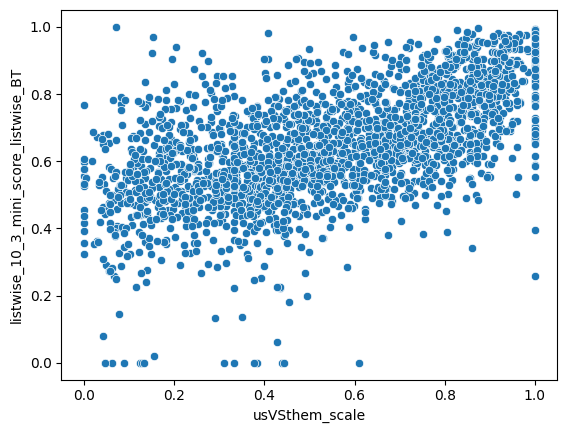

In [19]:
sns.scatterplot(data=df_usvsthem, x="usVSthem_scale", y="listwise_10_3_mini_score_listwise_BT")

<>:19: SyntaxWarning: invalid escape sequence '\_'
<>:19: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipython-input-233826540.py:19: SyntaxWarning: invalid escape sequence '\_'
  ax.set(xlabel='Us vs. Them label', ylabel=u"$mini\_listwise_{BT}$")


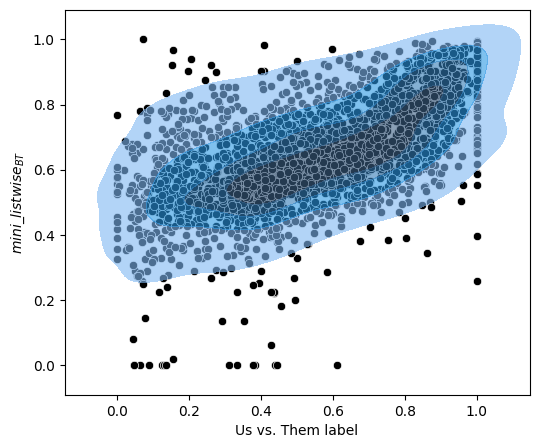

In [39]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    data=df_usvsthem,
    x="usVSthem_scale",
    y="listwise_10_3_mini_score_listwise_BT",
    color="k",
    ax=ax,
)
sns.kdeplot(
    data=df_usvsthem,
    x="usVSthem_scale",
    y="listwise_10_3_mini_score_listwise_BT",
    levels=5,
    fill=True,
    alpha=0.6,
    cut=2,
    ax=ax,
)
ax.set(xlabel='Us vs. Them label', ylabel=u"$mini\_listwise_{BT}$")
plt.show()

In [24]:
df_usvsthem

Unnamed: 0                                               body  \
0              0  Well yeah but then so does the Republican cong...   
1              1  Notice how when there's an article that hurts ...   
2              2  Right. Let’s launch back to back investigation...   
3              3  I'd love to see one media outlet like just com...   
4              4  look at the story of this perverse monster and...   
...          ...                                                ...   
2256        2256  Maybe we can reign in the ridiculous amount of...   
2257        2257  During their private White House meeting on Th...   
2258        2258  Funny how quickly people forget the Obama admi...   
2259        2259  HEY HEY HEY, AS A MAINER, I AM AN AUTHORITY ON...   
2260        2260  I understand why people want to live near exis...   

      usVSthem_scale  is_Disc_Crit          group          bias  Anger  \
0           0.803091          True  Conservatives          left  False   
1           0.018368         False  Conservatives  right-center  False   
2           0.822697          True       Liberals        center   True   
3           0.602182          True       Liberals          left   True   
4           0.906241          True       Refugees        center   True   
...              ...           ...            ...           ...    ...   
2256        0.567816         False           Jews          left  False   
2257        0.367621         False  Conservatives        center  False   
2258        0.410738         False        Muslims         right  False   
2259        0.953048          True  Conservatives        center   True   
2260        0.655735         False           Jews        center  False   

      Contempt  Disgust   Fear  ...  listwise_10_3_mini_score_listwise_elo  \
0         True     True  False  ...                            1602.915385   
1        False    False  False  ...                            1500.134155   
2         True    False  False  ...                            1550.212795   
3        False    False  False  ...                            1373.307829   
4        False     True  False  ...                            1641.362103   
...        ...      ...    ...  ...                                    ...   
2256     False    False  False  ...                            1648.809538   
2257     False    False  False  ...                            1424.004227   
2258     False    False  False  ...                            1388.088950   
2259      True    False  False  ...                            1676.212327   
2260     False    False  False  ...                            1585.140262   

      listwise_10_3_mini_promptTuned_score_listwise_BT  \
0                                             0.538133   
1                                             0.604282   
2                                             0.713572   
3                                             0.582829   
4                                             0.801912   
...                                                ...   
2256                                          0.818507   
2257                                          0.540080   
2258                                          0.627688   
2259                                          0.789878   
2260                                          0.845895   

      listwise_10_3_mini_promptTuned_score_listwise_elo  \
0                                           1485.494580   
1                                           1477.653498   
2                                           1542.553366   
3                                           1434.779245   
4                                           1648.663552   
...                                                 ...   
2256                                        1595.798306   
2257                                        1433.182754   
2258                                        1378.550798   
2259                                    

<>:3: SyntaxWarning: invalid escape sequence '\_'
<>:3: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipython-input-227331935.py:3: SyntaxWarning: invalid escape sequence '\_'
  jplot.set_axis_labels('Us vs. Them label', u"$mini\_listwise_{BT}$", fontsize=12)


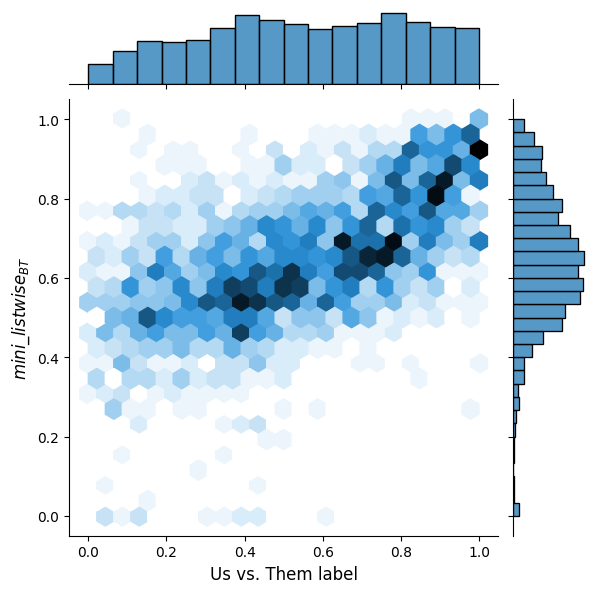

In [40]:
jplot = sns.jointplot(data=df_usvsthem, x="usVSthem_scale", y="listwise_10_3_mini_score_listwise_BT",  kind="hex")

jplot.set_axis_labels('Us vs. Them label', u"$mini\_listwise_{BT}$", fontsize=12)

In [ ]:
corr = df_usvsthem[df_usvsthem["bias"]=="left-center"][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr().usVSthem_scale
corr

usVSthem_scale                                         1.000000
baseline_5mini                                         0.605974
baseline_5mini_prompted                                0.614510
listwise_10_3_nano_score_listwise_elo01                0.342455
listwise_10_3_nano_score_listwise_BT                   0.363386
listwise_10_3_mini_score_listwise_elo01                0.535475
listwise_10_3_mini_score_listwise_BT                   0.560927
listwise_10_3_mini_promptTuned_score_listwise_elo01    0.550440
listwise_10_3_mini_promptTuned_score_listwise_BT       0.552466
Name: usVSthem_scale, dtype: float64

In [ ]:
corr = df_usvsthem[df_usvsthem["bias"]=="center"][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
corr = df_usvsthem[df_usvsthem["bias"]=="right-center"][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
corr = df_usvsthem[df_usvsthem["bias"]=="right"][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
corr = df_usvsthem[df_usvsthem["is_Disc_Crit"]==True][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()

corr
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

usVSthem_scale  \
usVSthem_scale                                            1.000000   
baseline_5mini                                            0.504709   
baseline_5mini_prompted                                   0.455122   
listwise_10_3_nano_score_listwise_elo01                   0.430789   
listwise_10_3_nano_score_listwise_BT                      0.459949   
listwise_10_3_mini_score_listwise_elo01                   0.501120   
listwise_10_3_mini_score_listwise_BT                      0.535698   
listwise_10_3_mini_promptTuned_score_listwise_e...        0.518533   
listwise_10_3_mini_promptTuned_score_listwise_BT          0.540623   

                                                    baseline_5mini  \
usVSthem_scale                                            0.504709   
baseline_5mini                                            1.000000   
baseline_5mini_prompted                                   0.812649   
listwise_10_3_nano_score_listwise_elo01                   0.563591   
listwise_10_3_nano_score_listwise_BT                      0.576294   
listwise_10_3_mini_score_listwise_elo01                   0.679985   
listwise_10_3_mini_score_listwise_BT                      0.730670   
listwise_10_3_mini_promptTuned_score_listwise_e...        0.697077   
listwise_10_3_mini_promptTuned_score_listwise_BT          0.733102   

                                                    baseline_5mini_prompted  \
usVSthem_scale                                                     0.455122   
baseline_5mini                                                     0.812649   
baseline_5mini_prompted                                            1.000000   
listwise_10_3_nano_score_listwise_elo01                            0.503600   
listwise_10_3_nano_score_listwise_BT                               0.511145   
listwise_10_3_mini_score_listwise_elo01                            0.638874   
listwise_10_3_mini_score_listwise_BT                               0.681827   
listwise_10_3_mini_promptTuned_score_listwise_e...                 0.678458   
listwise_10_3_mini_promptTuned_score_listwise_BT                   0.701971   

                                                    listwise_10_3_nano_score_listwise_elo01  \
usVSthem_scale                                                                     0.430789   
baseline_5mini                                                                     0.563591   
baseline_5mini_prompted                                                            0.503600   
listwise_10_3_nano_score_listwise_elo01                                            1.000000   
listwise_10_3_nano_score_listwise_BT                                               0.903397   
listwise_10_3_mini_score_listwise_elo01                                            0.685355   
listwise_10_3_mini_score_listwise_BT                                               0.730068   
listwise_10_3_mini_promptTuned_score_listwise_e...                                 0.652275   
listwise_10_3_mini_promptTuned_score_listwise_BT                                   0.703769   

                                                    listwise_10_3_nano_score_listwise_BT  \
usVSthem_scale                                                                  0.459949   
baseline_5mini                                                                  0.576294   
baseline_5mini_prompted                                                         0.511145   
listwise_10_3_nano_score_listwise_elo01                                         0.903397   
listwise_10_3_nano_score_listwise_BT                                            1.000000   
listwise_10_3_mini_score_listwise_elo01                                         0.723963   
listwise_10_3_mini_score_listwise_BT                                            0.776543   
listwise_10_3_mini_promptTuned_score_listwise_e...                              0.688390   
listwise_10_3_mini_promptTuned_score_listwise_BT                                

In [ ]:
corr = df_usvsthem[df_usvsthem["is_Disc_Crit"]==False][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()

corr
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

usVSthem_scale  \
usVSthem_scale                                            1.000000   
baseline_5mini                                            0.205429   
baseline_5mini_prompted                                   0.301509   
listwise_10_3_nano_score_listwise_elo01                   0.046331   
listwise_10_3_nano_score_listwise_BT                      0.062401   
listwise_10_3_mini_score_listwise_elo01                   0.218089   
listwise_10_3_mini_score_listwise_BT                      0.235319   
listwise_10_3_mini_promptTuned_score_listwise_e...        0.208876   
listwise_10_3_mini_promptTuned_score_listwise_BT          0.225113   

                                                    baseline_5mini  \
usVSthem_scale                                            0.205429   
baseline_5mini                                            1.000000   
baseline_5mini_prompted                                   0.797119   
listwise_10_3_nano_score_listwise_elo01                   0.484266   
listwise_10_3_nano_score_listwise_BT                      0.447738   
listwise_10_3_mini_score_listwise_elo01                   0.680093   
listwise_10_3_mini_score_listwise_BT                      0.673227   
listwise_10_3_mini_promptTuned_score_listwise_e...        0.654290   
listwise_10_3_mini_promptTuned_score_listwise_BT          0.646116   

                                                    baseline_5mini_prompted  \
usVSthem_scale                                                     0.301509   
baseline_5mini                                                     0.797119   
baseline_5mini_prompted                                            1.000000   
listwise_10_3_nano_score_listwise_elo01                            0.404335   
listwise_10_3_nano_score_listwise_BT                               0.386751   
listwise_10_3_mini_score_listwise_elo01                            0.646823   
listwise_10_3_mini_score_listwise_BT                               0.659488   
listwise_10_3_mini_promptTuned_score_listwise_e...                 0.648917   
listwise_10_3_mini_promptTuned_score_listwise_BT                   0.655453   

                                                    listwise_10_3_nano_score_listwise_elo01  \
usVSthem_scale                                                                     0.046331   
baseline_5mini                                                                     0.484266   
baseline_5mini_prompted                                                            0.404335   
listwise_10_3_nano_score_listwise_elo01                                            1.000000   
listwise_10_3_nano_score_listwise_BT                                               0.860274   
listwise_10_3_mini_score_listwise_elo01                                            0.535045   
listwise_10_3_mini_score_listwise_BT                                               0.545572   
listwise_10_3_mini_promptTuned_score_listwise_e...                                 0.496858   
listwise_10_3_mini_promptTuned_score_listwise_BT                                   0.512673   

                                                    listwise_10_3_nano_score_listwise_BT  \
usVSthem_scale                                                                  0.062401   
baseline_5mini                                                                  0.447738   
baseline_5mini_prompted                                                         0.386751   
listwise_10_3_nano_score_listwise_elo01                                         0.860274   
listwise_10_3_nano_score_listwise_BT                                            1.000000   
listwise_10_3_mini_score_listwise_elo01                                         0.503424   
listwise_10_3_mini_score_listwise_BT                                            0.543645   
listwise_10_3_mini_promptTuned_score_listwise_e...                              0.484195   
listwise_10_3_mini_promptTuned_score_listwise_BT                                

In [ ]:
corr = df_usvsthem[df_usvsthem["usVSthem_scale"]>=0.66][["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

In [ ]:
corr = df_usvsthem[["usVSthem_scale",
                    "baseline_5mini",
                    "baseline_5mini_prompted",
                    "listwise_10_3_nano_score_listwise_elo01",
                    "listwise_10_3_nano_score_listwise_BT",
                    "listwise_10_3_mini_score_listwise_elo01",
                    "listwise_10_3_mini_score_listwise_BT",
                    "listwise_10_3_mini_promptTuned_score_listwise_elo01",
                    "listwise_10_3_mini_promptTuned_score_listwise_BT"]].corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

<Axes: xlabel='usVSthem_scale', ylabel='score_listwise_BT'>

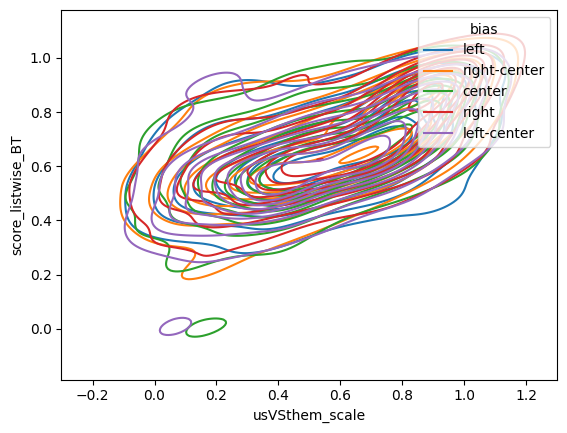

In [ ]:
sns.kdeplot(data=df_usvsthem, x="usVSthem_scale", y="score_listwise_BT", hue="bias")

In [ ]:
LLM_MODEL = "gpt-5-nano-2025-08-07"  # or your chosen judge

# 1) Pairwise comparator (for streak/prune Elo)
compare_fn = make_pairwise_comparator(
    llm_model=LLM_MODEL,
    temperature=1,
    vote_k=1,              # set 3 for extra robustness (higher cost)
    retries=2,
    max_chars_per_item=5000,
    seed=42,
)

# 2) Listwise ranker (for k-ary sorting + stitching)
listwise_ranker = make_listwise_ranker(
    llm_model=LLM_MODEL,
    temperature=1,
    retries=2,
    max_chars_per_item=5000,
    seed=42,
    prompt=default_listwise_system_prompt
)


# 1) Streak
elo, hist, labels = streak_early_stop_elo(test_babe_texts, compare_fn, save_path="/BABE/BABE200_3streak50.pkl", r=3)

# 2) Pruned Elo
elo, hist, pruned = pairwise_comparison_elo_prune(
    test_babe_texts, compare_fn, n_rounds=24, save_path="/BABE/BABE200_015pruned_12_24.pkl",
    match_strategy="similar", randomness_factor=0.1,
    prune_start_round=12, prune_percent=0.15
)

# 3) Listwise (multi-round)
elo, hist, meta = listwise_sort_and_merge_rounds(
    test_babe_texts, listwise_ranker, save_path="/BABE/BABE200_10listwise_4rounds.pkl",
    n_rounds=4, k=10, overlap=3, boundary_passes=1,
    grouping_strategy="similar", randomness_factor=0.1
)


NameError: name 'make_pairwise_comparator' is not defined

In [ ]:

# 4) Hybrid
elo, hist, meta = budgeted_hybrid_ranker(
    test_babe_texts, compare_fn, listwise_ranker, save_path="/BABE/hybrid_10list_8streak3_8prune.pkl",
    listwise_n_rounds=2, k=10, overlap=3, boundary_passes=1,
    grouping_strategy="similar", randomness_factor=0.1,
    streak_r=3, streak_min_distinct=3, streak_epochs=8,
    prune_rounds=8, prune_percent=0.15
)

In [ ]:
# baseline

elo_base, hist_base = baseline_single_item_assessment(
    test_babe_texts,
    save_path="/BABE/BABE200_baseline.pkl",
    llm_model=LLM_MODEL,
    temperature=1
)

# baseline full

elo_base_full, hist_base_full = baseline_single_item_assessment(
    babe_texts,
    save_path="/BABE/BABE_baseline.pkl",
    llm_model=LLM_MODEL,
    temperature=1
)

Baseline single-item LLM: 100%|██████████| 3674/3674 [01:01<00:00, 59.55it/s]


In [ ]:

# Listwise Full Dataset (multi-round)
elo, hist, meta = listwise_sort_and_merge_rounds(
    babe_texts, listwise_ranker, save_path="/BABE/BABE_10listwise_4rounds.pkl",
    n_rounds=4, k=10, overlap=3, boundary_passes=1,
    grouping_strategy="similar", randomness_factor=0.1
)

elo, hist, meta = listwise_sort_and_merge_rounds(
    babe_texts, listwise_ranker, save_path="/BABE/BABE_10listwise_6rounds.pkl",
    n_rounds=6, k=10, overlap=3, boundary_passes=1,
    grouping_strategy="similar", randomness_factor=0.1
)

Listwise rounds: 100%|██████████| 6/6 [14:55<00:00, 149.20s/it]


In [ ]:
# listwise ad absurdum: 10 and high k

elo, hist, meta = listwise_sort_and_merge_rounds(
    babe_texts, listwise_ranker, save_path="/BABE/BABE_10listwise_10rounds_k64.pkl",
    n_rounds=10, k=10, overlap=3, boundary_passes=1,k_factor=64,
    grouping_strategy="similar", randomness_factor=0.1
)

Listwise rounds: 100%|██████████| 10/10 [38:32<00:00, 231.25s/it]


In [ ]:
listwise_ranker = make_listwise_ranker(
    llm_model=LLM_MODEL,
    temperature=1,
    retries=2,
    max_chars_per_item=5000,
    seed=42,
    prompt=default_listwise_system_prompt
)

elo, hist, meta = listwise_sort_and_merge_rounds(
    test_babe_texts, listwise_ranker, save_path="/BABE/BABE200_10listwise_6rounds.pkl",
    n_rounds=6, k=10, overlap=3, boundary_passes=1,
    grouping_strategy="similar", randomness_factor=0.1
)

Listwise rounds: 100%|██████████| 6/6 [04:36<00:00, 46.14s/it]


In [ ]:
# for comparing prompt effect

listwise_ranker = make_listwise_ranker(
    llm_model=LLM_MODEL,
    temperature=1,
    retries=2,
    max_chars_per_item=5000,
    seed=42,
    prompt=babe_listwise_system_prompt
)

elo, hist, meta = listwise_sort_and_merge_rounds(
    test_babe_texts, listwise_ranker, save_path="/BABE/BABE200_10listwise_6rounds_BABE_Prompt.pkl",
    n_rounds=6, k=10, overlap=3, boundary_passes=1,
    grouping_strategy="similar", randomness_factor=0.1
)

Listwise rounds: 100%|██████████| 6/6 [05:30<00:00, 55.06s/it]


### run BABE

In [ ]:
scorer = make_openai_direct_bias_scalar_scorer(
    model="gpt-5-mini-2025-08-07",  # or "gpt-4o-mini"
    max_workers=64,
    max_tokens=16
)
scores_noPromttuning = scorer(babe_texts)


In [ ]:
with open("/BABE/5mini_baseline_contin.pkl", 'wb') as f:
    pickle.dump(scores_noPromttuning, f)

In [ ]:
scorer = make_openai_direct_bias_scalar_scorer(
    model="gpt-5-nano-2025-08-07",  # or "gpt-4o-mini"
    max_workers=64,
    max_tokens=16
)
scores_noPromttuning = scorer(babe_texts)


KeyboardInterrupt: 

In [ ]:
with open("/BABE/5nano_baseline_contin.pkl", 'wb') as f:
    pickle.dump(scores_noPromttuning, f)

In [ ]:
df_babe["baseline_5nano"] = df_babe.text.map(scores_noPromttuning)

In [ ]:
# 1) Prepare your texts
babe_texts  # list[str], your dataset
# ranker = make_openai_listwise_ranker(model="gpt-5-nano-2025-08-07")
ranker = make_openai_id_ranker(model="gpt-5-mini-2025-08-07")
cfg = ListwiseConfig(n_rounds=3, k=10, seed=123, k_factor=32)

elo_scores, bt_theta, bt_theta_01, match_history = listwise_then_bt(
    babe_texts,
    listwise_rank_by_ids=ranker,
    config=cfg
)

In [ ]:
with open("/BABE/5mini_10listwise3_clean.pkl", 'wb') as f:
    pickle.dump([elo_scores, bt_theta, bt_theta_01, match_history], f)

In [ ]:
with open("/BABE/5mini_10listwise3_clean.pkl", 'rb') as f:
    elo_scores, bt_theta, bt_theta_01, match_history = pickle.load(f)

In [ ]:
elo_by_text = {babe_texts[i]: v for i, v in elo_scores.items()}
bt_theta_by_text = {babe_texts[i]: v for i, v in bt_theta.items()}
bt01_by_text = {babe_texts[i]: v for i, v in bt_theta_01.items()}

In [ ]:
df_babe["10listwise3_bt"] = df_babe.text.map(bt01_by_text)
df_babe["10listwise3_theta"] = df_babe.text.map(bt_theta_by_text)
df_babe["10listwise3_elo"] = df_babe.text.map(elo_by_text)

In [ ]:
# 1) Prepare your texts
babe_texts  # list[str], your dataset
# ranker = make_openai_listwise_ranker(model="gpt-5-nano-2025-08-07")
ranker = make_openai_id_ranker(model="gpt-5-nano-2025-08-07")
cfg = ListwiseConfig(n_rounds=3, k=10, seed=123, k_factor=32)

elo_scores, bt_theta, bt_theta_01, match_history = listwise_then_bt(
    babe_texts,
    listwise_rank_by_ids=ranker,
    config=cfg
)

In [ ]:
with open("/BABE/5mini_10listwise3_nano_clean.pkl", 'wb') as f:
    pickle.dump([elo_scores, bt_theta, bt_theta_01, match_history], f)

In [ ]:
elo_by_text = {babe_texts[i]: v for i, v in elo_scores.items()}
bt_theta_by_text = {babe_texts[i]: v for i, v in bt_theta.items()}
bt01_by_text = {babe_texts[i]: v for i, v in bt_theta_01.items()}

In [ ]:
df_babe["10listwise3_nano_bt"] = df_babe.text.map(bt01_by_text)
df_babe["10listwise3_nano_theta"] = df_babe.text.map(bt_theta_by_text)
df_babe["10listwise3_nano_elo"] = df_babe.text.map(elo_by_text)

In [ ]:
round(df_babe["10listwise3_theta"].median(),2)

0.96

## Results

### pairwise comparison results

In [ ]:
# loading all comparison data
with open("/elo_full_par_41mini_12round_rnd01_init1500_k32.pkl", 'rb') as f:
    elo_scores_par_41mini_12round_rnd01_init1500_k32 = pickle.load(f)["elo_scores"]
with open("/elo_full_par_41nano_12round_rnd01_init1500_k32.pkl", 'rb') as f:
    elo_scores_par_41nano_12round_rnd01_init1500_k32 = pickle.load(f)["elo_scores"]
with open("/elo_full_par_41nano_24round_rnd01_init1500_k32.pkl", 'rb') as f:
    elo_scores_par_41nano_24round_rnd01_init1500_k32 = pickle.load(f)["elo_scores"]
with open("/elo_full_par_41mini_24round_rnd01_init1500_k32.pkl", 'rb') as f:
    elo_scores_par_41mini_24round_rnd01_init1500_k32 = pickle.load(f)["elo_scores"]

with open("/BABE/test_BABE_elo_scores_par_5mini_12round_rnd1_init1500_k32.pkl", 'rb') as f:
    test_BABE_elo_scores_par_5mini_12round_rnd1_init1500_k32 = pickle.load(f)
with open("/BABE/test_BABE_elo_scores_par_5nano_12round_rnd1_init1500_k32.pkl", 'rb') as f:
    test_BABE_elo_scores_par_5nano_12round_rnd1_init1500_k32 = pickle.load(f)
with open("/BABE/test_BABE_elo_scores_par_5nano_12round_rnd01_init1500_k32.pkl", 'rb') as f:
    test_BABE_elo_scores_par_5nano_12round_init1500_k32 = pickle.load(f)
with open("/BABE/test_BABE_elo_scores_par_5nano_12round_rnd01_init1500_k32.pkl", 'rb') as f:
    test_BABE_elo_scores_par_5nano_12round_rnd01_init1500_k32 = pickle.load(f)
with open("/BABE/test_BABE_elo_scores_par_5nano_24round_rnd1_init1500_k32.pkl", 'rb') as f:
    test_BABE_elo_scores_par_5nano_24round_rnd1_init1500_k32 = pickle.load(f)
with open("/BABE/test_BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl", 'rb') as f:
    test_BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32 = pickle.load(f)

# performance optimisation tests

with open("/BABE/BABE200_3streak50.pkl", 'rb') as f:
    BABE200_3streak50 = pickle.load(f)
with open("/BABE/BABE200_015pruned_12_24.pkl", 'rb') as f:
    BABE200_015pruned = pickle.load(f)
with open("/BABE/BABE200_10listwise_4rounds.pkl", 'rb') as f:
    BABE200_10listwise_4rounds = pickle.load(f)
with open("/BABE/BABE200_10listwise_6rounds.pkl", 'rb') as f:
    BABE200_10listwise_6rounds = pickle.load(f)
with open("/BABE/BABE200_10listwise_6rounds_BABE_Prompt.pkl", 'rb') as f:
    BABE200_10listwise_6rounds_BABE_Prompt = pickle.load(f)

# full
with open("/BABE/BABE_10listwise_4rounds.pkl", 'rb') as f:
    BABE_10listwise_4rounds = pickle.load(f)
with open("/BABE/BABE_10listwise_6rounds.pkl", 'rb') as f:
    BABE_10listwise_6rounds = pickle.load(f)
with open("/BABE/BABE_10listwise_10rounds_k64.pkl", 'rb') as f:
    BABE_10listwise_10rounds_k64 = pickle.load(f)
with open("/BABE/BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl", 'rb') as f:
    BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32 = pickle.load(f)

# baselines
with open("/BABE/BABE_baseline.pkl", 'rb') as f:
    BABE_baseline = pickle.load(f)
with open("/BABE/BABE200_baseline.pkl", 'rb') as f:
    BABE200_baseline = pickle.load(f)

In [ ]:
df_babe["5mini_baseline_contin"] = df_babe["text"].map(scores_noPromttuning)

In [ ]:
df_babe

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0                0             0             0           0   
1                1             1             1           1   
2                2             2             2           2   
3                3             3             3           3   
4                4             4             4           4   
...            ...           ...           ...         ...   
3669          3669          3669          3669        3669   
3670          3670          3670          3670        3670   
3671          3671          3671          3671        3671   
3672          3672          3672          3672        3672   
3673          3673          3673          3673        3673   

                                                   text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3669  You’ve heard of Jim Crow and Southern Segregat...   
3670  Young female athletes’ dreams and accomplishme...   
3671  Young white men, reacting to social and educat...   
3672  Young women taking part in high school and col...   
3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3669  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3670  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3671  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3672                                                NaN   Breitbart   
3673  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  ...  \
0           environment   right  Non-biased  ...   
1           gun control    left      Biased  ...   
2     white-nationalism    left      Biased  ...   
3     white-nationalism    left      Biased  ...   
4     marriage-equality     NaN      Biased  ...   
...                 ...     ...         ...  ...   
3669  marriage-equality     NaN      Biased  ...   
3670  marriage-equality     NaN      Biased  ...   
3671  white-nationalism   right      Biased  ...   
3672              sport   right      Biased  ...   
3673     elections-2020  center      Biased  ...   

     bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo fleiss_kappa  \
0                                             80.960516        -0.200474   
1                                           1697.014345         1.000000   
2                                           2326.562624         0.199684   
3                                           2959.454025        -0.200474   
4                                           3751.820856         0.199684   
...                                                 ...              ...   
3669                                        3111.967681        -0.200474   
3670                                        3192.876193         1.000000   
3671                                        2571.707398         0.199684   
3672                                        3025.667928         0.199684   
3673                                         872.514678        -0.200474   

      bt_10listwise_4rounds_elo_label  bt_10listwise_6rounds_elo_label  \
0                          non-biased                       non-biased   
1            

In [ ]:
def translate_bias(v):
  if v <0.5:
    return "non-biased"
  else:
    return "biased"

In [ ]:
df_babe["5baseline_contin_bias"] = df_babe["5mini_baseline_contin"].map(translate_bias)

In [ ]:
df_babe.to_csv("/BABE/df_babe_new_baseline.csv")

In [ ]:
df_babe = pd.read_csv("/BABE/df_babe_new_baseline.csv")

In [ ]:
df_babe["5baseline_contin_bias"].value_counts()

5baseline_contin_bias
non-biased    1939
biased        1735
Name: count, dtype: int64

In [ ]:
df_babe = pd.read_csv("/BABE/df_babe.csv")

In [ ]:
df_babe

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0                0             0             0           0   
1                1             1             1           1   
2                2             2             2           2   
3                3             3             3           3   
4                4             4             4           4   
...            ...           ...           ...         ...   
3669          3669          3669          3669        3669   
3670          3670          3670          3670        3670   
3671          3671          3671          3671        3671   
3672          3672          3672          3672        3672   
3673          3673          3673          3673        3673   

                                                   text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3669  You’ve heard of Jim Crow and Southern Segregat...   
3670  Young female athletes’ dreams and accomplishme...   
3671  Young white men, reacting to social and educat...   
3672  Young women taking part in high school and col...   
3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3669  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3670  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3671  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3672                                                NaN   Breitbart   
3673  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  ...  \
0           environment   right  Non-biased  ...   
1           gun control    left      Biased  ...   
2     white-nationalism    left      Biased  ...   
3     white-nationalism    left      Biased  ...   
4     marriage-equality     NaN      Biased  ...   
...                 ...     ...         ...  ...   
3669  marriage-equality     NaN      Biased  ...   
3670  marriage-equality     NaN      Biased  ...   
3671  white-nationalism   right      Biased  ...   
3672              sport   right      Biased  ...   
3673     elections-2020  center      Biased  ...   

     bt_10listwise_10rounds_k64_elo  \
0                        731.239388   
1                       1607.102107   
2                       1925.220498   
3                       2663.499264   
4                       3213.107675   
...                             ...   
3669                    2721.454596   
3670                    2426.017654   
3671                    1648.025535   
3672                    2232.458582   
3673                     915.789884   

     bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo  fleiss_kappa  \
0                                             80.960516         -0.200474   
1                                           1697.014345          1.000000   
2                                           2326.562624          0.199684   
3                                           2959.454025         -0.200474   
4                                           3751.820856          0.199684   
...                                                 ...               ...   
3669                                        3111.967681         -0

### BT scores

In [ ]:
# ===== Bradley–Terry from logs (drop-in) =====
import os, pickle, math
from typing import Iterable, List, Tuple, Dict, Any, Optional
import numpy as np

# ---------- core MM solver ----------
def _bt_fit_theta(pairs: Iterable[Tuple[int,int,float]], n_items: int,
                  *, tie_split: float = 0.5, l2: float = 1e-6,
                  max_iter: int = 2000, tol: float = 1e-9) -> Optional[np.ndarray]:
    """
    pairs: iterable of (i, j, y) with y in {1,0,0.5} meaning i>j, j>i, tie
    Returns centered theta (mean=0) or None if no pairs.
    """
    pairs = list(pairs)
    if not pairs:
        return None

    W = np.zeros((n_items, n_items), dtype=float)  # wins of i over j
    M = np.zeros((n_items, n_items), dtype=float)  # matches between i and j
    for (i, j, y) in pairs:
        if i == j:
            continue
        if y == 1.0:
            W[i, j] += 1.0; M[i, j] += 1.0; M[j, i] += 1.0
        elif y == 0.0:
            W[j, i] += 1.0; M[i, j] += 1.0; M[j, i] += 1.0
        else:  # tie
            W[i, j] += tie_split
            W[j, i] += tie_split
            M[i, j] += 1.0; M[j, i] += 1.0

    w_i = W.sum(axis=1)
    m_ij = W + W.T  # symmetric match counts
    pi = (w_i + 1.0).astype(float)  # init

    eps = 1e-12
    for _ in range(max_iter):
        denom = np.zeros_like(pi)
        for i in range(n_items):
            js = np.nonzero(m_ij[i])[0]
            if js.size:
                denom[i] = np.sum(m_ij[i, js] / (pi[i] + pi[js]))
            denom[i] += l2
        numer = w_i + l2
        pi_new = numer / np.maximum(denom, eps)
        # normalize scale (identifiability)
        gmean = np.exp(np.mean(np.log(np.maximum(pi_new, eps))))
        pi_new /= gmean
        if np.max(np.abs(pi_new - pi)) < tol * max(1.0, np.max(pi)):
            pi = pi_new
            break
        pi = pi_new

    theta = np.log(np.maximum(pi, eps))
    theta -= theta.mean()
    return theta

def _bt_to_elo(theta: np.ndarray, center: float = 1500.0) -> np.ndarray:
    """Map BT scores to Elo-like scale (same logistic slope)."""
    K = 400.0 / math.log(10.0)  # ≈ 173.7178
    return center + K * (theta - theta.mean())

# ---------- log parsing ----------
def _safe_load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)

def _extract_elo_and_history(obj: Any):
    """
    Accepts:
      - dict with keys {"elo_scores", "match_history"}
      - tuple/list like (elo_scores, match_history)
    """
    if isinstance(obj, dict) and "elo_scores" in obj and "match_history" in obj:
        return obj["elo_scores"], obj["match_history"]
    if isinstance(obj, (tuple, list)) and len(obj) >= 2:
        return obj[0], obj[1]
    raise ValueError("Unrecognized log format. Expected dict{elo_scores,match_history} or (elo_scores, match_history).")

def _collect_all_texts(match_history) -> List[str]:
    texts = set()
    for rnd in match_history:
        entries = rnd if isinstance(rnd, list) else [rnd]
        for e in entries:
            if not isinstance(e, dict):
                continue
            # pairwise-style
            t1 = e.get("text1"); t2 = e.get("text2")
            if isinstance(t1, str): texts.add(t1)
            if isinstance(t2, str): texts.add(t2)
            # listwise permutations
            for key in ("perm","permutation","ranking","ranked_texts","ordered"):
                if key in e and isinstance(e[key], (list,tuple)):
                    for t in e[key]:
                        if isinstance(t, str): texts.add(t)
            # explicit edges
            for key in ("edges","pairwise_edges","wins"):
                if key in e and isinstance(e[key], (list,tuple)):
                    for edge in e[key]:
                        if isinstance(edge, (list,tuple)) and len(edge) >= 2:
                            a,b = edge[0], edge[1]
                            if isinstance(a,str): texts.add(a)
                            if isinstance(b,str): texts.add(b)
    return sorted(texts)

def _pairs_from_history(match_history, id_by_text: Dict[str,int]) -> List[Tuple[int,int,float]]:
    pairs: List[Tuple[int,int,float]] = []
    for rnd in match_history:
        entries = rnd if isinstance(rnd, list) else [rnd]
        for e in entries:
            if not isinstance(e, dict):
                continue
            # pairwise record
            if "text1" in e and "text2" in e and "winner" in e:
                a, b, w = e.get("text1"), e.get("text2"), e.get("winner")
                if a is None or b is None:
                    continue
                i, j = id_by_text[a], id_by_text[b]
                if w is None or w == "tie":
                    y = 0.5
                elif w == a or w == "text1":
                    y = 1.0
                elif w == b or w == "text2":
                    y = 0.0
                else:
                    continue
                pairs.append((i, j, y))
            # listwise permutations -> expand earlier-beats-later
            for key in ("perm","permutation","ranking","ranked_texts","ordered"):
                if key in e and isinstance(e[key], (list,tuple)):
                    perm = [t for t in e[key] if isinstance(t, str)]
                    for a in range(len(perm)):
                        for b in range(a+1, len(perm)):
                            i, j = id_by_text[perm[a]], id_by_text[perm[b]]
                            pairs.append((i, j, 1.0))
            # explicit edges [(winner, loser[, weight])]
            for key in ("edges","pairwise_edges","wins"):
                if key in e and isinstance(e[key], (list,tuple)):
                    for edge in e[key]:
                        if isinstance(edge, (list,tuple)) and len(edge) >= 2:
                            a, b = edge[0], edge[1]
                            if not (isinstance(a,str) and isinstance(b,str)):
                                continue
                            i, j = id_by_text[a], id_by_text[b]
                            y = 1.0
                            if len(edge) >= 3 and isinstance(edge[2], (int,float)) and float(edge[2]) == 0.5:
                                y = 0.5
                            pairs.append((i, j, y))
    return pairs

# ---------- public API ----------
def bt_scores_from_log(path: str, *, scale: str = "elo",
                       tie_split: float = 0.5, l2: float = 1e-6,
                       verbose: bool = False) -> Dict[str, float]:
    """
    Compute BT scores from a single run log (pickle).
    scale: "elo" (default) for Elo-like scaling, or "theta" for raw BT scores.
    Returns: {text: score}
    """
    obj = _safe_load_pickle(path)
    elo_scores, match_history = _extract_elo_and_history(obj)

    # universe of items
    texts = set()
    if isinstance(elo_scores, dict):
        texts.update(t for t in elo_scores.keys() if isinstance(t, str))
    texts.update(_collect_all_texts(match_history))
    texts = sorted(texts)
    id_by_text = {t:i for i,t in enumerate(texts)}

    pairs = _pairs_from_history(match_history, id_by_text)
    if verbose:
        print(f"[BT] {os.path.basename(path)}: {len(texts)} items, {len(pairs)} pairwise outcomes")

    theta = _bt_fit_theta(pairs, n_items=len(texts), tie_split=tie_split, l2=l2)
    if theta is None:
        return {t: float("nan") for t in texts}

    if scale == "elo":
        scores = _bt_to_elo(theta)
    elif scale == "theta":
        scores = theta
    else:
        raise ValueError("scale must be 'elo' or 'theta'")

    return {t: float(scores[id_by_text[t]]) for t in texts}

def bt_scores_from_logs(paths: List[str], *, scale: str = "elo",
                        tie_split: float = 0.5, l2: float = 1e-6,
                        verbose: bool = False) -> Dict[str, float]:
    """
    Compute BT scores from **multiple** logs combined (union of all pairs).
    Returns: {text: score}
    """
    # First pass: collect all texts
    texts = set()
    objs = []
    for p in paths:
        obj = _safe_load_pickle(p); objs.append(obj)
        elo_scores, match_history = _extract_elo_and_history(obj)
        if isinstance(elo_scores, dict):
            texts.update(t for t in elo_scores.keys() if isinstance(t, str))
        texts.update(_collect_all_texts(match_history))
    texts = sorted(texts)
    id_by_text = {t:i for i,t in enumerate(texts)}

    # Second pass: collect all pairs
    all_pairs: List[Tuple[int,int,float]] = []
    for p, obj in zip(paths, objs):
        _, match_history = _extract_elo_and_history(obj)
        pr = _pairs_from_history(match_history, id_by_text)
        all_pairs.extend(pr)
        if verbose:
            print(f"[BT] {os.path.basename(p)}: +{len(pr)} pairs")

    if verbose:
        print(f"[BT] total: {len(texts)} items, {len(all_pairs)} pairwise outcomes across {len(paths)} logs")

    theta = _bt_fit_theta(all_pairs, n_items=len(texts), tie_split=tie_split, l2=l2)
    if theta is None:
        return {t: float("nan") for t in texts}

    scores = _bt_to_elo(theta) if scale == "elo" else theta
    return {t: float(scores[id_by_text[t]]) for t in texts}


In [ ]:
# Full Runs → dict{text: BT(theta)} (centered θ with mean 0), alternatively: scale="elo" for elo-like centered at 1500

bt_dict_10listwise_4rounds = bt_scores_from_log("/BABE/BABE_10listwise_4rounds.pkl", scale="theta", verbose=True)
bt_dict_10listwise_6rounds = bt_scores_from_log("/BABE/BABE_10listwise_6rounds.pkl", scale="theta", verbose=True)
bt_dict_10listwise_10rounds_k64 = bt_scores_from_log("/BABE/BABE_10listwise_10rounds_k64.pkl", scale="theta", verbose=True)
bt_dict_elo_scores_par_5nano_24round_rnd01_init1500_k32 = bt_scores_from_log("/BABE/BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl", scale="theta", verbose=True)



[BT] BABE_10listwise_4rounds.pkl: 3674 items, 88104 pairwise outcomes


KeyboardInterrupt: 

In [ ]:
bt_dict_10listwise_4rounds_elo = bt_scores_from_log("/BABE/BABE_10listwise_4rounds.pkl", scale="elo", verbose=True)
bt_dict_10listwise_6rounds_elo = bt_scores_from_log("/BABE/BABE_10listwise_6rounds.pkl", scale="elo", verbose=True)
bt_dict_10listwise_10rounds_k64_elo = bt_scores_from_log("/BABE/BABE_10listwise_10rounds_k64.pkl", scale="elo", verbose=True)
bt_dict_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo = bt_scores_from_log("/BABE/BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl", scale="elo", verbose=True)

[BT] BABE_10listwise_4rounds.pkl: 3674 items, 88104 pairwise outcomes
[BT] BABE_10listwise_6rounds.pkl: 3674 items, 132156 pairwise outcomes
[BT] BABE_10listwise_10rounds_k64.pkl: 3674 items, 220260 pairwise outcomes
[BT] BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl: 3674 items, 44088 pairwise outcomes


In [ ]:
BABE_baseline_labels = {}
for key in BABE_baseline["raw_assessments"].keys():
  text_a = babe_texts[key]
  BABE_baseline_labels[text_a] = BABE_baseline["raw_assessments"][key]["biased"]
BABE_baseline_severity = {}
for key in BABE_baseline["raw_assessments"].keys():
  text_a = babe_texts[key]
  BABE_baseline_severity[text_a] = BABE_baseline["raw_assessments"][key]["severity"]

### agreement analysis

In [ ]:
def elorange (score):
  if score < 1400:
    return "non-biased"
  elif score > 1600:
    return "biased"
  else:
    return "center"

def elorange_bin (score):
  if score < 1500:
    return "non-biased"
  else:
    return "biased"

def elorange_tight (score):
  if score < 1450:
    return "non-biased"
  elif score > 1550:
    return "biased"
  else:
    return "center"

def calc_distance (elo):
  return abs(1500-elo)

def calc_baseline_elo (severity):
  return 1499 + 500 * severity

In [ ]:
df_babe["elo_scores_10_listwise"] = df_babe["text"].map(BABE_10listwise_6rounds["elo_scores"])
df_babe["elo_scores_5nano_24"] = df_babe["text"].map(BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32["elo_scores"])
df_babe["label_10_listwise"] = df_babe["elo_scores_10_listwise"].map(elorange_bin)
df_babe["label_5nano_24"] = df_babe["elo_scores_5nano_24"].map(elorange_bin)
df_babe["elo_5nano_distance"] = df_babe["elo_scores_5nano_24"].map(calc_distance)
df_babe["elo_10_distance"] = df_babe["elo_scores_10_listwise"].map(calc_distance)
df_babe["label_5nano_binary"] = df_babe["elo_scores_5nano_24"].map(elorange_bin)
df_babe["label_10_binary"] = df_babe["elo_scores_10_listwise"].map(elorange_bin)
df_babe["baseline_labels"] = df_babe["text"].map(BABE_baseline_labels)
df_babe["baseline_severity"] = df_babe["text"].map(BABE_baseline_severity)
df_babe["baseline_elo"] = df_babe["baseline_severity"].map(calc_baseline_elo)

NameError: name 'BABE_baseline_labels' is not defined

In [ ]:
df_babe["bt_10listwise_4rounds"] = df_babe["text"].map(bt_dict_10listwise_4rounds)
df_babe["bt_10listwise_6rounds"] = df_babe["text"].map(bt_dict_10listwise_6rounds)
df_babe["bt_10listwise_10rounds_k64"] = df_babe["text"].map(bt_dict_10listwise_10rounds_k64)
df_babe["bt_elo_scores_par_5nano_24round_rnd01_init1500_k32"] = df_babe["text"].map(bt_dict_elo_scores_par_5nano_24round_rnd01_init1500_k32)

df_babe["bt_10listwise_4rounds_elo"] = df_babe["text"].map(bt_dict_10listwise_4rounds_elo)
df_babe["bt_10listwise_6rounds_elo"] = df_babe["text"].map(bt_dict_10listwise_6rounds_elo)
df_babe["bt_10listwise_10rounds_k64_elo"] = df_babe["text"].map(bt_dict_10listwise_10rounds_k64_elo)
df_babe["bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo"] = df_babe["text"].map(bt_dict_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo)


NameError: name 'bt_dict_10listwise_4rounds' is not defined

In [ ]:
df_babe["bt_10listwise_4rounds_elo_label"] = df_babe["bt_10listwise_4rounds_elo"].apply(elorange_bin)
df_babe["bt_10listwise_6rounds_elo_label"] = df_babe["bt_10listwise_6rounds_elo"].apply(elorange_bin)
df_babe["bt_10listwise_10rounds_k64_elo_label"] = df_babe["bt_10listwise_10rounds_k64_elo"].apply(elorange_bin)
df_babe["bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo_label"] = df_babe["bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo"].apply(elorange_bin)

In [ ]:
df_babe.to_csv("/BABE/df_babe.csv")

In [ ]:
df_babe = pd.read_csv("/BABE/df_babe.csv")

### EM threshold

In [ ]:
def em_threshold(scores, n_init=4, max_iter=500, tol=1e-6,
                 var_floor=1e-6, prior_beta=None,
                 enforce_mu1_gt_mu0=True,
                 cost_fp=1.0, cost_fn=1.0,
                 return_params=False,
                 random_state=0,        # <- NEW
                 equal_var=True,        # <- NEW
                 pi_bounds=(0.05,0.50)  # <- NEW
                 ):
    rng = np.random.default_rng(random_state)
    x = np.asarray(scores, float); x = x[np.isfinite(x)]
    n = x.size; vglob = float(np.var(x)) or 1.0
    var_floor = max(var_floor, 0.02 * vglob)  # scale-aware floor

    best = None
    # deterministic first init + a few jittered restarts
    inits = [(0.35, 0.85)] + [(0.30+rng.uniform(-0.05,0.05),
                               0.85+rng.uniform(-0.05,0.05)) for _ in range(max(1, n_init-1))]
    for q0, q1 in inits:
        mu0 = float(np.quantile(x, np.clip(q0, 0.05, 0.95)))
        mu1 = float(np.quantile(x, np.clip(q1, 0.05, 0.95)))
        if mu1 <= mu0: mu0, mu1 = mu1-1e-3, mu1+1e-3
        s0 = s1 = math.sqrt(max(vglob, var_floor))
        pi = 0.30

        prev_ll = -np.inf
        for _ in range(max_iter):
            logp1 = np.log(pi)   + np.array([_log_gauss(xi, mu1, s1) for xi in x])
            logp0 = np.log(1-pi) + np.array([_log_gauss(xi, mu0, s0) for xi in x])
            logden = np.array([_logsumexp(a, b) for a, b in zip(logp1, logp0)])
            r = np.exp(logp1 - logden)

            r_sum = float(np.sum(r)); r_comp = n - r_sum
            r_sum  = max(r_sum, 1e-8); r_comp = max(r_comp, 1e-8)

            mu1 = float(np.sum(r * x) / r_sum)
            mu0 = float(np.sum((1-r) * x) / r_comp)

            if equal_var:
                pooled = (np.sum(r*(x-mu1)**2) + np.sum((1-r)*(x-mu0)**2)) / n
                s0 = s1 = math.sqrt(max(pooled, var_floor))
            else:
                s1 = math.sqrt(max(np.sum(r*(x-mu1)**2) / r_sum, var_floor))
                s0 = math.sqrt(max(np.sum((1-r)*(x-mu0)**2) / r_comp, var_floor))

            if prior_beta is None:
                pi_ml = r_sum / n
                if pi_bounds: lo, hi = pi_bounds; pi = min(max(pi_ml, lo), hi)
                else: pi = min(max(pi_ml, 1e-6), 1-1e-6)
            else:
                a,b = prior_beta; pi = (r_sum + a - 1) / (n + a + b - 2)
                pi = min(max(pi, 1e-6), 1-1e-6)

            if enforce_mu1_gt_mu0 and mu1 < mu0:
                mu0, mu1, s0, s1, pi = mu1, mu0, s1, s0, 1-pi

            ll = float(np.sum(logden))
            if abs(ll - prev_ll) <= tol*(1+abs(prev_ll)): break
            prev_ll = ll

        sep = abs(mu1-mu0) / math.sqrt(0.5*(s0**2 + s1**2))
        score = (prev_ll, sep, -abs(pi - np.clip(pi, *pi_bounds)))  # tie-breakers
        if best is None or score > best[0]:
            best = (score, dict(mu0=mu0,s0=s0,mu1=mu1,s1=s1,pi=pi))

    params = best[1]
    tau = _solve_threshold(params["mu0"], params["s0"], params["mu1"], params["s1"], params["pi"],
                           cost_fp=cost_fp, cost_fn=cost_fn)
    return (tau, params) if return_params else tau


In [ ]:
tau, params = em_threshold(df_babe.bt_10listwise_10rounds_k64_elo.to_list(), prior_beta=None, return_params=True)
print(f"Threshold (posterior tie): {tau:.3f}")
print("Fitted params:", params)


Threshold (posterior tie): 1626.976
Fitted params: {'mu0': 1159.2885883147305, 's0': 494.0179889805869, 'mu1': 1889.6534376593115, 's1': 617.7365080301308, 'pi': 0.46649481008159005}


In [ ]:
tau, params = em_threshold(df_babe.bt_10listwise_10rounds_k64_elo.to_list(), prior_beta=None, return_params=True)
df_babe["BT_listwise_pred_label_EM"] = df_babe["bt_10listwise_10rounds_k64_elo"].apply(lambda x: "biased" if x > tau else "non-biased")
print(tau)

tau, params = em_threshold(df_babe.bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo.to_list(), prior_beta=None, return_params=True)
df_babe["BT_5nano24r_pred_label_EM"] = df_babe["bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo"].apply(lambda x: "biased" if x > tau else "non-biased")
print(tau)

1991.706029983854
2330.2978422877686


In [ ]:
tau

2295.6112863672383

In [ ]:
df_babe["BT_5nano24r_pred_label_EM"].value_counts()

BT_5nano24r_pred_label_EM
non-biased    2438
biased        1236
Name: count, dtype: int64

<Axes: ylabel='Density'>

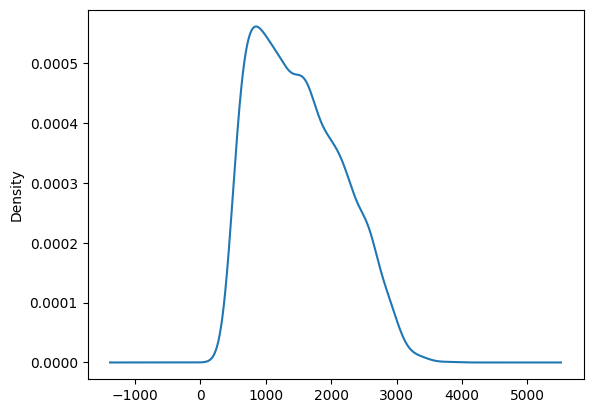

In [ ]:
df_babe.bt_10listwise_10rounds_k64_elo.plot(kind="kde")

<Axes: ylabel='Frequency'>

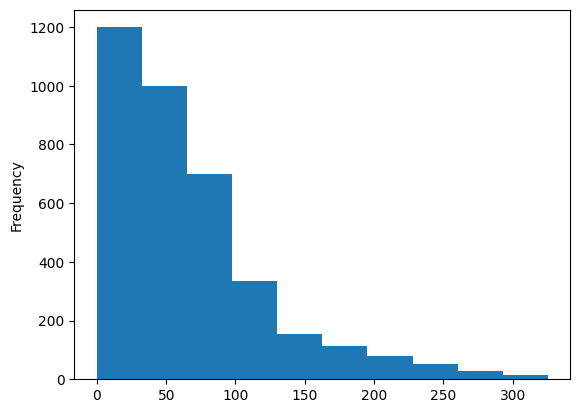

In [ ]:
df_babe.elo_5nano_distance.plot(kind="hist")

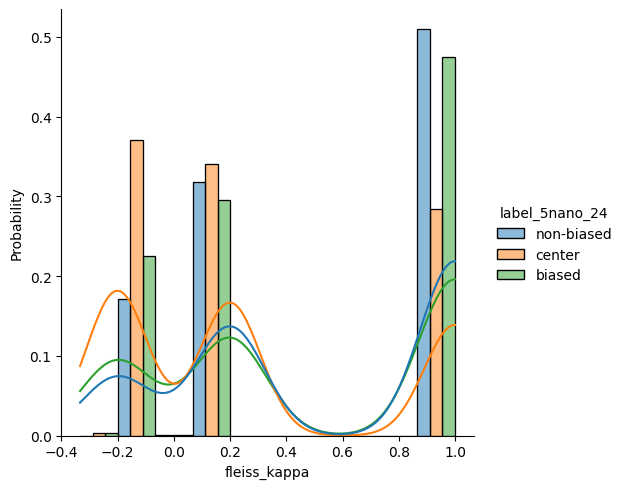

In [ ]:
sns.displot(df_babe, x="fleiss_kappa", hue="label_5nano_24", multiple="dodge", stat="probability", bins=10, kde=True, common_norm=False)

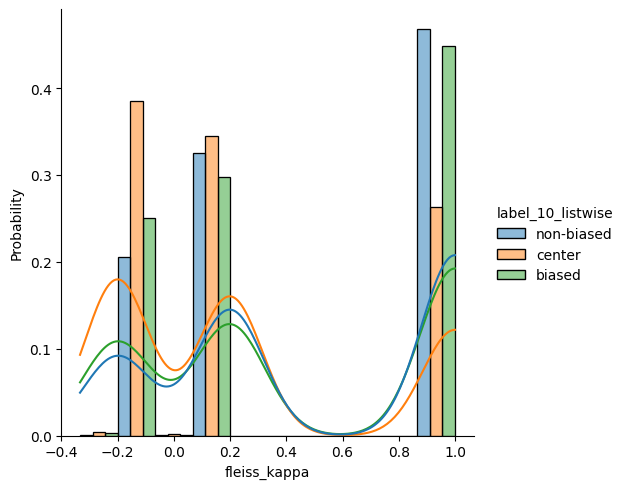

In [ ]:
sns.displot(df_babe, x="fleiss_kappa", hue="label_10_listwise", multiple="dodge", stat="probability", bins=10, kde=True, common_norm=False)

<Figure size 1000x600 with 0 Axes>

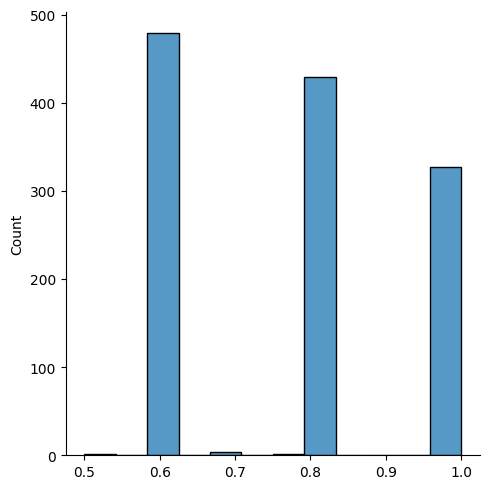

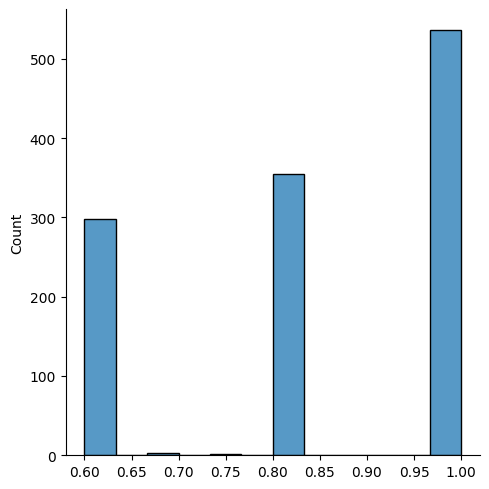

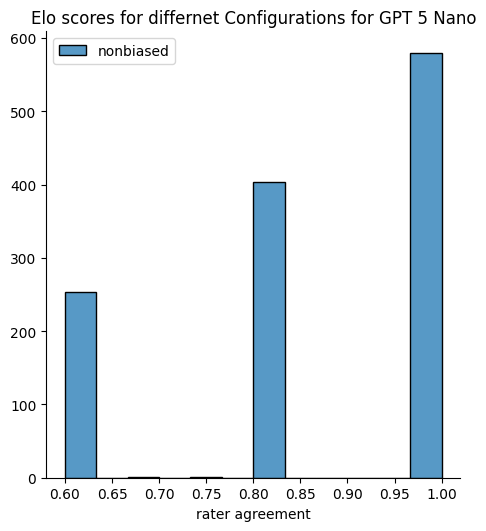

In [ ]:
# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

# Plot agreement
sns.displot(def_center.agreement.to_list(), label='center')
sns.displot(def_biased.agreement.to_list(), label='biased')
sns.displot(def_nonbiased.agreement.to_list(), label='nonbiased')


# Add titles and labels
#plt.title('Density Plot of ELO Scores for different configurations')
plt.xlabel('rater agreement')
plt.ylabel('')

# Add a legend
plt.title("Elo scores for differnet Configurations for GPT 5 Nano")
plt.legend()

# Show the plot
plt.show()

### classificationa quality by bias type

In [ ]:
def con_yesno(inp):
  if inp == "yes":
    return "biased"
  else:
    return "non-biased"

df_babe["label_baseline"] = df_babe["baseline_labels"].map(con_yesno)

In [ ]:
df_babe.label_baseline.value_counts()

label_baseline
biased        2080
non-biased    1594
Name: count, dtype: int64

In [ ]:
df_babe.label_bias.value_counts()

label_bias
Non-biased      1863
Biased          1810
No agreement       1
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import f1_score
df_babe_clean = df_babe.loc[df_babe["label_bias"] != "No agreement"]
df_babe_clean["label_bias"] =  df_babe_clean["label_bias"].apply(lambda x: x.lower() if isinstance(x, str) else x)


from sklearn.metrics import precision_recall_fscore_support as prf

metrics_by_type_5nano = (
    df_babe_clean.dropna(subset=["label_bias", "label_5nano_binary"])
    .groupby("type")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1"],
                 prf(g["label_bias"], g["label_5nano_binary"], average="micro")))))
    .reset_index()
)
metrics_by_type_5nano["approach"] = "24 rounds 5nano"

metrics_by_type_10 = (
    df_babe_clean.dropna(subset=["label_bias", "label_10_binary"])
    .groupby("type")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1"],
                 prf(g["label_bias"], g["label_10_binary"], average="micro")))))
    .reset_index()
)

metrics_by_type_10["approach"] = "2 rounds 10-wise 5nano"

metrics_by_type_base = (
    df_babe_clean.dropna(subset=["label_bias", "label_baseline"])
    .groupby("type")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1"],
                 prf(g["label_bias"], g["label_baseline"], average="micro")))))
    .reset_index()
)

metrics_by_type_base["approach"] = "direct 5nano"

metrics_by_type = pd.concat([metrics_by_type_5nano, metrics_by_type_10, metrics_by_type_base])
metrics_by_type

/tmp/ipython-input-4145027041.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(
/tmp/ipython-input-4145027041.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(
/tmp/ipython-input-4145027041.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

type  precision    recall        f1                approach
0  center   0.819364  0.819364  0.819364         24 rounds 5nano
1    left   0.752275  0.752275  0.752275         24 rounds 5nano
2   right   0.710977  0.710977  0.710977         24 rounds 5nano
0  center   0.819364  0.819364  0.819364  2 rounds 10-wise 5nano
1    left   0.722952  0.722952  0.722952  2 rounds 10-wise 5nano
2   right   0.688822  0.688822  0.688822  2 rounds 10-wise 5nano
0  center   0.803468  0.803468  0.803468            direct 5nano
1    left   0.740142  0.740142  0.740142            direct 5nano
2   right   0.713998  0.713998  0.713998            direct 5nano

In [ ]:
from sklearn.metrics import confusion_matrix
df_babe_anal = df_babe.loc[(df_babe["label_bias"] == "biased") | (df_babe["label_bias"] == "non-biased")]

confusion_matrix(df_babe_anal.label_bias, df_babe_anal.label_5nano_24)

array([[844, 879,  87],
       [  0,   0,   0],
       [109, 884, 870]])

In [ ]:
df_babe_anal.label_5nano_24.value_counts()

label_5nano_24
center        1763
non-biased     957
biased         953
Name: count, dtype: int64

In [ ]:
# imports consolidated at top
df_babe_clean = df_babe.loc[df_babe["label_bias"] != "No agreement"]
df_babe_clean["label_bias"] =  df_babe_clean["label_bias"].apply(lambda x: x.lower() if isinstance(x, str) else x)


metrics_by_type_5nano = (
    df_babe_clean.dropna(subset=["label_bias", "label_5nano_binary"])
    .groupby("outlet")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1"],
                 prf(g["label_bias"], g["label_5nano_binary"], average="micro")))))
    .reset_index()
)
metrics_by_type_5nano["approach"] = "24 rounds 5nano"

metrics_by_type_10 = (
    df_babe_clean.dropna(subset=["label_bias", "label_10_binary"])
    .groupby("outlet")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1"],
                 prf(g["label_bias"], g["label_10_binary"], average="micro")))))
    .reset_index()
)

metrics_by_type_10["approach"] = "2 rounds 10-wise 5nano"

metrics_by_type_base = (
    df_babe_clean.dropna(subset=["label_bias", "label_baseline"])
    .groupby("outlet")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1"],
                 prf(g["label_bias"], g["label_baseline"], average="micro")))))
    .reset_index()
)

metrics_by_type_base["approach"] = "direct 5nano"

metrics_by_outlet = pd.concat([metrics_by_type_5nano, metrics_by_type_10, metrics_by_type_base])

for outlet in metrics_by_outlet.outlet.to_list():
  display(metrics_by_outlet[metrics_by_outlet.outlet == outlet])

/tmp/ipython-input-1647555585.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(
/tmp/ipython-input-1647555585.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(
/tmp/ipython-input-1647555585.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

outlet  precision    recall        f1                approach
0  Alternet   0.811125  0.811125  0.811125         24 rounds 5nano
0  Alternet   0.787840  0.787840  0.787840  2 rounds 10-wise 5nano
0  Alternet   0.803364  0.803364  0.803364            direct 5nano

outlet  precision    recall        f1                approach
1  Breitbart   0.748674  0.748674  0.748674         24 rounds 5nano
1  Breitbart   0.721103  0.721103  0.721103  2 rounds 10-wise 5nano
1  Breitbart   0.751856  0.751856  0.751856            direct 5nano

outlet  precision    recall        f1                approach
2  Daily Beast   0.942857  0.942857  0.942857         24 rounds 5nano
2  Daily Beast   0.885714  0.885714  0.885714  2 rounds 10-wise 5nano
2  Daily Beast   0.971429  0.971429  0.971429            direct 5nano

outlet  precision  recall   f1                approach
3  Daily Stormer        0.6     0.6  0.6         24 rounds 5nano
3  Daily Stormer        0.8     0.8  0.8  2 rounds 10-wise 5nano
3  Daily Stormer        0.6     0.6  0.6            direct 5nano

outlet  precision    recall        f1                approach
4  Federalist   0.822222  0.822222  0.822222         24 rounds 5nano
4  Federalist   0.819048  0.819048  0.819048  2 rounds 10-wise 5nano
4  Federalist   0.822222  0.822222  0.822222            direct 5nano

outlet  precision    recall        f1                approach
5  Fox News   0.791837  0.791837  0.791837         24 rounds 5nano
5  Fox News   0.795918  0.795918  0.795918  2 rounds 10-wise 5nano
5  Fox News   0.775510  0.775510  0.775510            direct 5nano

outlet  precision    recall        f1                approach
6  HuffPost   0.661290  0.661290  0.661290         24 rounds 5nano
6  HuffPost   0.637097  0.637097  0.637097  2 rounds 10-wise 5nano
6  HuffPost   0.677419  0.677419  0.677419            direct 5nano

outlet  precision    recall        f1                approach
7  MSNBC   0.717949  0.717949  0.717949         24 rounds 5nano
7  MSNBC   0.688645  0.688645  0.688645  2 rounds 10-wise 5nano
7  MSNBC   0.681319  0.681319  0.681319            direct 5nano

outlet  precision  recall   f1                approach
8  New York Times        1.0     1.0  1.0         24 rounds 5nano
8  New York Times        0.0     0.0  0.0  2 rounds 10-wise 5nano
8  New York Times        0.0     0.0  0.0            direct 5nano

outlet  precision    recall        f1                approach
9  Reuters   0.843627  0.843627  0.843627         24 rounds 5nano
9  Reuters   0.840999  0.840999  0.840999  2 rounds 10-wise 5nano
9  Reuters   0.826544  0.826544  0.826544            direct 5nano

outlet  precision    recall        f1                approach
10  USA Today   0.804020  0.804020  0.804020         24 rounds 5nano
10  USA Today   0.819095  0.819095  0.819095  2 rounds 10-wise 5nano
10  USA Today   0.758794  0.758794  0.758794            direct 5nano

outlet  precision    recall        f1                approach
0  Alternet   0.811125  0.811125  0.811125         24 rounds 5nano
0  Alternet   0.787840  0.787840  0.787840  2 rounds 10-wise 5nano
0  Alternet   0.803364  0.803364  0.803364            direct 5nano

outlet  precision    recall        f1                approach
1  Breitbart   0.748674  0.748674  0.748674         24 rounds 5nano
1  Breitbart   0.721103  0.721103  0.721103  2 rounds 10-wise 5nano
1  Breitbart   0.751856  0.751856  0.751856            direct 5nano

outlet  precision    recall        f1                approach
2  Daily Beast   0.942857  0.942857  0.942857         24 rounds 5nano
2  Daily Beast   0.885714  0.885714  0.885714  2 rounds 10-wise 5nano
2  Daily Beast   0.971429  0.971429  0.971429            direct 5nano

outlet  precision  recall   f1                approach
3  Daily Stormer        0.6     0.6  0.6         24 rounds 5nano
3  Daily Stormer        0.8     0.8  0.8  2 rounds 10-wise 5nano
3  Daily Stormer        0.6     0.6  0.6            direct 5nano

outlet  precision    recall        f1                approach
4  Federalist   0.822222  0.822222  0.822222         24 rounds 5nano
4  Federalist   0.819048  0.819048  0.819048  2 rounds 10-wise 5nano
4  Federalist   0.822222  0.822222  0.822222            direct 5nano

outlet  precision    recall        f1                approach
5  Fox News   0.791837  0.791837  0.791837         24 rounds 5nano
5  Fox News   0.795918  0.795918  0.795918  2 rounds 10-wise 5nano
5  Fox News   0.775510  0.775510  0.775510            direct 5nano

outlet  precision    recall        f1                approach
6  HuffPost   0.661290  0.661290  0.661290         24 rounds 5nano
6  HuffPost   0.637097  0.637097  0.637097  2 rounds 10-wise 5nano
6  HuffPost   0.677419  0.677419  0.677419            direct 5nano

outlet  precision    recall        f1                approach
7  MSNBC   0.717949  0.717949  0.717949         24 rounds 5nano
7  MSNBC   0.688645  0.688645  0.688645  2 rounds 10-wise 5nano
7  MSNBC   0.681319  0.681319  0.681319            direct 5nano

outlet  precision  recall   f1                approach
8  New York Times        1.0     1.0  1.0         24 rounds 5nano
8  New York Times        0.0     0.0  0.0  2 rounds 10-wise 5nano
8  New York Times        0.0     0.0  0.0            direct 5nano

outlet  precision    recall        f1                approach
9  Reuters   0.843627  0.843627  0.843627         24 rounds 5nano
9  Reuters   0.840999  0.840999  0.840999  2 rounds 10-wise 5nano
9  Reuters   0.826544  0.826544  0.826544            direct 5nano

outlet  precision    recall        f1                approach
10  USA Today   0.804020  0.804020  0.804020         24 rounds 5nano
10  USA Today   0.819095  0.819095  0.819095  2 rounds 10-wise 5nano
10  USA Today   0.758794  0.758794  0.758794            direct 5nano

outlet  precision    recall        f1                approach
0  Alternet   0.811125  0.811125  0.811125         24 rounds 5nano
0  Alternet   0.787840  0.787840  0.787840  2 rounds 10-wise 5nano
0  Alternet   0.803364  0.803364  0.803364            direct 5nano

outlet  precision    recall        f1                approach
1  Breitbart   0.748674  0.748674  0.748674         24 rounds 5nano
1  Breitbart   0.721103  0.721103  0.721103  2 rounds 10-wise 5nano
1  Breitbart   0.751856  0.751856  0.751856            direct 5nano

outlet  precision    recall        f1                approach
2  Daily Beast   0.942857  0.942857  0.942857         24 rounds 5nano
2  Daily Beast   0.885714  0.885714  0.885714  2 rounds 10-wise 5nano
2  Daily Beast   0.971429  0.971429  0.971429            direct 5nano

outlet  precision  recall   f1                approach
3  Daily Stormer        0.6     0.6  0.6         24 rounds 5nano
3  Daily Stormer        0.8     0.8  0.8  2 rounds 10-wise 5nano
3  Daily Stormer        0.6     0.6  0.6            direct 5nano

outlet  precision    recall        f1                approach
4  Federalist   0.822222  0.822222  0.822222         24 rounds 5nano
4  Federalist   0.819048  0.819048  0.819048  2 rounds 10-wise 5nano
4  Federalist   0.822222  0.822222  0.822222            direct 5nano

outlet  precision    recall        f1                approach
5  Fox News   0.791837  0.791837  0.791837         24 rounds 5nano
5  Fox News   0.795918  0.795918  0.795918  2 rounds 10-wise 5nano
5  Fox News   0.775510  0.775510  0.775510            direct 5nano

outlet  precision    recall        f1                approach
6  HuffPost   0.661290  0.661290  0.661290         24 rounds 5nano
6  HuffPost   0.637097  0.637097  0.637097  2 rounds 10-wise 5nano
6  HuffPost   0.677419  0.677419  0.677419            direct 5nano

outlet  precision    recall        f1                approach
7  MSNBC   0.717949  0.717949  0.717949         24 rounds 5nano
7  MSNBC   0.688645  0.688645  0.688645  2 rounds 10-wise 5nano
7  MSNBC   0.681319  0.681319  0.681319            direct 5nano

outlet  precision  recall   f1                approach
8  New York Times        1.0     1.0  1.0         24 rounds 5nano
8  New York Times        0.0     0.0  0.0  2 rounds 10-wise 5nano
8  New York Times        0.0     0.0  0.0            direct 5nano

outlet  precision    recall        f1                approach
9  Reuters   0.843627  0.843627  0.843627         24 rounds 5nano
9  Reuters   0.840999  0.840999  0.840999  2 rounds 10-wise 5nano
9  Reuters   0.826544  0.826544  0.826544            direct 5nano

outlet  precision    recall        f1                approach
10  USA Today   0.804020  0.804020  0.804020         24 rounds 5nano
10  USA Today   0.819095  0.819095  0.819095  2 rounds 10-wise 5nano
10  USA Today   0.758794  0.758794  0.758794            direct 5nano

In [ ]:
# imports consolidated at top
df_babe_clean = df_babe.loc[df_babe["label_bias"] != "No agreement"]
df_babe_clean["label_bias"] =  df_babe_clean["label_bias"].apply(lambda x: x.lower() if isinstance(x, str) else x)


metrics_by_type = (
    df_babe_clean.dropna(subset=["label_bias", "label_5nano_binary"])
    .groupby("label_opinion")
    .apply(lambda g: pd.Series(
        dict(zip(["precision","recall","f1","support"],
                 prf(g["label_bias"], g["label_5nano_binary"], average="macro")))))
    .reset_index()
)

metrics_by_type

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3820527682.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(


label_opinion  precision    recall        f1  \
0                       Entirely factual   0.554990  0.596531  0.563546   
1             Expresses writer’s opinion   0.457106  0.432709  0.442734   
2                           No agreement   0.637943  0.633333  0.633906   
3  Somewhat factual but also opinionated   0.571325  0.599993  0.571798   

   support  
0      NaN  
1      NaN  
2      NaN  
3      NaN

In [ ]:
df_babe

text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3669  You’ve heard of Jim Crow and Southern Segregat...   
3670  Young female athletes’ dreams and accomplishme...   
3671  Young white men, reacting to social and educat...   
3672  Young women taking part in high school and col...   
3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3669  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3670  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3671  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3672                                                NaN   Breitbart   
3673  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  \
0           environment   right  non-biased   
1           gun control    left      biased   
2     white-nationalism    left      biased   
3     white-nationalism    left      biased   
4     marriage-equality     NaN      biased   
...                 ...     ...         ...   
3669  marriage-equality     NaN      biased   
3670  marriage-equality     NaN      biased   
3671  white-nationalism   right      biased   
3672              sport   right      biased   
3673     elections-2020  center      biased   

                              label_opinion  \
0                          Entirely factual   
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
...                                     ...   
3669             Expresses writer’s opinion   
3670             Expresses writer’s opinion   
3671             Expresses writer’s opinion   
3672  Somewhat factual but also opinionated   
3673                       Entirely factual   

                            biased_words  elo_scores_10_listwise  \
0                                     []             1243.609048   
1      ['bizarre', 'characteristically']             1566.096572   
2     ['criminals', 'fringe', 'extreme']             1531.263266   
3                                     []             1896.635172   
4                               ['cult']             2047.837759   
...                                  ...                     ...   
3669                             ['ALL']             1798.847520   
3670            ['dashed', '"identify"']             1788.717707   
3671                   ['evil', 'white']             1592.988289   
3672            ['dashed', '"identify"']             1639.386787   
3673                      ['birtherism']             1342.512617   

      elo_scores_5nano_24 label_10_listwise label_5nano_24  \
0             1389.296840        non-biased     non-biased   
1             1523.444699            center         center   
2             1589.256121            center         biased   
3             1630.373180            biased         biased   
4             1760.417834            biased         biased   
...                   ...               ...            ...   
3669          1585.717747            biased         biased   
3670          1661.370403            biased   

In [ ]:
df_babe["bias_gold"] = df_babe["label_bias"]
metrics_5nano = (
    df_babe.apply(lambda g: pd.Series(dict(zip(["precision","recall","f1","support"],
                                               prf(g["bias_gold"], g["label_5nano_24"], average="micro")))))
    .reset_index()
)

metrics_5nano

KeyError: 'bias_gold'

### run evaluation

In [ ]:
# imports consolidated at top

# -----------------------------
# Metrics helpers
# -----------------------------

def _safe_div(a: float, b: float) -> float:
    return float(a) / float(b) if b else float('nan')

def _cohens_d(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    n1, n2 = a.size, b.size
    if n1 < 2 or n2 < 2:
        return float('nan')
    m1, m2 = float(a.mean()), float(b.mean())
    v1, v2 = float(a.var(ddof=1)), float(b.var(ddof=1))
    pooled = ((n1 - 1) * v1 + (n2 - 1) * v2) / (n1 + n2 - 2)
    if pooled <= 0:
        return float('nan')
    return (m1 - m2) / math.sqrt(pooled)

def _roc_auc(y_true: List[int], scores: List[float]) -> float:
    """
    Compute ROC AUC using the Mann-Whitney U statistic (equivalent).
    y_true: 1 for positive, 0 for negative.
    scores: higher means more positive.
    """
    # Filter to binary labels only
    pairs = [(int(t), float(s)) for t, s in zip(y_true, scores) if t in (0, 1) and not math.isnan(s)]
    if not pairs:
        return float('nan')
    y, s = zip(*pairs)
    y = np.array(y, dtype=int); s = np.array(s, dtype=float)
    pos = s[y == 1]; neg = s[y == 0]
    n_pos = pos.size; n_neg = neg.size
    if n_pos == 0 or n_neg == 0:
        return float('nan')
    # Rank all scores (average ranks for ties)
    order = np.argsort(s)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(s) + 1, dtype=float)
    # Tie-handling: average ranks of ties
    i = 0
    while i < len(s):
        j = i
        while j + 1 < len(s) and s[order[j + 1]] == s[order[i]]:
            j += 1
        if j > i:
            avg = (ranks[order[i]] + ranks[order[j]]) / 2.0
            for k in range(i, j + 1):
                ranks[order[k]] = avg
        i = j + 1
    # Sum of ranks for positives
    sum_pos = float(ranks[y == 1].sum())
    # AUC = (sum_ranks_pos - n_pos*(n_pos+1)/2) / (n_pos * n_neg)
    auc = (sum_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)

# -----------------------------
# Labeling strategies
# -----------------------------

@dataclass
class LabelingConfig:
    strategy: str = "dual"              # "dual" or "single"
    hi: float = 1550.0                  # used in "dual"
    lo: float = 1450.0                  # used in "dual"
    thr: float = 1500.0                 # used in "single"
    ignore_middle: bool = True          # for "dual": ignore lo<=elo<=hi (coverage < 1.0)
    positive_label: str = "Biased"
    negative_label: str = "Non-Biased"
    ignore_labels: Tuple[str, ...] = ("No agreement",)

def _predict_labels_from_elo(
    elo_scores: Dict[str, float],
    cfg: LabelingConfig
) -> Dict[str, str]:
    pred = {}
    if cfg.strategy == "single":
        for q, r in elo_scores.items():
            pred[q] = cfg.positive_label if r >= cfg.thr else cfg.negative_label
        return pred

    # dual threshold
    for q, r in elo_scores.items():
        if r > cfg.hi:
            pred[q] = cfg.positive_label
        elif r < cfg.lo:
            pred[q] = cfg.negative_label
        else:
            if not cfg.ignore_middle:
                # assign by closest threshold
                pred[q] = cfg.positive_label if (r - cfg.lo) >= (cfg.hi - r) else cfg.negative_label
            else:
                # unlabeled
                continue
    return pred

# -----------------------------
# Gold preparation
# -----------------------------

def _coerce_gold(
    gold: Union[Dict[str, str], List[Tuple[str, str]], pd.DataFrame, str],
    query_col: str = "query",
    label_col: str = "label",
) -> Dict[str, str]:
    """
    Accepts:
      - dict: {query -> label}
      - list of (query, label)
      - pandas DataFrame with columns [query_col, label_col]
      - path to CSV with those columns
    """
    if isinstance(gold, dict):
        return {str(k): str(v) for k, v in gold.items()}
    if isinstance(gold, list):
        return {str(k): str(v) for k, v in gold}
    if isinstance(gold, str):
        df = pd.read_csv(gold)
        return {str(row[query_col]): str(row[label_col]) for _, row in df.iterrows()}
    if isinstance(gold, pd.DataFrame):
        return {str(row[query_col]): str(row[label_col]) for _, row in gold.iterrows()}
    raise ValueError("Unsupported gold format. Provide dict, list of (query,label), DataFrame, or CSV path.")

# -----------------------------
# Core evaluation
# -----------------------------

def evaluate_runs(
    run_pickles: List[str],
    gold: Union[Dict[str, str], List[Tuple[str, str]], pd.DataFrame, str],
    labeling: Optional[LabelingConfig] = None,
) -> pd.DataFrame:
    """
    Evaluate multiple runs (pickles with 'elo_scores' and optionally 'meta') against gold labels.
    Returns a pandas DataFrame with per-run metrics.
    """
    cfg = labeling or LabelingConfig()
    gold_map = _coerce_gold(gold)

    rows = []
    for path in run_pickles:
        with open(path, "rb") as f:
            data = pickle.load(f)
        if not isinstance(data, dict) or "elo_scores" not in data:
            raise ValueError(f"{path}: invalid pickle (missing 'elo_scores').")

        elo_scores: Dict[str, float] = data["elo_scores"]
        meta: Dict[str, Any] = data.get("meta", {})
        mode = meta.get("mode", "unknown")
        params = meta.get("params", {})

        # predicted labels from Elo with chosen strategy
        pred_map = _predict_labels_from_elo(elo_scores, cfg)

        # build evaluation set
        y_true = []
        y_pred = []
        used_queries = []
        for q, y in gold_map.items():
            if y in cfg.ignore_labels:
                continue
            if q not in pred_map:
                # If pred is unlabeled in dual+ignore mode, skip (reduces coverage)
                continue
            y_true.append(1 if y == cfg.positive_label else 0)
            y_pred.append(1 if pred_map[q] == cfg.positive_label else 0)
            used_queries.append(q)

        # metrics
        tp = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
        tn = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 0)
        fp = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1)
        fn = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 0)
        cov = len(used_queries) / max(1, sum(1 for q, y in gold_map.items() if y not in cfg.ignore_labels))

        precision = _safe_div(tp, tp + fp)
        recall = _safe_div(tp, tp + fn)
        f1 = _safe_div(2 * precision * recall, precision + recall) if not (math.isnan(precision) or math.isnan(recall)) else float('nan')
        accuracy = _safe_div(tp + tn, tp + tn + fp + fn)
        # AUC using Elo as score (consider only evaluated items)
        scores = [elo_scores[q] for q in used_queries]
        auc = _roc_auc(y_true, scores)

        # Cohen's d (gold-biased vs gold-nonbiased) over *all* items present in both gold and elo_scores
        gold_pos_elos = [elo_scores[q] for q, y in gold_map.items() if y == cfg.positive_label and q in elo_scores]
        gold_neg_elos = [elo_scores[q] for q, y in gold_map.items() if y == cfg.negative_label and q in elo_scores]
        d_gold = _cohens_d(np.array(gold_pos_elos), np.array(gold_neg_elos))

        # Cohen's d (predicted positives vs predicted negatives), evaluated set only
        pred_pos_elos = [elo_scores[q] for q in used_queries if pred_map[q] == cfg.positive_label]
        pred_neg_elos = [elo_scores[q] for q in used_queries if pred_map[q] == cfg.negative_label]
        d_pred = _cohens_d(np.array(pred_pos_elos), np.array(pred_neg_elos))

        rows.append({
            "run_path": path,
            "mode": mode,
            "params": str(params),
            "n_gold_total": len(gold_map),
            "n_eval": len(used_queries),
            "coverage": cov,
            "tp": tp, "tn": tn, "fp": fp, "fn": fn,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc_roc": auc,
            "cohens_d_gold": d_gold,
            "cohens_d_pred": d_pred,
        })

    df = pd.DataFrame(rows)
    return df

# -----------------------------
# Convenience: save & display
# -----------------------------

def evaluate_and_save(
    run_pickles: List[str],
    gold: Union[Dict[str, str], List[Tuple[str, str]], pd.DataFrame, str],
    out_csv: str = "run_eval_summary.csv",
    labeling: Optional[LabelingConfig] = None,
) -> str:
    df = evaluate_runs(run_pickles, gold, labeling=labeling)
    df.to_csv(out_csv, index=False)
    return out_csv


In [ ]:
gold_labels200 = dict(zip(df_babe[:200].text,df_babe[:200].label_bias))
gold_labels = dict(zip(df_babe.text,df_babe.label_bias))

## F1, Precision, Recall

In [ ]:
df_babe["label_bias_lower"] = df_babe["label_bias"].apply(str.lower)

In [ ]:
df_babe_decided = df_babe.loc[df_babe["label_bias_lower"] != "no agreement"]

In [ ]:

def prf1_global(df: pd.DataFrame, pred_cols, gold_col: str, pos_label=1, dropna_pairs=False):
    """
    Compute Precision, Recall, F1 for each prediction column vs a gold column (binary).
    Returns a DataFrame with one row per prediction column.
    """
    if isinstance(pred_cols, str):
        pred_cols = [pred_cols]

    y_true = df[gold_col]
    rows = []

    for pc in pred_cols:
        y_pred = df[pc]

        if dropna_pairs:
            mask = y_true.notna() & y_pred.notna()
            yt = y_true[mask]
            yp = y_pred[mask]
        else:
            yt = y_true
            yp = y_pred

        n = len(yt)
        if n == 0:
            tp = fp = fn = np.nan
            prec = rec = f1 = np.nan
        else:
            tp = ((yp == pos_label) & (yt == pos_label)).sum()
            fp = ((yp == pos_label) & (yt != pos_label)).sum()
            fn = ((yp != pos_label) & (yt == pos_label)).sum()

            prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
            rec  = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            f1   = (2 * prec * rec / (prec + rec)) if np.isfinite(prec) and np.isfinite(rec) and (prec + rec) > 0 else np.nan

        rows.append({
            "pred": pc,
            "n": n,
            "tp": int(tp) if np.isfinite(tp) else np.nan,
            "fp": int(fp) if np.isfinite(fp) else np.nan,
            "fn": int(fn) if np.isfinite(fn) else np.nan,
            "precision": float(prec) if np.isfinite(prec) else np.nan,
            "recall": float(rec) if np.isfinite(rec) else np.nan,
            "f1": float(f1) if np.isfinite(f1) else np.nan,
        })

    return pd.DataFrame(rows, columns=["pred","n","tp","fp","fn","precision","recall","f1"])

In [ ]:
df_babe_decided.baseline_labels

0        no
1       yes
2       yes
3        no
4       yes
       ... 
3669    yes
3670    yes
3671    yes
3672    yes
3673     no
Name: baseline_labels, Length: 3673, dtype: object

In [ ]:
map_yesno = {"yes": "biased", "no": "non-biased"}
df_babe_decided["baseline_label"] = df_babe_decided["baseline_labels"].map(map_yesno)

/tmp/ipython-input-171194320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_decided["baseline_label"] = df_babe_decided["baseline_labels"].map(map_yesno)


In [ ]:
df_babe_decided.label_bias_lower.value_counts()

label_bias_lower
non-biased    1863
biased        1810
Name: count, dtype: int64

<Axes: ylabel='Density'>

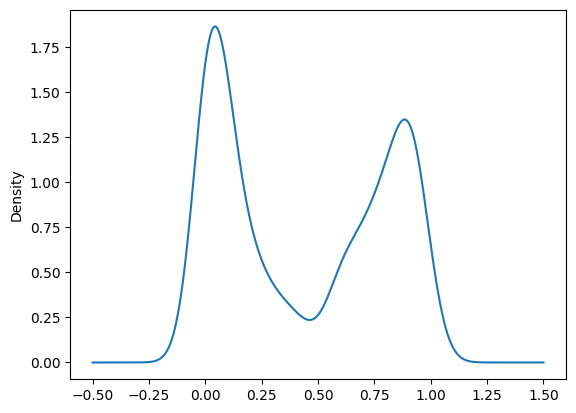

In [ ]:
df_babe["5mini_baseline_contin"].plot(kind="kde")

In [ ]:
df_babe.columns

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'text', 'news_link', 'outlet', 'topic', 'type',
       'label_bias', 'label_opinion', 'biased_words', 'elo_scores_10_listwise',
       'elo_scores_5nano_24', 'label_10_listwise', 'label_5nano_24',
       'elo_5nano_distance', 'elo_10_distance', 'label_5nano_binary',
       'label_10_binary', 'baseline_labels', 'baseline_severity',
       'baseline_elo', 'bt_10listwise_4rounds', 'bt_10listwise_6rounds',
       'bt_10listwise_10rounds_k64',
       'bt_elo_scores_par_5nano_24round_rnd01_init1500_k32',
       'bt_10listwise_4rounds_elo', 'bt_10listwise_6rounds_elo',
       'bt_10listwise_10rounds_k64_elo',
       'bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo',
       'fleiss_kappa', 'bt_10listwise_4rounds_elo_label',
       'bt_10listwise_6rounds_elo_label',
       'bt_10listwise_10rounds_k64_elo_label',
       'bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo_label',
       'BT_list

In [ ]:
df_babe["10listwise3_bt"].median()

0.6687651510653894

In [ ]:
np.round(32.5342, 3)

np.float64(32.534)

In [ ]:
def round_v(v):
  return np.round(v, 3)

def elo_to_binary(v):
  return "biased" if v >= 1500 else "non-biased"

def theta_to_binary(v):
  return "biased" if v > 0 else "non-biased"

def median_row(v):
  return "biased" if v > 0.6687651510653894 else "non-biased"

In [ ]:
df_babe_decided["10listwise3_theta"] = df_babe_decided["10listwise3_theta"].apply(theta_to_binary)
df_babe_decided["10listwise3_elo"] = df_babe_decided["10listwise3_elo"].apply(elo_to_binary)
df_babe_decided["10listwise3_bt"] = df_babe_decided["10listwise3_bt"].apply(median_row)

/tmp/ipython-input-2608309938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_decided["10listwise3_theta"] = df_babe_decided["10listwise3_theta"].apply(theta_to_binary)
/tmp/ipython-input-2608309938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_decided["10listwise3_elo"] = df_babe_decided["10listwise3_elo"].apply(elo_to_binary)
/tmp/ipython-input-2608309938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
df_babe_decided["10listwise3_nano_theta"] = df_babe_decided["10listwise3_nano_theta"].apply(theta_to_binary)
df_babe_decided["10listwise3_nano_elo"] = df_babe_decided["10listwise3_nano_elo"].apply(elo_to_binary)
df_babe_decided["10listwise3_nano_bt"] = df_babe_decided["10listwise3_nano_bt"].apply(median_row)

/tmp/ipython-input-3161588741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_decided["10listwise3_nano_theta"] = df_babe_decided["10listwise3_nano_theta"].apply(theta_to_binary)
/tmp/ipython-input-3161588741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_decided["10listwise3_nano_elo"] = df_babe_decided["10listwise3_nano_elo"].apply(elo_to_binary)
/tmp/ipython-input-3161588741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [ ]:
df_res = prf1_global(df_babe_decided, [
       'baseline_label', "5baseline_contin_bias",'bt_elo_scores_par_5nano_24round_rnd01_init1500_k32_elo_label',
       'label_5nano_24','10listwise3_bt', '10listwise3_elo',
       '10listwise3_theta',"10listwise3_nano_theta", "10listwise3_nano_elo", "10listwise3_nano_bt"], 'label_bias_lower', pos_label="biased")

df_res["tn"] = df_res["n"] - df_res["tp"] - df_res["fp"] - df_res["fn"]
#

In [ ]:
acc = []
for i,row in df_res.iterrows():
  row = row.to_dict()
  acc.append((row["tn"] +row["tp"])/row["n"])

df_res["accuracy"] = acc

In [ ]:
df_res["precision"] = df_res["precision"].apply(round_v)
df_res["recall"] = df_res["recall"].apply(round_v)
df_res["f1"] = df_res['f1'].apply(round_v)
df_res["accuracy"] = df_res["accuracy"].apply(round_v)

In [ ]:
df_res

pred     n    tp   fp   fn  \
0                                     baseline_label  3673  1541  538  269   
1                              5baseline_contin_bias  3673  1402  332  408   
2  bt_elo_scores_par_5nano_24round_rnd01_init1500...  3673  1405  344  405   
3                                     label_5nano_24  3673  1434  394  376   
4                                     10listwise3_bt  3673  1471  365  339   
5                                    10listwise3_elo  3673  1417  418  393   
6                                  10listwise3_theta  3673  1527  441  283   
7                             10listwise3_nano_theta  3673  1440  424  370   
8                               10listwise3_nano_elo  3673  1386  448  424   
9                                10listwise3_nano_bt  3673  1382  350  428   

   precision  recall     f1    tn  accuracy  
0      0.741   0.851  0.792  1325     0.780  
1      0.809   0.775  0.791  1531     0.799  
2      0.803   0.776  0.790  1519     0.796  
3      0.784   0.792  0.788  1469     0.790  
4      0.801   0.813  0.807  1498     0.808  
5      0.772   0.783  0.778  1445     0.779  
6      0.776   0.844  0.808  1422     0.803  
7      0.773   0.796  0.784  1439     0.784  
8      0.756   0.766  0.761  1415     0.763  
9      0.798   0.764  0.780  1513     0.788

In [ ]:
df_res.to_csv("/BABE/BABE_eval_metrics.csv")

In [ ]:
cfg = LabelingConfig(
    strategy="single",            # or "single"
    hi=1550.0, lo=1450.0,       # used if strategy="dual"
    thr=1500.0,                 # used if strategy="single"
    ignore_middle=False,         # if True, middle band is skipped from metrics
    positive_label="Biased",
    negative_label="Non-biased",
    ignore_labels=("No agreement",),
)

# evaluate 200 runs
df_eval_200 = evaluate_runs(
    run_pickles=["/BABE/BABE200_3streak50.pkl", "/BABE/BABE200_015pruned_12_24.pkl","/BABE/BABE200_10listwise_4rounds.pkl" ,"/BABE/test_BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl", "/BABE/BABE200_10listwise_6rounds_BABE_Prompt.pkl", "/BABE/BABE200_10listwise_6rounds.pkl", "/BABE/BABE200_baseline.pkl"],
    gold=gold_labels200,  # or dict {query:label} or list[(query,label)] or DataFrame
    labeling=cfg,
)

df_eval_200.to_csv("/BABE/BABE200_eval.csv")

# display(df_eval_200)

# evaluate full runs
df_eval_full = evaluate_runs(
    run_pickles=["/BABE/BABE_10listwise_4rounds.pkl", "/BABE/BABE_10listwise_10rounds_k64.pkl", "/BABE/BABE_10listwise_6rounds.pkl", "/BABE/BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl", "/BABE/BABE_baseline.pkl"],
    gold=gold_labels,  # or dict {query:label} or list[(query,label)] or DataFrame
    labeling=cfg,
)

df_eval_full.to_csv("/BABE/BABE_eval.csv")

display(df_eval_full)


NameError: name 'LabelingConfig' is not defined

/tmp/ipython-input-905294796.py:49: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(elo_nano_series, label='gpt-4.1-nano_12round_eqRank01_sim', shade=True)
/tmp/ipython-input-905294796.py:52: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(elo_mini_series, label='gpt-4.1-mini_12round_eqRank01_sim', shade=True)
/tmp/ipython-input-905294796.py:55: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(elo_nano24_series, label='gpt-4.1-nano-24round_eqRank01_sim', shade=True)
/tmp/ipython-input-905294796.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0

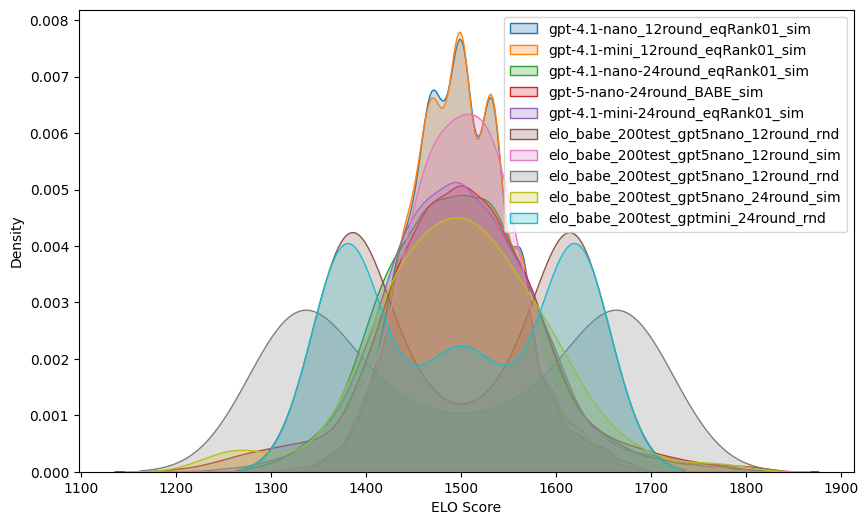

In [ ]:

# Convert ELO scores to pandas Series for easier plotting
elo_nano_series = pd.Series(elo_scores_par_41nano_12round_rnd01_init1500_k32)
elo_mini_series = pd.Series(elo_scores_par_41mini_12round_rnd01_init1500_k32)
elo_nano24_series = pd.Series(elo_scores_par_41nano_24round_rnd01_init1500_k32)
elo_mini24_series = pd.Series(elo_scores_par_41mini_24round_rnd01_init1500_k32)

elo_babe_200_test_nano_rnd = test_BABE_elo_scores_par_5nano_12round_rnd1_init1500_k32["elo_scores"]
elo_babe_200_test_nano_sim = test_BABE_elo_scores_par_5nano_12round_rnd01_init1500_k32["elo_scores"]
elo_babe_200_test_mini = test_BABE_elo_scores_par_5mini_12round_rnd1_init1500_k32["elo_scores"]
elo_babe_200_test_nano_rnd_24 = test_BABE_elo_scores_par_5nano_24round_rnd1_init1500_k32["elo_scores"]
elo_babe_200_test_nano_sim_24 = test_BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32["elo_scores"]

elo_babe_5nano_sim_24 = BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32["elo_scores"]

# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

# Plot the density of elo_scores_par_41nano_12round_rnd01_init1500_k32
sns.kdeplot(elo_nano_series, label='gpt-4.1-nano_12round_eqRank01_sim', shade=True)

# Plot the density of elo_scores_par_41mini_12round_rnd01_init1500_k32
sns.kdeplot(elo_mini_series, label='gpt-4.1-mini_12round_eqRank01_sim', shade=True)

# Plot the 24 nano
sns.kdeplot(elo_nano24_series, label='gpt-4.1-nano-24round_eqRank01_sim', shade=True)

# Plot the full 24 nano
sns.kdeplot(elo_babe_5nano_sim_24, label='gpt-5-nano-24round_BABE_sim', shade=True)

# Plot the 24 mini
sns.kdeplot(elo_mini24_series, label='gpt-4.1-mini-24round_eqRank01_sim', shade=True)

# Plot BABE test
sns.kdeplot(elo_babe_200_test_nano_rnd, label='elo_babe_200test_gpt5nano_12round_rnd', shade=True)
sns.kdeplot(elo_babe_200_test_nano_sim, label='elo_babe_200test_gpt5nano_12round_sim', shade=True)
sns.kdeplot(elo_babe_200_test_nano_rnd_24, label='elo_babe_200test_gpt5nano_12round_rnd', shade=True)
sns.kdeplot(elo_babe_200_test_nano_sim_24, label='elo_babe_200test_gpt5nano_24round_sim', shade=True)
sns.kdeplot(elo_babe_200_test_mini, label='elo_babe_200test_gptmini_24round_rnd', shade=True)


# Add titles and labels
#plt.title('Density Plot of ELO Scores for different configurations')
plt.xlabel('ELO Score')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

/tmp/ipython-input-1567988048.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(elo_babe_200_test_nano_rnd, label='elo_babe_200test_gpt5nano_12round_rnd', shade=True)
/tmp/ipython-input-1567988048.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(elo_babe_200_test_nano_sim, label='elo_babe_200test_gpt5nano_12round_sim', shade=True)
/tmp/ipython-input-1567988048.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(elo_babe_200_test_mini, label='elo_babe_200test_gptmini_12round_rnd', shade=True)
/tmp/ipython-input-1567988048.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This w

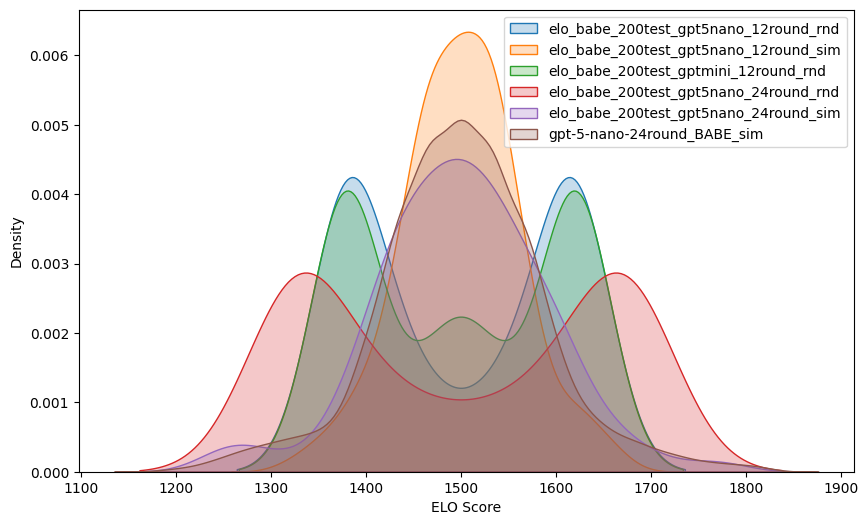

In [ ]:
# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

# Plot BABE test
sns.kdeplot(elo_babe_200_test_nano_rnd, label='elo_babe_200test_gpt5nano_12round_rnd', shade=True)
sns.kdeplot(elo_babe_200_test_nano_sim, label='elo_babe_200test_gpt5nano_12round_sim', shade=True)
sns.kdeplot(elo_babe_200_test_mini, label='elo_babe_200test_gptmini_12round_rnd', shade=True)
sns.kdeplot(elo_babe_200_test_nano_rnd_24, label='elo_babe_200test_gpt5nano_24round_rnd', shade=True)
sns.kdeplot(elo_babe_200_test_nano_sim_24, label='elo_babe_200test_gpt5nano_24round_sim', shade=True)

# Plot the full 24 nano
sns.kdeplot(elo_babe_5nano_sim_24, label='gpt-5-nano-24round_BABE_sim', shade=True)


# Add titles and labels
#plt.title('Density Plot of ELO Scores for different configurations')
plt.xlabel('ELO Score')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
babe_test_dict_texts = {q: i for i, q in enumerate(df_babe.text.to_list()[:200])}
babe_test_dict_bias = {q: i for i, q in enumerate(df_babe.label_bias.to_list()[:200])}

babe_dict_texts = {q: i for i, q in enumerate(df_babe.text.to_list())}
babe_dict_bias = {q: i for i, q in enumerate(df_babe.label_bias.to_list())}

In [ ]:
df_babe["elo_score"] = df_babe["text"].map(elo_babe_5nano_sim_24)

## Plot GIF

In [ ]:

from typing import Dict, List, Optional, Tuple, Union
import pickle
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from io import BytesIO

def _reconstruct_elos_per_round(match_history: List[list], final_elos: Dict[str, float], include_round0: bool) -> List[Dict[str, float]]:
    """
    Reconstruct the end-of-round ELO snapshots using the logged match_history and the
    fact that each round's updates were computed from a frozen snapshot.
    We infer the initial rating as the *mean* of the final ratings (rating sum is conserved).
    Returns a list of dicts, one per round (optionally including round 0).
    """
    queries = list(final_elos.keys())
    # Rating sum is invariant under symmetric ELO updates, so the mean equals the initial rating.
    mean_final = float(np.mean(list(final_elos.values())))
    prev_elos = {q: mean_final for q in queries}
    snapshots: List[Dict[str, float]] = []

    if include_round0:
        snapshots.append(prev_elos.copy())  # initial state before any matches

    for round_matches in match_history:
        next_elos = prev_elos.copy()
        for m in round_matches:
            q1 = m.get("text1")
            q2 = m.get("text2")
            delta_a, delta_b = m.get("elo_change", (0.0, 0.0))
            if q1 is not None:
                next_elos[q1] = prev_elos[q1] - float(delta_a)
            if q2 is not None:
                next_elos[q2] = prev_elos[q2] - float(delta_b)
        snapshots.append(next_elos)
        prev_elos = next_elos

    return snapshots


def _prepare_cluster_map(
    queries: List[str],
    clusters: Optional[Union[Dict[str, str], List[str]]],
    query_order: Optional[List[str]]
) -> Dict[str, str]:
    """
    Build a mapping query -> cluster label.
    - If clusters is a dict, use it directly.
    - If clusters is a list, query_order must be provided and have the same length;
      we zip them into a dict.
    - If clusters is None, assign all queries to a single cluster "All".
    """
    if clusters is None:
        return {q: "All" for q in queries}

    if isinstance(clusters, dict):
        # If some queries are missing in the dict, map them to "Unlabeled".
        return {q: clusters.get(q, "Unlabeled") for q in queries}

    # It's a list: require the explicit order of queries
    if query_order is None:
        raise ValueError("clusters is a list — please provide query_order (list of queries in original order).")
    if len(clusters) != len(query_order):
        raise ValueError("clusters list length must match query_order length.")
    mapping = dict(zip(query_order, clusters))
    # Fill any missing queries with "Unlabeled"
    return {q: mapping.get(q, "Unlabeled") for q in queries}


def _cohens_d(a: np.ndarray, b: np.ndarray) -> Optional[float]:
    """Compute Cohen's d for two independent samples. Returns None if undefined."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    n1, n2 = a.size, b.size
    if n1 < 2 or n2 < 2:
        return None
    m1, m2 = float(np.mean(a)), float(np.mean(b))
    s1, s2 = float(np.var(a, ddof=1)), float(np.var(b, ddof=1))  # sample variances
    # pooled standard deviation
    pooled_var = ((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)
    if pooled_var <= 0:
        return None
    sp = float(np.sqrt(pooled_var))
    return (m1 - m2) / sp


def _stacked_density_bars_for_round(
    ax,
    elos_for_round: Dict[str, float],
    cluster_map: Dict[str, str],
    bin_edges: np.ndarray,
    ylim_max: float,
    title: str,
    vline_at: Optional[float] = 1500.0,
    show_cluster_means: bool = True,
    annotate_d: bool = True,
    d_pair: Optional[Tuple[str, str]] = None,
    mean_clusters: Optional[List[str]] = None,   # NEW: restrict which clusters show mean lines
    d_include: Optional[List[str]] = None,       # NEW: restrict which clusters are considered for d
) -> None:
    """Draw a single stacked density histogram on the provided Axes, with optional
    global reference line, cluster-mean lines, and Cohen's d annotation.
    """
    # Group elos by cluster
    clusters_sorted = sorted(set(cluster_map.values()))
    per_cluster_elos: Dict[str, List[float]] = {c: [] for c in clusters_sorted}
    for q, r in elos_for_round.items():
        per_cluster_elos[cluster_map[q]].append(r)

    # Compute densities per cluster per bin
    bin_widths = np.diff(bin_edges)
    centers = bin_edges[:-1] + bin_widths / 2.0
    bottoms = np.zeros_like(centers, dtype=float)

    total_n = sum(len(v) for v in per_cluster_elos.values())
    total_n = max(total_n, 1)  # avoid div-by-zero

    for cluster in clusters_sorted:
        data = np.array(per_cluster_elos[cluster], dtype=float)
        if data.size == 0:
            continue
        counts, _ = np.histogram(data, bins=bin_edges)
        # Convert counts to density so that the sum over bins * bin_width equals the cluster's share.
        densities = counts.astype(float) / (total_n * bin_widths)
        ax.bar(centers, densities, width=bin_widths * 0.9, bottom=bottoms, label=cluster, align="center")
        bottoms += densities

    # Optional vertical reference line (default 1500)
    if vline_at is not None:
        try:
            ax.axvline(float(vline_at), linestyle="--", linewidth=1)
        except Exception:
            pass

    # Determine which clusters to draw mean lines for
    clusters_for_means = clusters_sorted if (mean_clusters is None) else [c for c in clusters_sorted if c in set(mean_clusters)]

    # Optional vertical lines at per-cluster means
    if show_cluster_means and len(clusters_for_means) > 0:
        for c in clusters_for_means:
            vals = np.asarray(per_cluster_elos[c], dtype=float)
            if vals.size > 0:
                mu = float(np.mean(vals))
                try:
                    ax.axvline(mu, linestyle=":", linewidth=1)
                except Exception:
                    pass

    # Optional Cohen's d annotation
    if annotate_d:
        # Filter which clusters to consider for d
        eligible = clusters_sorted if (d_include is None) else [c for c in clusters_sorted if c in set(d_include)]

        # Choose cluster pair
        chosen_pair = None
        if d_pair is not None and all(lbl in per_cluster_elos for lbl in d_pair):
            # If d_pair provided, it takes precedence (but still ensure they are in eligible set, if provided)
            if d_include is None or (d_pair[0] in eligible and d_pair[1] in eligible):
                chosen_pair = d_pair
        if chosen_pair is None:
            # Prefer ("Biased","Non-Biased") if present and eligible
            if ("Biased" in eligible) and ("Non-Biased" in eligible):
                chosen_pair = ("Biased", "Non-Biased")
            else:
                # If exactly two eligible clusters, use them
                if len(eligible) == 2:
                    chosen_pair = (eligible[0], eligible[1])

        d_text = "Cohen's d: n/a"
        if chosen_pair is not None:
            a_vals = np.asarray(per_cluster_elos[chosen_pair[0]], dtype=float)
            b_vals = np.asarray(per_cluster_elos[chosen_pair[1]], dtype=float)
            d = _cohens_d(a_vals, b_vals)
            if d is not None:
                d_text = f"Cohen's d ({chosen_pair[0]}−{chosen_pair[1]}): {d:.2f}"
            else:
                d_text = f"Cohen's d ({chosen_pair[0]}−{chosen_pair[1]}): n/a"

        # Put text in the top-right corner inside axes
        ax.text(0.99, 0.95, d_text, transform=ax.transAxes, ha="right", va="top")

    ax.set_ylim(0, ylim_max)
    ax.set_xlabel("ELO rating")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend(loc="best")


def _compute_aligned_bin_edges(
    all_ratings: np.ndarray,
    n_bins: int,
    pad_fraction: float,
    align_edge_at: Optional[float] = 1500.0,
) -> np.ndarray:
    """
    Compute global bin edges so that a bin EDGE lies exactly at `align_edge_at` (e.g., 1500).
    Ensures the rating range includes the alignment point.
    """
    r_min = float(np.min(all_ratings))
    r_max = float(np.max(all_ratings))

    # Pad range
    pad = max(10.0, pad_fraction * (r_max - r_min + 1e-9))
    L = r_min - pad
    U = r_max + pad

    # Ensure the alignment point is included comfortably
    if align_edge_at is not None:
        L = min(L, align_edge_at - pad)
        U = max(U, align_edge_at + pad)

    # Build edges
    n_bins_eff = max(int(n_bins), 2)
    if align_edge_at is None:
        return np.linspace(L, U, n_bins_eff + 1)

    # Align: shift start so that 1500 is exactly an edge
    width = (U - L) / n_bins_eff
    k = int(round((align_edge_at - L) / width))
    L_prime = align_edge_at - k * width
    edges = L_prime + np.arange(n_bins_eff + 1) * width
    # Force exact 1500 on the k-th edge to avoid FP jitter
    if 0 <= k <= n_bins_eff:
        edges[k] = align_edge_at
    return edges


def make_elo_density_gif(
    log_path: str,
    out_path: str = "elo_density.gif",
    clusters: Optional[Union[Dict[str, str], List[str]]] = None,
    query_order: Optional[List[str]] = None,
    fps: int = 1,
    n_bins: int = 20,
    figsize: Tuple[int, int] = (10, 6),
    dpi: int = 150,
    include_round0: bool = True,
    vline_at: Optional[float] = 1500.0,       # vertical line (default at Elo 1500). Set None to disable.
    loop: int = 0,                            # GIF loop count. 0 = infinite (default).
    show_cluster_means: bool = True,          # draw vertical lines at cluster means each frame
    annotate_d: bool = True,                  # annotate Cohen's d (for two clusters)
    d_pair: Optional[Tuple[str, str]] = None, # optional explicit pair for d
    align_edge_at: Optional[float] = 1500.0,  # align a histogram bin EDGE at this value
    special_round0: str = "line",             # for the initial frame: "line" or "bars"
    pad_fraction: float = 0.02,               # range padding as a fraction of span
    mean_clusters: Optional[List[str]] = None,# NEW: clusters to include for mean lines
    d_include: Optional[List[str]] = None,    # NEW: clusters eligible for Cohen's d
) -> str:
    """
    Create a GIF (1 frame per second by default) that shows a stacked *density bar plot*
    (histogram) of ELO ratings after each round. If cluster labels are provided, bars are
    stacked by cluster so you can visually assess separation of categories (e.g., "Biased"
    vs "Non-Biased").

    Additions:
    - Align a histogram bin edge at 1500 to cleanly split bars around 1500 (from Round 1).
    - Special initial frame ("line") to avoid degenerate all-at-1500 bars.
    - NEW controls:
        * mean_clusters: choose which clusters get mean lines.
        * d_include: choose which clusters are considered for Cohen's d selection.
          (You can still override with d_pair to force a specific comparison.)

    Parameters
    ----------
    log_path : str
        Path to the pickle file saved by `pairwise_comparison_elo` containing
        {"elo_scores": dict[str,float], "match_history": list[...]}.
    out_path : str
        Where to write the output GIF.
    clusters : Optional[Union[Dict[str, str], List[str]]]
        Cluster labels, either:
          - dict mapping query string -> cluster label, or
          - list of labels aligned with `query_order` (original queries order).
        If None, all queries are plotted under a single cluster "All".
    query_order : Optional[List[str]]
        Required only when `clusters` is a list. Must be the original queries in order.
    fps : int
        Frames per second in the GIF (default 1).
    n_bins : int
        Number of histogram bins across the rating range.
    figsize : Tuple[int, int]
        Matplotlib figure size.
    dpi : int
        Matplotlib figure DPI for each frame.
    include_round0 : bool
        If True, include an initial frame for the pre-round (initial ratings).
    vline_at : Optional[float]
        X-position for a vertical reference line (default 1500). Set None to disable.
    loop : int
        Number of times the GIF should loop. 0 means loop forever (default).
    show_cluster_means : bool
        Draw a vertical line at each cluster's mean rating each frame.
    annotate_d : bool
        Annotate Cohen's d for two clusters (requires either exactly two clusters or explicit d_pair).
    d_pair : Optional[Tuple[str, str]]
        Explicitly choose which two cluster labels to compare for Cohen's d.
    align_edge_at : Optional[float]
        If not None, ensure a histogram bin edge lies exactly at this value (e.g., 1500).
    special_round0 : {"line","bars"}
        If "line", the first frame draws only the reference line and text, not bars.
    pad_fraction : float
        Fraction of rating span used for padding the min/max when computing bin edges.
    mean_clusters : Optional[List[str]]
        If provided, only these clusters will have mean lines drawn.
    d_include : Optional[List[str]]
        If provided, only these clusters are eligible for automatic Cohen's d selection
        (you can still force a pair via d_pair).

    Returns
    -------
    str
        The path to the written GIF.
    """
    # Load the log
    with open(log_path, "rb") as f:
        data = pickle.load(f)

    if not isinstance(data, dict) or "elo_scores" not in data or "match_history" not in data:
        raise ValueError("Invalid log file: expected a dict with keys 'elo_scores' and 'match_history'.")

    final_elos: Dict[str, float] = data["elo_scores"]
    match_history: List[list] = data["match_history"]

    # Reconstruct snapshots
    snapshots = _reconstruct_elos_per_round(match_history, final_elos, include_round0=include_round0)
    queries = list(final_elos.keys())

    # Prepare cluster map
    cluster_map = _prepare_cluster_map(queries, clusters, query_order)

    # Determine global binning and y-limits for consistent axes
    all_ratings = np.array([r for snap in snapshots for r in snap.values()], dtype=float)
    if all_ratings.size == 0:
        raise ValueError("No ratings found in log.")

    bin_edges = _compute_aligned_bin_edges(all_ratings, n_bins=n_bins, pad_fraction=pad_fraction, align_edge_at=align_edge_at)

    # Pre-compute a global y-limit (max stacked density across frames)
    # Estimate by simulating a stacked density for each frame
    n_bins_eff = len(bin_edges) - 1
    global_ymax = 0.0
    for snap in snapshots:
        # Group by cluster
        per_cluster = {}
        for q, r in snap.items():
            c = cluster_map[q]
            per_cluster.setdefault(c, []).append(r)
        total_n = sum(len(v) for v in per_cluster.values())
        total_n = max(total_n, 1)
        bin_widths = np.diff(bin_edges)
        stacked = np.zeros(n_bins_eff, dtype=float)
        for c, vals in per_cluster.items():
            if len(vals) == 0:
                continue
            counts, _ = np.histogram(np.asarray(vals, dtype=float), bins=bin_edges)
            densities = counts.astype(float) / (total_n * bin_widths)
            stacked += densities
        global_ymax = max(global_ymax, float(np.max(stacked)))

    global_ymax = max(global_ymax * 1.1, 0.01)  # small floor

    # Render frames
    frames = []
    for idx, snap in enumerate(snapshots):
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        round_label = "Initial (Round 0)" if (include_round0 and idx == 0) else f"After Round {idx if include_round0 else idx+1}"

        is_initial = include_round0 and idx == 0 and special_round0 == "line"
        if is_initial:
            # Draw only the reference line and helpful annotations, no bars
            if vline_at is not None:
                try:
                    ax.axvline(float(vline_at), linestyle="--", linewidth=1)
                except Exception:
                    pass
            ax.set_xlim(bin_edges[0], bin_edges[-1])
            ax.set_ylim(0, global_ymax)
            ax.set_xlabel("ELO rating")
            ax.set_ylabel("Density")
            ax.set_title(f"ELO Distribution — {round_label}")
            ax.text(0.5, 0.9, "All ratings start at 1500", transform=ax.transAxes, ha="center", va="top")
            # Optional: show cluster mean line(s) (they'll all be at 1500)
            if show_cluster_means:
                # honor mean_clusters filter, if provided
                if mean_clusters is None or len(mean_clusters) > 0:
                    try:
                        ax.axvline(1500, linestyle=":", linewidth=1)
                    except Exception:
                        pass
            # Optional Cohen's d: n/a at start
            if annotate_d:
                ax.text(0.99, 0.95, "Cohen's d: n/a", transform=ax.transAxes, ha="right", va="top")
        else:
            _stacked_density_bars_for_round(
                ax, snap, cluster_map, bin_edges, ylim_max=global_ymax,
                title=f"ELO Distribution — {round_label}",
                vline_at=vline_at,
                show_cluster_means=show_cluster_means,
                annotate_d=annotate_d,
                d_pair=d_pair,
                mean_clusters=mean_clusters,
                d_include=d_include,
            )

        fig.tight_layout()

        # Save to an in-memory buffer then read back as an image
        buf = BytesIO()
        fig.savefig(buf, format="png")
        plt.close(fig)
        buf.seek(0)
        image = iio.imread(buf.read())
        frames.append(image)

    # Write GIF with infinite loop by default (loop=0)
    iio.imwrite(out_path, frames, fps=fps, loop=loop)

    return out_path

def check_elo_biased(v):
  if v > 1500:
    return "Biased"
  else:
    return "Non-biased"


In [ ]:
original_queries = df_babe.text.to_list()                 # the exact order you passed into pairwise_comparison_elo
cluster_list = df_babe.label_bias.to_list()  # same length as original_queries
gif_path = make_elo_density_gif(
    log_path="/BABE/BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl",
    out_path="elo_evolution_labeled.gif",
    clusters=cluster_list,
    query_order=original_queries,
    fps=1,
    vline_at=1500.0,
    align_edge_at=1500.0,     # bar split at 1500
    special_round0="line",    # clean initial frame
    loop=0,                   # infinite
    show_cluster_means=True,
    mean_clusters=["Biased", "Non-biased"],   # <- only draw means for these
    annotate_d=True,
    d_include=["Biased", "Non-biased"],       # <- only consider these for Cohen's d
    # d_pair=("Biased","Non-Biased"),         # optional: force exact comparison + ordering
)

In [ ]:
original_queries = df_babe.text.to_list()                 # the exact order you passed into pairwise_comparison_elo
cluster_list = df_babe.label_bias.to_list()  # same length as original_queries
gif_path = make_elo_density_gif(
    log_path="/BABE/BABE_10listwise_6rounds.pkl",
    out_path="elo_evolution_labeled_listwise6.gif",
    clusters=cluster_list,
    query_order=original_queries,
    fps=1,
    vline_at=1500.0,
    align_edge_at=1500.0,     # bar split at 1500
    special_round0="line",    # clean initial frame
    loop=0,                   # infinite
    show_cluster_means=True,
    mean_clusters=["Biased", "Non-biased"],   # <- only draw means for these
    annotate_d=True,
    d_include=["Biased", "Non-biased"],       # <- only consider these for Cohen's d
    # d_pair=("Biased","Non-Biased"),         # optional: force exact comparison + ordering
)

In [ ]:
original_queries = df_babe.text.to_list()                 # the exact order you passed into pairwise_comparison_elo
cluster_list = df_babe.label_bias.to_list()  # same length as original_queries
gif_path = make_elo_density_gif(
    log_path="/BABE/BABE_elo_scores_par_5nano_24round_rnd01_init1500_k32.pkl",
    out_path="elo_evolution_labeled.gif",
    clusters=cluster_list,
    query_order=original_queries,
    fps=1,
    vline_at=1500.0,
    align_edge_at=1500.0,     # bar split at 1500
    special_round0="line",    # clean initial frame
    loop=0,                   # infinite
    show_cluster_means=True,
    mean_clusters=["Biased", "Non-biased"],   # <- only draw means for these
    annotate_d=True,
    d_include=["Biased", "Non-biased"],       # <- only consider these for Cohen's d
    # d_pair=("Biased","Non-Biased"),         # optional: force exact comparison + ordering
)

In [ ]:
original_queries = df_babe[:200].text.to_list()                 # the exact order you passed into pairwise_comparison_elo
cluster_list = df_babe[:200].label_bias.to_list()  # same length as original_queries
gif_path = make_elo_density_gif(
    log_path="/BABE/test_BABE_elo_scores_par_5nano_24round_rnd1_init1500_k32.pkl",
    out_path="elo_evolution_test200_random_labeled.gif",
    clusters=cluster_list,
    query_order=original_queries,
    fps=1,
    vline_at=1500.0,
    align_edge_at=1500.0,     # bar split at 1500
    special_round0="line",    # clean initial frame
    loop=0,                   # infinite
    show_cluster_means=True,
    mean_clusters=["Biased", "Non-biased"],   # <- only draw means for these
    annotate_d=True,
    d_include=["Biased", "Non-biased"],       # <- only consider these for Cohen's d
    # d_pair=("Biased","Non-Biased"),         # optional: force exact comparison + ordering
)

In [ ]:
original_queries = df_babe[:200].text.to_list()                 # the exact order you passed into pairwise_comparison_elo
cluster_list = df_babe[:200].label_bias.to_list()  # same length as original_queries
gif_path = make_elo_density_gif(
    log_path="/BABE/BABE200_3streak50.pkl",
    out_path="elo_evolution_test200_3streak.gif",
    clusters=cluster_list,
    query_order=original_queries,
    fps=1,
    vline_at=1500.0,
    align_edge_at=1500.0,     # bar split at 1500
    special_round0="line",    # clean initial frame
    loop=0,                   # infinite
    show_cluster_means=True,
    mean_clusters=["Biased", "Non-biased"],   # <- only draw means for these
    annotate_d=True,
    d_include=["Biased", "Non-biased"],       # <- only consider these for Cohen's d
    # d_pair=("Biased","Non-Biased"),         # optional: force exact comparison + ordering
)

In [ ]:
original_queries = df_babe[:200].text.to_list()                 # the exact order you passed into pairwise_comparison_elo
cluster_list = df_babe[:200].label_bias.to_list()  # same length as original_queries
gif_path = make_elo_density_gif(
    log_path="/BABE/BABE200_015pruned_12_24.pkl",
    out_path="elo_evolution_test200_015pruned12.gif",
    clusters=cluster_list,
    query_order=original_queries,
    fps=1,
    vline_at=1500.0,
    align_edge_at=1500.0,     # bar split at 1500
    special_round0="line",    # clean initial frame
    loop=0,                   # infinite
    show_cluster_means=True,
    mean_clusters=["Biased", "Non-biased"],   # <- only draw means for these
    annotate_d=True,
    d_include=["Biased", "Non-biased"],       # <- only consider these for Cohen's d
    # d_pair=("Biased","Non-Biased"),         # optional: force exact comparison + ordering
)

In [ ]:
df_babe_200_analysis = df_babe[:200]
df_babe_200_analysis["elo_score"] = df_babe_200_analysis["text"].map(elo_babe_200_test_nano_rnd)
df_babe_200_analysis["elo_score_24"] = df_babe_200_analysis["text"].map(elo_babe_200_test_nano_rnd_24)
df_babe_200_analysis["elo_score_24_sim"] = df_babe_200_analysis["text"].map(elo_babe_200_test_nano_sim_24)

/tmp/ipython-input-2441900867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_200_analysis["elo_score"] = df_babe_200_analysis["text"].map(elo_babe_200_test_nano_rnd)
/tmp/ipython-input-2441900867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_200_analysis["elo_score_24"] = df_babe_200_analysis["text"].map(elo_babe_200_test_nano_rnd_24)
/tmp/ipython-input-2441900867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

/tmp/ipython-input-1549872566.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Biased"].elo_score.to_list(), label='biased', shade=True)
/tmp/ipython-input-1549872566.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Non-biased"].elo_score.to_list(), label='non-biased', shade=True)
/tmp/ipython-input-1549872566.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Biased"].elo_score_24.to_list(), label='biased_24', shade=True)
/t

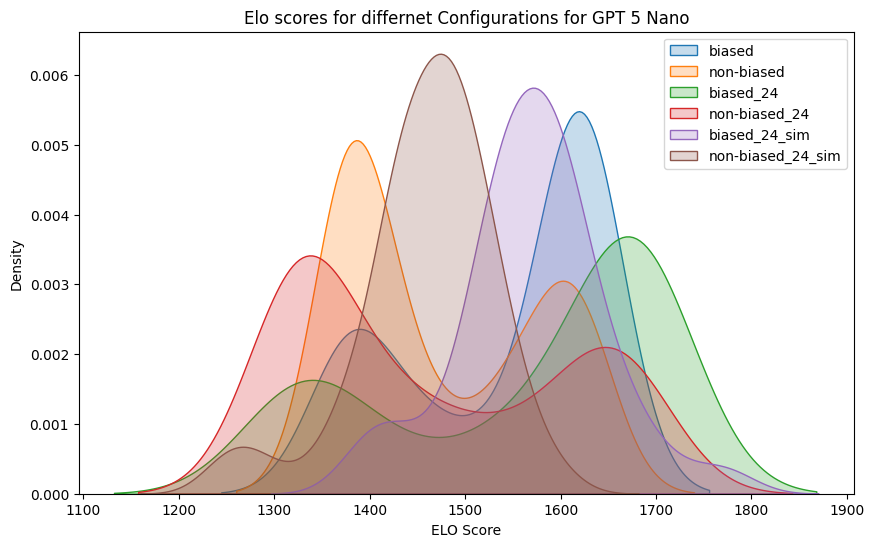

In [ ]:
# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

# Plot BABE test
sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Biased"].elo_score.to_list(), label='biased', shade=True)
sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Non-biased"].elo_score.to_list(), label='non-biased', shade=True)

sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Biased"].elo_score_24.to_list(), label='biased_24', shade=True)
sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Non-biased"].elo_score_24.to_list(), label='non-biased_24', shade=True)

sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Biased"].elo_score_24_sim.to_list(), label='biased_24_sim', shade=True)
sns.kdeplot(df_babe_200_analysis.loc[df_babe_200_analysis['label_bias'] == "Non-biased"].elo_score_24_sim.to_list(), label='non-biased_24_sim', shade=True)


# Add titles and labels
#plt.title('Density Plot of ELO Scores for different configurations')
plt.xlabel('ELO Score')
plt.ylabel('Density')

# Add a legend
plt.title("Elo scores for differnet Configurations for GPT 5 Nano")
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_babe.groupby("label_bias").elo_score.mean()

label_bias
Biased          1552.015074
No agreement    1562.770012
Non-biased      1449.430996
Name: elo_score, dtype: float64

In [ ]:
df_babe["elo_listwise6"] = df_babe["text"].map(BABE_10listwise_6rounds["elo_scores"])
df_babe["elo_listwise10"] = df_babe["text"].map(BABE_10listwise_10rounds_k64["elo_scores"])

In [ ]:
df_babe["bias_elo_listwise6"] = df_babe.apply(lambda row: check_elo_biased(row["elo_listwise6"]), axis=1)
df_babe["bias_elo_listwise10"] = df_babe.apply(lambda row: check_elo_biased(row["elo_listwise10"]), axis=1)

<Axes: ylabel='Frequency'>

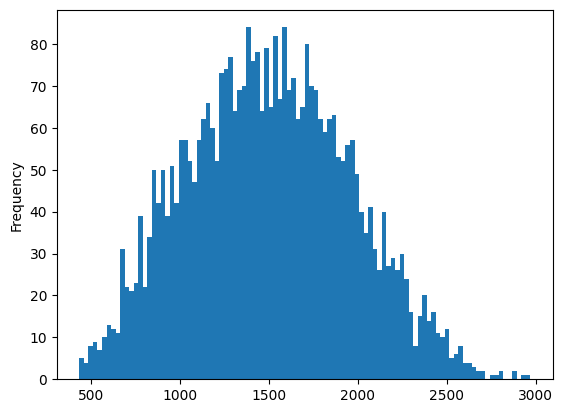

In [ ]:
df_babe.elo_listwise10.plot(kind="hist", bins=100)

/tmp/ipython-input-4176590147.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe.loc[df_babe['label_bias'] == "Biased"].elo_listwise10.to_list(), label='Biased 10', shade=True)
/tmp/ipython-input-4176590147.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe.loc[df_babe['label_bias'] != "Biased"].elo_listwise10.to_list(), label='Not Biased 10', shade=True)
/tmp/ipython-input-4176590147.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe.loc[df_babe['label_bias'] == "Biased"].elo_listwise6.to_list(), label='Biased 6', shade=True)
/tmp/ipython-input-4176590147.py:8: FutureWarning: 

`shade` is now 

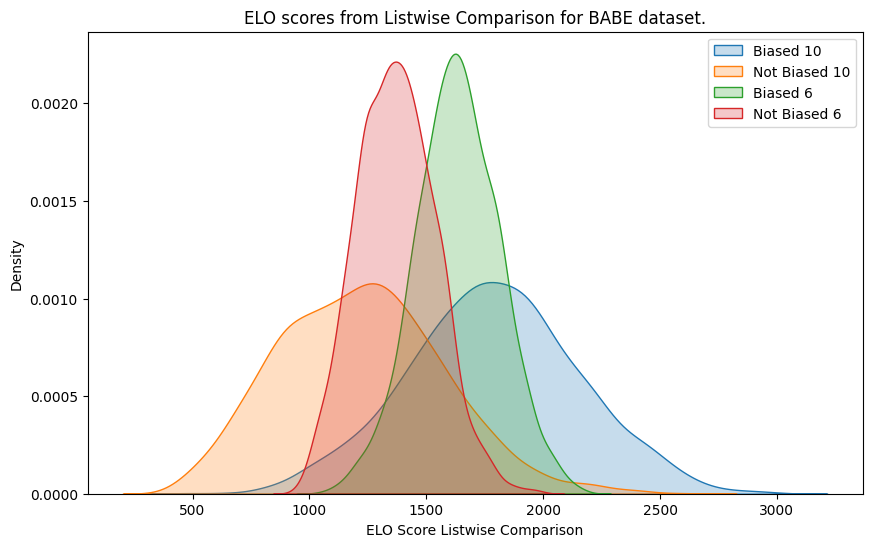

In [ ]:
# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))


sns.kdeplot(df_babe.loc[df_babe['label_bias'] == "Biased"].elo_listwise10.to_list(), label='Biased 10', shade=True)
sns.kdeplot(df_babe.loc[df_babe['label_bias'] != "Biased"].elo_listwise10.to_list(), label='Not Biased 10', shade=True)
sns.kdeplot(df_babe.loc[df_babe['label_bias'] == "Biased"].elo_listwise6.to_list(), label='Biased 6', shade=True)
sns.kdeplot(df_babe.loc[df_babe['label_bias'] != "Biased"].elo_listwise6.to_list(), label='Not Biased 6', shade=True)
# Add titles and labels
#plt.title('Density Plot of ELO Scores for different configurations')
plt.xlabel('ELO Score Listwise Comparison')
plt.ylabel('Density')

# Add a legend
plt.title("ELO scores from Listwise Comparison for BABE dataset.")
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_babe_200_analysis['bias_elo_score'] = df_babe_200_analysis.apply(lambda row: check_elo_biased(row["elo_score"]), axis=1)
df_babe_200_analysis['bias_elo_score_24'] = df_babe_200_analysis.apply(lambda row: check_elo_biased(row["elo_score_24"]), axis=1)
df_babe_200_analysis['bias_elo_score_24_sim'] = df_babe_200_analysis.apply(lambda row: check_elo_biased(row["elo_score_24_sim"]), axis=1)

df_babe["bias_elo_score"] = df_babe.apply(lambda row: check_elo_biased(row["elo_score"]), axis=1)

/tmp/ipython-input-3260942360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_200_analysis['bias_elo_score'] = df_babe_200_analysis.apply(lambda row: check_elo_biased(row["elo_score"]), axis=1)
/tmp/ipython-input-3260942360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_babe_200_analysis['bias_elo_score_24'] = df_babe_200_analysis.apply(lambda row: check_elo_biased(row["elo_score_24"]), axis=1)
/tmp/ipython-input-3260942360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a 

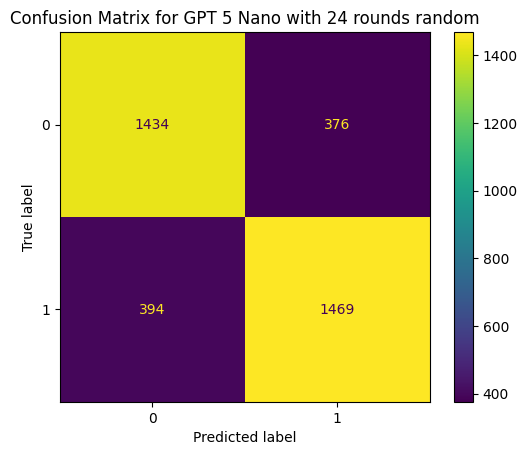

In [ ]:
# imports consolidated at top
df_babe_agree = df_babe.loc[df_babe["label_bias"] != "No agreement"]

confusion_matrix = metrics.confusion_matrix(df_babe_agree["label_bias"], df_babe_agree["bias_elo_score"])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.title("Confusion Matrix for GPT 5 Nano with 24 rounds random")
plt.show()

/tmp/ipython-input-2883519891.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label_bias'] == "Biased") & (df_babe_agree['bias_elo_score'] != "Biased")].elo_score.to_list(), label='False negatives', shade=True)
/tmp/ipython-input-2883519891.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label_bias'] == "Non-biased") & (df_babe_agree['bias_elo_score'] != "Non-biased")].elo_score.to_list(), label='False positives', shade=True)
/tmp/ipython-input-2883519891.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label

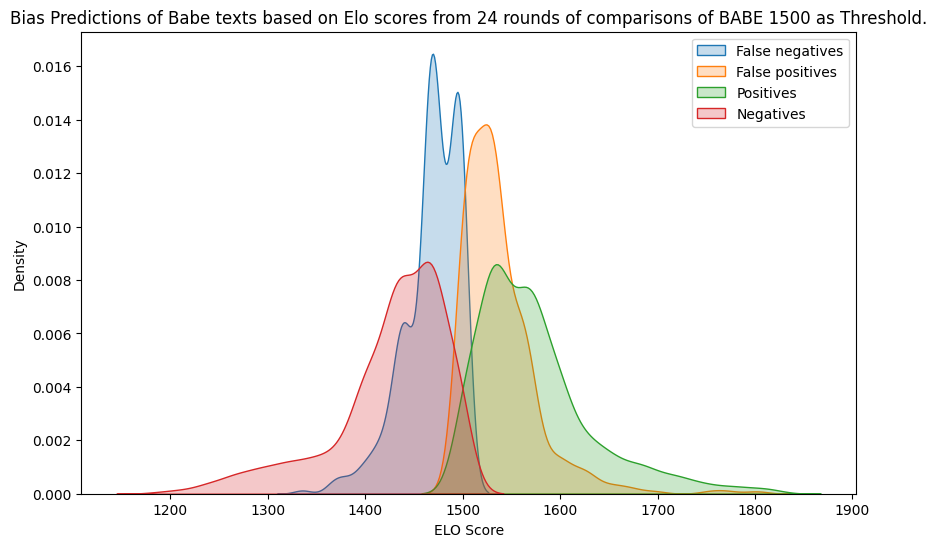

In [ ]:
# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))


sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label_bias'] == "Biased") & (df_babe_agree['bias_elo_score'] != "Biased")].elo_score.to_list(), label='False negatives', shade=True)

sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label_bias'] == "Non-biased") & (df_babe_agree['bias_elo_score'] != "Non-biased")].elo_score.to_list(), label='False positives', shade=True)


sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label_bias'] == "Biased") & (df_babe_agree['bias_elo_score'] == "Biased")].elo_score.to_list(), label='Positives', shade=True)

sns.kdeplot(df_babe_agree.loc[(df_babe_agree['label_bias'] == "Non-biased") & (df_babe_agree['bias_elo_score'] == "Non-biased")].elo_score.to_list(), label='Negatives', shade=True)

# Add titles and labels
#plt.title('Density Plot of ELO Scores for different configurations')
plt.xlabel('ELO Score')
plt.ylabel('Density')

# Add a legend
plt.title("Bias Predictions of Babe texts based on Elo scores from 24 rounds of comparisons of BABE 1500 as Threshold.")
plt.legend()

# Show the plot
plt.show()